In [46]:
emp_dimer_start_frame = 0
emp_dimer_frames_taken = 20
emp_dimer_id = 'dvSM'
emp_dimer_roi = 5.0

opt_x_points = 500
frames_optimization = 20

opt_x = np.linspace(0, lim, opt_x_points)

opt_1_data = get_sm_dist(get_monomer_folder(emp_dimer_id), start_frame=0, int_roi=[roi.EllipseROI((x_center, y_center), (emp_dimer_roi/px_size, emp_dimer_roi/px_size))][0], radius=brightness_radius)
opt_1_data = opt_1_data[opt_1_data['frame']>=emp_dimer_start_frame]
opt_1_data = opt_1_data[opt_1_data['frame']<emp_dimer_start_frame+emp_dimer_frames_taken]

monomer_pdf = generate_pdf(monomer_data['mass']*conversion_factor, sigma_factor=sigma_factor)
opt_1_pdf = generate_pdf(opt_1_data['mass']*conversion_factor, sigma_factor=sigma_factor)
monomer_array = monomer_pdf(opt_x)
opt_1_array = opt_1_pdf(opt_x)

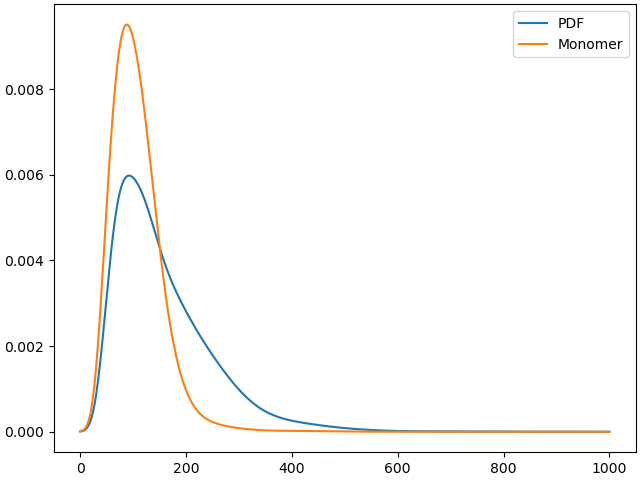

In [47]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(opt_x, opt_1_array, label='PDF')
ax.plot(opt_x, monomer_array, label='Monomer')
ax.legend()

In [48]:
monomer_subtraction = lambda alpha: (opt_1_array - alpha*monomer_array)/(1-alpha)
MD_array = monomer_pdf(opt_x/2)/2
RA_array = scipy.signal.convolve(monomer_array, monomer_array)[:len(monomer_array)]/np.sum(monomer_array)
temp_fitfunc_MD = lambda alpha: np.sum(np.abs(monomer_subtraction(alpha) - MD_array)**2)
temp_fitfunc_RA = lambda alpha: np.sum(np.abs(monomer_subtraction(alpha) - RA_array)**2)
res_MD = optimize.minimize_scalar(temp_fitfunc_MD, bounds=(0, 1))
res_RA = optimize.minimize_scalar(temp_fitfunc_RA, bounds=(0, 1))

C:\Users\mrdxy\AppData\Local\Temp\ipykernel_1000\3563624529.py:1: RuntimeWarning: divide by zero encountered in true_divide
  monomer_subtraction = lambda alpha: (opt_1_array - alpha*monomer_array)/(1-alpha)


MD Residual: 1.1793191555247979e-05
RA Residual: 4.60105643816759e-05


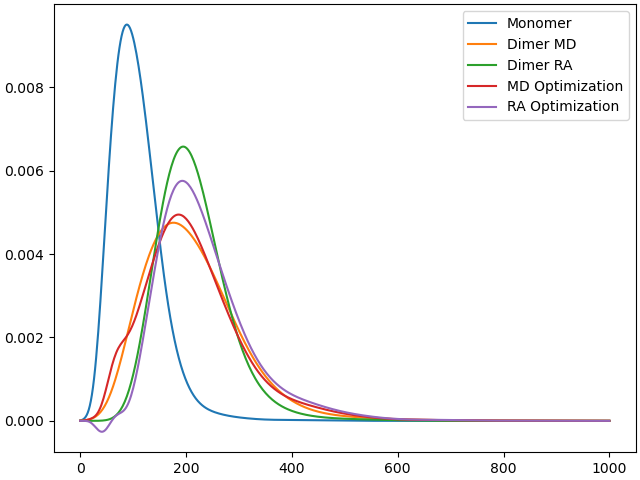

In [49]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(opt_x, monomer_array, label='Monomer')
ax.plot(opt_x, MD_array, label='Dimer MD')
ax.plot(opt_x, RA_array, label='Dimer RA')
ax.plot(opt_x, monomer_subtraction(res_MD.x), label='MD Optimization')
ax.plot(opt_x, monomer_subtraction(res_RA.x), label='RA Optimization')
ax.legend()
print('MD Residual:', res_MD.fun)
print('RA Residual:', res_RA.fun)

In [50]:
alphas_optimization_step = 0.01
alphas_optimization = np.arange(int(1/alphas_optimization_step+1))*alphas_optimization_step

negative_sums_list = np.zeros(int(1/alphas_optimization_step+1))
test = np.zeros_like(negative_sums_list)

for i in range(len(alphas_optimization)):
    temp = opt_1_array - alphas_optimization[i]*monomer_array
    negative_sums_list[i] += np.sum(temp[temp<0]) * lim/opt_x_points

0.59


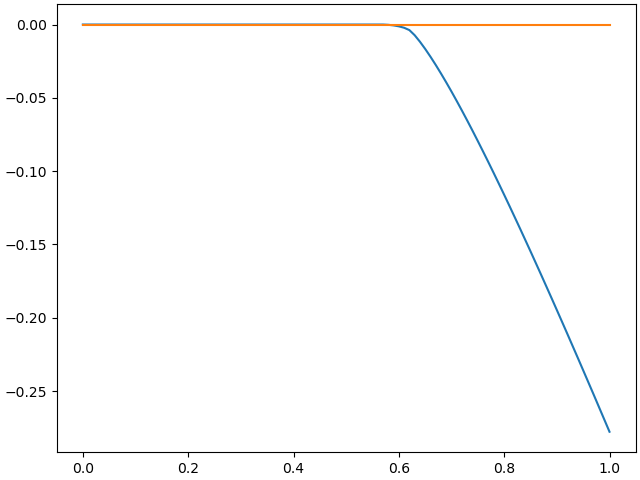

In [51]:
crit_value = -0.0005
if np.argmin(np.abs(negative_sums_list-crit_value)) == 0:
    alpha_optimized = alphas_optimization[negative_sums_list==0][-1]
else:
    alpha_optimized = alphas_optimization[np.argmin(np.abs(negative_sums_list-crit_value))]
print(alpha_optimized)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(alphas_optimization, negative_sums_list)
ax.plot([0, 1], [crit_value, crit_value])

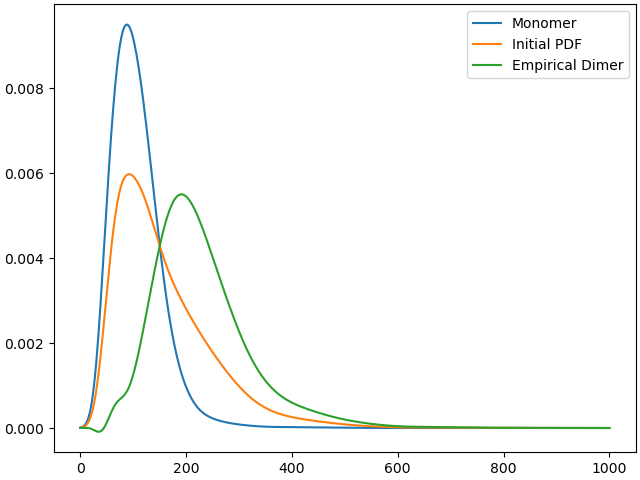

In [52]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(opt_x, monomer_array, label='Monomer')
ax.plot(opt_x, opt_1_array, label='Initial PDF')
ax.plot(opt_x, (opt_1_array-alpha_optimized*monomer_array)/(1-alpha_optimized), label='Empirical Dimer')
ax.legend()
dimer_empirical_pdf = lambda x: (opt_1_pdf(x) - alpha_optimized*monomer_pdf(x))/(1-alpha_optimized)

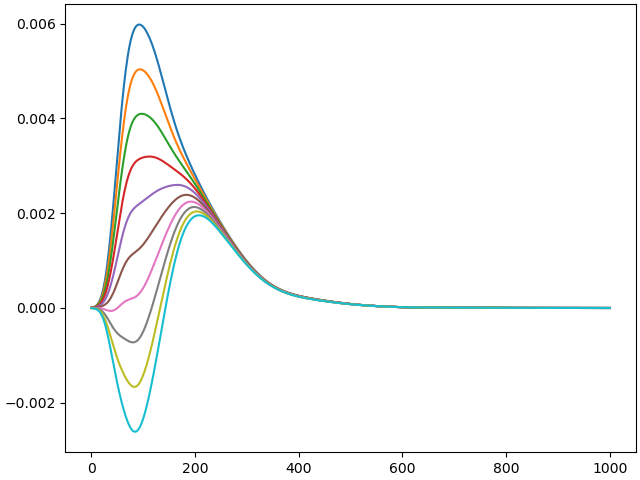

In [53]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(opt_x, (opt_1_array-0.0*monomer_array))
ax.plot(opt_x, (opt_1_array-0.1*monomer_array))
ax.plot(opt_x, (opt_1_array-0.2*monomer_array))
ax.plot(opt_x, (opt_1_array-0.3*monomer_array))
ax.plot(opt_x, (opt_1_array-0.4*monomer_array))
ax.plot(opt_x, (opt_1_array-0.5*monomer_array))
ax.plot(opt_x, (opt_1_array-0.6*monomer_array))
ax.plot(opt_x, (opt_1_array-0.7*monomer_array))
ax.plot(opt_x, (opt_1_array-0.8*monomer_array))
ax.plot(opt_x, (opt_1_array-0.9*monomer_array))

In [ ]:
def determine_roi_startframe(monomer_folder, roi_center, roi_bounds, startframe_bounds, roi_step=0.1, startframe_step=1, conversion_factor=1.0, px_size=0.16, sigma_factor=1.0, fit_lognorm=False, lim=1000, return_chisquare=False):
    
    roi_radii = np.arange(roi_bounds[0], roi_bounds[1]+roi_step, roi_step)
    startframes = np.arange(startframe_bounds[0], startframe_bounds[1]+startframe_step, startframe_step)
    
    init_startframe = np.random.choice(startframes)
    
    last_startframe = None; current_startframe = init_startframe
    last_radius = None; current_radius = None
    
    while (last_startframe!=current_startframe) or (last_radius!=current_radius):
        last_startframe = current_startframe
        last_radius = current_radius
        
        chisquared_temp_roi = pdf_dependence_rois(monomer_folder, roi_center, roi_radii, conversion_factor=conversion_factor, px_size=px_size, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, monomer_start_frame=current_startframe, lim=lim, savepath=None, get_chisquared=True)
        current_radius = roi_radii[np.argmin(chisquared_temp_roi)]
        
        chisquared_temp_startframe = pdf_dependence_startframe(monomer_folder, roi_center, startframes, conversion_factor=conversion_factor, px_size=px_size, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, monomer_roi=current_radius, lim=lim, savepath=None, get_chisquared=True)
        current_startframe = startframes[np.argmin(chisquared_temp_startframe)]
        
        print('Current ROI Radius:', current_radius, 'mu m')
        print('Current Startframe:', current_startframe)
    
    if return_chisquare:
        return current_radius, current_startframe, chisquared_temp_roi, chisquared_temp_startframe
    
    return current_radius, current_startframe

NameError: name 'smoothed_toccsl' is not defined

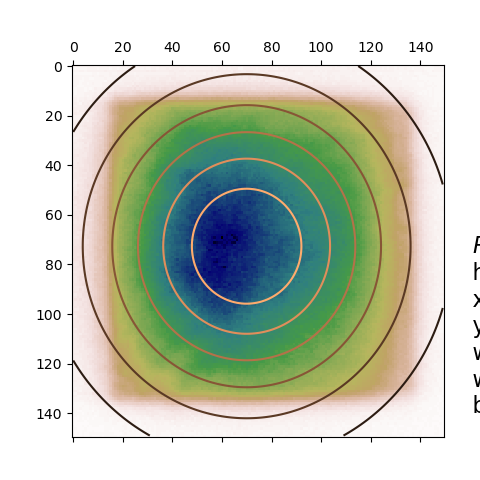

In [10]:
roi_coordinates = crop(profile_im)
r = roi.ROI(roi_coordinates[0], roi_coordinates[1])



profile_im_cropped = r(profile_im)

levels = [0.15, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
#levels = [ 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
if mask_toccsl_bool == True:
    roi_coordinates = crop(profile_im)
    r = roi.ROI(roi_coordinates[0], roi_coordinates[1])
    #profile_im_cropped = r(profile_im) # Commented out by Max
    profile_im_cropped = profile_im # Added by Max

    fit_rel = get_fit_mask(profile_im_cropped, profile_path, filename, fig_show=False)
    fit_parameters = fitgaussian(profile_im_cropped)
    
    fig = choose_ROI(fit_rel, profile_im, levels, smoothed=smoothed_toccsl);
    fig.savefig(results_path.format('choose_ROI.png'))

In [12]:
px_size = 0.16 #µm
central_center = True # If True, the Area center is taken as the ROI center, if False the intensity maximum

In [13]:
# Getting center of the gaussian profile fit
x_center = fit_parameters[2]
y_center = fit_parameters[1]
print('The center is at x:', x_center, 'y:', y_center)

The center is at x: 61.00467767164139 y: 90.93948386280299


In [14]:
central_center = True # If True, the Area center is taken as the ROI center, if False the intensity maximum

In [15]:
# Getting center of the gaussian profile fit
# Be very careful with the indices!!! Weird stuff is going on.
x_center = fit_parameters[2]
y_center = fit_parameters[1]
x_sigma = fit_parameters[4]
y_sigma = fit_parameters[3]
roi_center = (x_center, y_center)
print('The center is at x:', x_center, 'y:', y_center, 'with widths x:', x_sigma, 'y:', y_sigma)

The center is at x: 61.00467767164139 y: 90.93948386280299 with widths x: 50.937297273339674 y: 47.255114008612374


In [16]:
size_x, size_y = profile_im.shape

In [17]:
normalized_profile = np.array(profile_im_cropped)/np.max(np.array(profile_im_cropped))
normalized_profile = ndimage.gaussian_filter(normalized_profile, 4)

In [18]:
# Getting size of the aperture
aperture_thresh = 0.15 # Careful under 1.5 for the newest measurement

one_side_reached = False
for i in range(size_x):
    if one_side_reached:
        if max(normalized_profile[i,:])>aperture_thresh:
            border_down = i
    else:
        if max(normalized_profile[i,:])>aperture_thresh:
            border_up = i
            one_side_reached = True
one_side_reached = False
for i in range(size_y):
    if one_side_reached:
        if max(normalized_profile[:,i])>aperture_thresh:
            border_right = i
    else:
        if max(normalized_profile[:,i])>aperture_thresh:
            border_left = i
            one_side_reached = True

In [19]:
if central_center:
    x_center = border_left+(border_right-border_left)/2; y_center = border_up+(border_down-border_up)/2
    roi_center = (x_center, y_center)

In [20]:
print('ROI Center:', roi_center)

ROI Center: (79.0, 83.0)


In [21]:
print(f'The area with an intensity larger than {aperture_thresh*100}% of the maximum is {round((border_right-border_left)*px_size, 3)}x{round((border_down-border_up)*px_size, 3)} mum^2')

The area with an intensity larger than 15.0% of the maximum is 25.28x24.32 mum^2


C:\Users\mrdxy\anaconda3\lib\site-packages\pims\spe_stack.py:196: UserWarning: Number of frames according to file header does not match the size of file C:/Users/mrdxy/Documents/Analysis_Master_Thesis/analysis/TOCCSL_monovalent\TOCCSL_mSav_AF647_att008_till5ms_trec6s_tbleach4s001_exclude.SPE.
  warnings.warn("Number of frames according to file header "
C:\Users\mrdxy\anaconda3\lib\site-packages\pims\spe_stack.py:196: UserWarning: Number of frames according to file header does not match the size of file C:/Users/mrdxy/Documents/Analysis_Master_Thesis/analysis/TOCCSL_monovalent\TOCCSL_mSav_AF647_att008_till5ms_trec6s_tbleach4s002_exclude.SPE.
  warnings.warn("Number of frames according to file header "
C:\Users\mrdxy\anaconda3\lib\site-packages\pims\spe_stack.py:196: UserWarning: Number of frames according to file header does not match the size of file C:/Users/mrdxy/Documents/Analysis_Master_Thesis/analysis/TOCCSL_monovalent\TOCCSL_mSav_AF647_att008_till5ms_trec6s_tbleach4s003_exclude.S

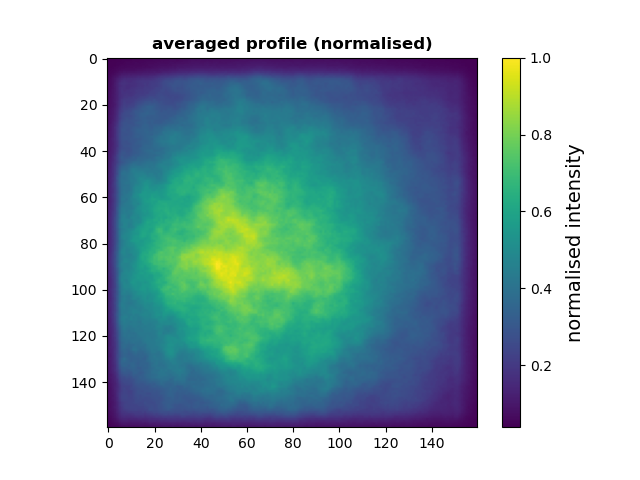

In [26]:
profile_folder_comparison_name = 'TOCCSL_monovalent'


profile_path_comparison = data_path.format(profile_folder_comparison_name+'\\{}')
filename_comparison = getfilenames(folder=data_path.format(profile_folder_comparison_name))

profile_im_comparison, profile_file_comparison = get_mean_profile(filename_comparison, profile_path_comparison, profile_frame=1)

profile_im_comparison_cropped = r(profile_im_comparison)

temp1 = np.max(profile_im_cropped[border_up:border_down, border_left:border_right])
temp2 = np.mean(profile_im_cropped[border_up:border_down, border_left:border_right])
temp3 = np.max(profile_im_comparison_cropped[border_up:border_down, border_left:border_right])
temp4 = np.mean(profile_im_comparison_cropped[border_up:border_down, border_left:border_right])

profile_conversion_factor = temp1*temp4 / (temp2*temp3)

Optimization MD: Success after 0.29820704460144043 s
Bootstrapping MD took 76.0552728176117 s
Optimization RA: Success after 0.18841004371643066 s
Bootstrapping RA took 66.28012323379517 s
Completed all after 174.88218998908997 s

Optimization MD: Success after 0.2513704299926758 s
Bootstrapping MD took 74.53766417503357 s
Optimization RA: Success after 0.2352447509765625 s
Bootstrapping RA took 74.5642261505127 s
Completed all after 177.56625485420227 s

Optimization MD: Success after 0.2986888885498047 s
Bootstrapping MD took 78.96742868423462 s
Optimization RA: Success after 0.21969246864318848 s
Bootstrapping RA took 67.86752080917358 s
Completed all after 175.2222385406494 s

Optimization MD: Success after 0.2197582721710205 s
Bootstrapping MD took 61.4138388633728 s
Optimization RA: Success after 0.2508680820465088 s
Bootstrapping RA took 82.12169742584229 s
Completed all after 171.76752710342407 s

Optimization MD: Success after 0.18137907981872559 s
Bootstrapping MD took 65.064

C:\Users\mrdxy\Documents\Analysis_Master_Thesis\Max_Scripts\Max_TOCCSL\Max_toccsl_analysis.py:232: RuntimeWarning: invalid value encountered in log
  likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_RA(analysis_data_sample, alphas)))


Bootstrapping RA took 74.7059166431427 s
Completed all after 169.03457593917847 s

Optimization MD: Success after 0.1571369171142578 s
Bootstrapping MD took 46.6068913936615 s
Optimization RA: Success after 0.2934231758117676 s
Bootstrapping RA took 67.22159957885742 s
Completed all after 142.03066492080688 s

Optimization MD: Success after 0.1727306842803955 s
Bootstrapping MD took 47.176594495773315 s
Optimization RA: Success after 0.2669360637664795 s
Bootstrapping RA took 67.3709328174591 s
Completed all after 142.5221221446991 s

Optimization MD: Success after 0.15673136711120605 s
Bootstrapping MD took 64.65034008026123 s
Optimization RA: Success after 0.30414295196533203 s
Bootstrapping RA took 69.98835039138794 s
Completed all after 162.59387183189392 s

Optimization MD: Success after 0.1571028232574463 s
Bootstrapping MD took 52.839519023895264 s
Optimization RA: Success after 0.31388068199157715 s
Bootstrapping RA took 76.04146933555603 s
Completed all after 156.9561250209808

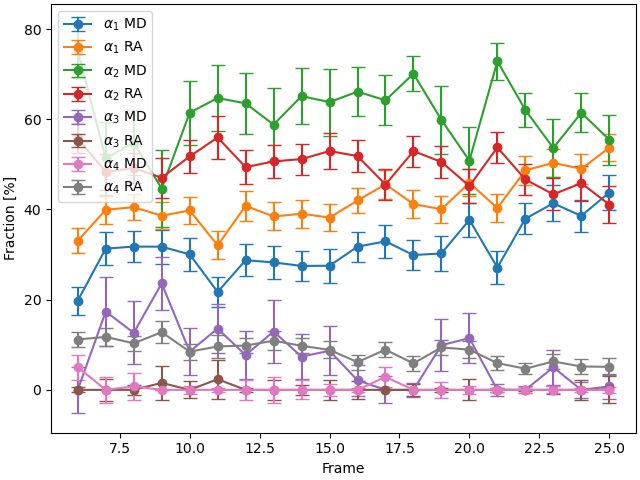

In [284]:
initial_frame = rec_frame
iterations = 20
savepath = results_path.format(f'Fractions_Recovery_mono{monomer_id}_startframe{monomer_start_frame}_Ftaken{frames_taken}_roi{roi_identifier}_n{lim_con}.png')
toccsl_int_data_converted = toccsl_int_data_filtered.copy()
toccsl_int_data_converted['mass'] *= conversion_factor
alphas_frames, errors_frames, kstests = plot_fraction_development(toccsl_int_data_converted, monomer_data*conversion_factor, initial_frame, iterations, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, savepath=savepath)

In [ ]:
frac_dep = {}
i = 0
for i in range(iterations):
    frac_dep[f'Fractions MD Frame {initial_frame+i+1}'] = alphas_frames[0][i]
    frac_dep[f'Errors MD Frame {initial_frame+i+1}'] = errors_frames[0][i]
    frac_dep[f'KS-Test MD Frame {initial_frame+i+1}'] = np.pad(kstests[0][i], (0, lim_con-2))
    frac_dep[f'Fractions RA Frame {initial_frame+i+1}'] = alphas_frames[1][i]
    frac_dep[f'Errors RA Frame {initial_frame+i+1}'] = errors_frames[1][i]
    frac_dep[f'KS-Test RA Frame {initial_frame+i+1}'] = np.pad(kstests[1][i], (0, lim_con-2))
    i += 1
frac_dep = pd.DataFrame.from_dict(frac_dep)
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
frac_dep.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

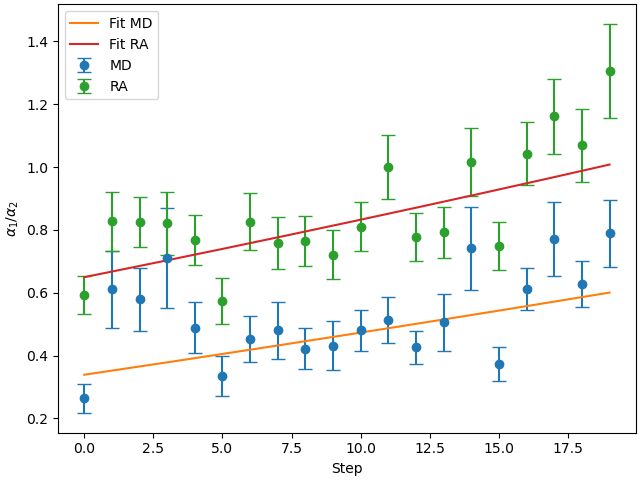

In [285]:
savepath = results_path.format(f'FracFit_Recovery_mono{monomer_id}_startframe{monomer_start_frame}_Ftaken{frames_taken}_roi{roi_identifier}_n{lim_con}.png')
params, errors_fit = fit_fraction(alphas_frames, errors_frames, 0, savepath=savepath)
fit_res = pd.DataFrame(data={'Parameters MD': params[0],'Error MD': errors_fit[0], 'Parameters RA': params[1],'Error RA': errors_fit[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

Optimization MD: Success after 0.050384521484375 s
Bootstrapping MD took 16.43660616874695 s
Optimization RA: Success after 0.04687833786010742 s
Bootstrapping RA took 16.04717493057251 s
Completed all after 56.52030634880066 s

Optimization MD: Success after 0.01563239097595215 s
Bootstrapping MD took 4.627888441085815 s
Optimization RA: Success after 0.03125405311584473 s
Bootstrapping RA took 4.938216686248779 s
Completed all after 29.742132425308228 s

Optimization MD: Success after 0.016044139862060547 s
Bootstrapping MD took 6.044395685195923 s
Optimization RA: Success after 0.01564335823059082 s
Bootstrapping RA took 5.506448030471802 s
Completed all after 31.609278678894043 s

Optimization MD: Success after 0.015651464462280273 s
Bootstrapping MD took 5.739206075668335 s
Optimization RA: Success after 0.03127455711364746 s
Bootstrapping RA took 7.6365578174591064 s
Completed all after 33.48052358627319 s

Optimization MD: Success after 0.016046524047851562 s
Bootstrapping MD to

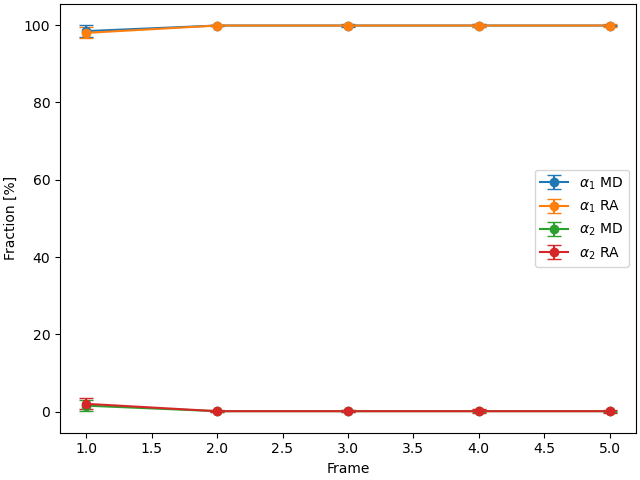

In [53]:
initial_frame = 0
iterations = 20
savepath = results_path.format(f'Fractions_Tracking1_mono{monomer_id}_startframe{monomer_start_frame}_Ftaken{frames_taken}_roi{roi_identifier}_n{lim_con}.png')
sm_int_data_converted = sm_int_data_filtered.copy()
sm_int_data_converted['mass'] *= conversion_factor
alphas_frames, errors_frames, kstests = plot_fraction_development(sm_int_data_converted, monomer_data*conversion_factor, initial_frame, iterations, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, savepath=savepath)

In [54]:
frac_dep = {}
i = 0
for i in range(iterations):
    frac_dep[f'Fractions MD Frame {initial_frame+i+1}'] = alphas_frames[0][i]
    frac_dep[f'Errors MD Frame {initial_frame+i+1}'] = errors_frames[0][i]
    frac_dep[f'KS-Test MD Frame {initial_frame+i+1}'] = np.pad(kstests[0][i], (0, lim_con-2))
    frac_dep[f'Fractions RA Frame {initial_frame+i+1}'] = alphas_frames[1][i]
    frac_dep[f'Errors RA Frame {initial_frame+i+1}'] = errors_frames[1][i]
    frac_dep[f'KS-Test RA Frame {initial_frame+i+1}'] = np.pad(kstests[1][i], (0, lim_con-2))
    i += 1
frac_dep = pd.DataFrame.from_dict(frac_dep)
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
frac_dep.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

In [55]:
savepath = results_path.format(f'FracFit_Tracking1_mono{monomer_id}_startframe{monomer_start_frame}_roi{roi_identifier}_n{lim_con}.png')
params, errors_fit = fit_fraction(alphas_frames, errors_frames, 1, savepath=savepath)
fit_res = pd.DataFrame(data={'Parameters MD': params[0],'Error MD': errors_fit[0], 'Parameters RA': params[1],'Error RA': errors_fit[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

NameError: name 'fit_fraction' is not defined

### **Compare Different Captures**

In [27]:
def get_data_separate(folder, starting_frame, int_roi):
    
    data_dict = {}
    
    h5_files = getfiles(extension='h5', folder=folder)
    
    for f in h5_files:
        name = f.split('/')[-1]
        data_dict[name] = []
        data_dict[name].append(io.load(f))
        data_dict[name]= pd.concat(data_dict[name])
    
        data_dict[name] = data_dict[name][data_dict[name]['frame']>starting_frame] #remove first frame since it's pretty dim
        
        data_dict[name] = int_roi(data_dict[name]) #only use central ROI (laser profile!)
    
        data_dict[name] = data_dict[name][data_dict[name]['bg']>0]
    
    return data_dict

In [ ]:
toccsl_invest_data = get_data_separate(toccsl_folder, start_frame, min_ROI)

if sm_bool == True:
    
    sm_invest_data = get_data_separate(sm_folder, start_frame_sm, min_ROI)

In [29]:
def show_sm_data(data, names):
    fig, ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
    for name in names:
        ax[0].hist(data[name]['mass'])
        ax[1].scatter(data[name]['frame'], data[name]['mass'], s=2)
    fig.show()

interactive(children=(SelectMultiple(description='File:', options=('TOCCSL_mSav_AF647_att008_till5ms_trec6s_tb…

interactive(children=(SelectMultiple(description='File:', options=('mSav_AF647_att008_till5ms_delaymacro10ms_0…

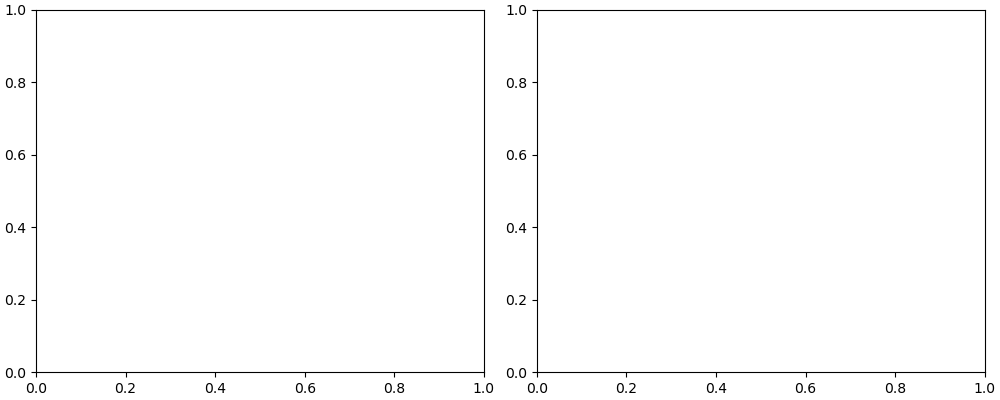

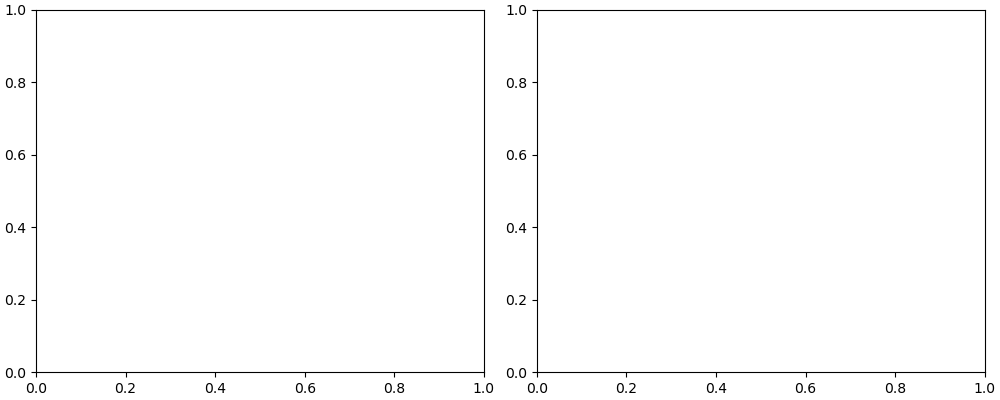

In [30]:
dummy = interact(lambda x: show_sm_data(toccsl_invest_data, x), x=widgets.SelectMultiple(
       options=toccsl_invest_data.keys(),
       description='File:',
       rows=15,
       disabled=False,
       continuous_update=True,
       ))
dummy = interact(lambda x: show_sm_data(sm_invest_data, x), x=widgets.SelectMultiple(
       options=sm_invest_data.keys(),
       description='File:',
       rows=15,
       disabled=False,
       continuous_update=True,
       ))

In [ ]:
# The colocalizations need to be proportional to the fractions of the monomers/dimers, would need to be overhauled quite a bit


def get_alphas_realistic_dimer(analysis_data_photons, monomer_data_photons, lim=1000, lim_con=lim_con, n_bootstrap=400, sigma_factor=None, bins=30, savepath=None, donotplot=False):
    '''
    Creates probabilty density functions, fits given data, does bootstrapping and plots final results.
    If dataset sm_data is given sm pdf will be calculated from this dataset
    If dataset sm_data is not given sm pdf will be calculated from the TOCCSL dataset either starting at given monomer_start_frame or considering the last frame only.
    Parameters:
        toccsl_data: pd.DataFrame
        sm_data: pd.DataFrame
        rec_frame: int; specifies frist recovery frame in TOCCSL data
        lim: limit of pdfs on x axis
        lim_con: int; limits the number of convolutions, i.e. the number of oligomeric states to consider
        iterations: number of iterations used for bootstrapping (defaults to 100)
        perc: fraction of data available to generate the monomeric pdf that will be used for bootstrapping
        save_path: formatable string specifying path to save final plot to. Will be formated with lim_con
    Returns:
        alphas: list containing fraction of each oligomeric structure
        fitted_pd: fitted y data
        means: list containing means from bootstrapping
        SEMs: list containing SEMs from bootstrapping
        fig: final plot
    '''
    full_start = time.time()
    n_samples = len(analysis_data_photons)
    
    # Constraint for fit
    cons=({'type': 'ineq',
    'fun': lambda x: 1.0-np.sum(x)})
    
    if lim==None:
        lim = int(max(analysis_data_photons))
    
    ####### Get results using all data
    ### Generate PDFs    
    
    pdfs = []
    
    data_rho1 = monomer_data_photons['mass']
    
    data_rhodata = analysis_data_photons

    x1, y1 = get_pdf_local(data_rho1, lim=lim, sigma_factor=sigma_factor)
    pdfs.append((x1, y1))
    x_temp, y_temp = get_pdf_local(2*data_rho1, lim=lim, sigma_factor=sigma_factor)
    pdfs.append((x_temp,y_temp))
    y_temp = signal.convolve(pdfs[0][1], y1, mode='full', method='auto')/sum(pdfs[0][1])
    pdfs.append((x1,y_temp[:len(x1)]))
    y_temp = signal.convolve(pdfs[1][1], y1, mode='full', method='auto')/sum(pdfs[1][1])
    pdfs.append((x1,y_temp[:len(x1)]))
    y_temp = signal.convolve(pdfs[1][1], pdfs[1][1], mode='full', method='auto')/sum(pdfs[1][1])
    pdfs.append((x1,y_temp[:len(x1)]))
    
    
    ### Fit making sure no alpha_i is samller than zero
    
    # Generate model function for the PDF
    model_pdf_realistic = lambda x, alphas: interpolate.interp1d(pdfs[0][0], model_pdf(pdfs, *alphas), kind='cubic')(x[x<lim])
    # Initializing the negative log of the likelihood function to be minimized
    likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_realistic(analysis_data_photons, alphas)))
    # Performing the fit
    start = time.time()
    res = optimize.minimize(likelihood_estimator, np.ones(4)/5, bounds=tuple(zip([0]*4, [1]*4)), constraints=cons)
    end = time.time()
    if res.success:
        print('Optimization: Success after', end-start, 's')
    else:
        print('Optimization: Failure after', end-start, 's')
    fit = res.x
    alphas = list(fit) + [1-np.sum(fit)]
    if alphas[-1]<0 and alphas[-1]>-0.000001:
        alphas[-1] = 0
    # Perform bootstrapping
    start = time.time()
    alphas_bootstrap = []
    for i in range(n_bootstrap):
        analysis_data_sample = analysis_data_photons.sample(n_samples, replace=True)
        likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_realistic(analysis_data_sample, alphas)))
        res = optimize.minimize(likelihood_estimator, fit, bounds=tuple(zip([0]*(4), [1]*4)), constraints=cons)
        fit_temp = res.x
        alphas_temp = list(fit_temp) + [1-np.sum(fit_temp)]
        alphas_bootstrap.append(alphas_temp)
    alphas_bootstrap = np.array(alphas_bootstrap)
    errors = np.zeros_like(alphas)
    for i in range(len(errors)):
        errors[i] = np.std(alphas_bootstrap[:,i])
    end = time.time()
    print('Bootstrapping took', end-start, 's')
    
    fitted_pd = model_pdf(pdfs, *fit)
    
    
    text = []
    text.append('Monomer' + ': ({}'.format(round(alphas[0]*100,4)) + ' $\pm$ {})%'.format(round(errors[0]*100,4)))
    text.append('Dimer' + ': ({}'.format(round(alphas[1]*100,4)) + ' $\pm$ {})%'.format(round(errors[1]*100,4)))
    text.append('M+M col.' + ': ({}'.format(round(alphas[2]*100,4)) + ' $\pm$ {})%'.format(round(errors[2]*100,4)))
    text.append('M+D col.' + ': ({}'.format(round(alphas[3]*100,4)) + ' $\pm$ {})%'.format(round(errors[3]*100,4)))
    text.append('D+D col.' + ': ({}'.format(round(alphas[4]*100,4)) + ' $\pm$ {})%'.format(round(errors[4]*100,4)))
    
    full_end = time.time()
    print('Completed all after', full_end-full_start, 's\n')
    
    if donotplot:
        return alphas, errors, fitted_pd
        
    
    fig, ax = plt.subplots(constrained_layout=True)
    
    ax.hist(analysis_data_photons, bins=bins, range=(0, lim), color='skyblue')
    ax.plot(pdfs[0][0], len(analysis_data_photons)*(lim/bins)*np.array(fitted_pd), label='Fit')
    for a, pd, t in zip(alphas, pdfs, text):
        ax.plot(pd[0], len(analysis_data_photons)*(lim/bins)*np.array([a*y for y in pd[1]]), label=t)
    ax.legend()
    ax.set_xlabel('brightness [counts]')
    ax.set_ylabel('PDF')
    
    if savepath != None:
        fig.savefig(savepath)
    
    return alphas, errors, fitted_pd

In [123]:
add_next_frames = 10

for i in range(1, add_next_frames+1):
    track_lengths_temp, probability_scaling_temp, survival_probability_temp = track_length_data(trc_data, analysis_roi, px_size, roi_center, normalized_profile, first_frame+i)
    track_lengths = np.concatenate([track_lengths, track_lengths_temp])
    probability_scaling = np.concatenate([probability_scaling, probability_scaling_temp])
    survival_probability = np.concatenate([survival_probability, survival_probability_temp])
    print('Added frame', first_frame+i)

Added frame 1
Added frame 2
Added frame 3
Added frame 4
Added frame 5
Added frame 6
Added frame 7
Added frame 8
Added frame 9
Added frame 10


In [56]:
plt.close('all')
    samples = analysis_data_photons[analysis_data_photons<=lim]
    plt.plot(np.sort(samples), np.cumsum(model_pdf_MD(np.sort(samples), fit_MD))/np.sum(model_pdf_MD(samples, fit_MD)))
    plt.plot(np.sort(samples), np.arange(len(samples))/len(samples))
    statistic_value = np.max(np.abs(np.arange(len(samples))/len(samples) - np.cumsum(model_pdf_MD(np.sort(samples), fit_MD))/np.sum(model_pdf_MD(samples, fit_MD))))
    p_value = np.exp(-2*len(samples)*statistic_value**2)
    kstest_MD = np.array([statistic_value, p_value])
    print(statistic_value, p_value)
    return

IndentationError: unexpected indent (1669944439.py, line 2)

In [107]:
toccsl_res = pd.DataFrame(data={'Fraction MD': alphas[0],'Error MD': errors[0], 'Fraction RA': alphas[1],'Error RA': errors[1], 'KS-Test MD': np.pad(kstests[0], (0, lim_con-2)), 'KS-Test RA': np.pad(kstests[1], (0, lim_con-2))})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
toccsl_res.to_excel(writer, sheet_name='TOCCSL Results')
writer.save()

In [101]:
def get_alphas(analysis_data_photons, monomer_data_photons, lim=1000, lim_con=2, n_bootstrap=400, sigma_factor=None, fit_lognorm=False, bins=30, savepath=None, donotplot=False):
    '''
    Creates probabilty density functions, fits given data, does bootstrapping and plots final results.
    If dataset sm_data is given sm pdf will be calculated from this dataset
    If dataset sm_data is not given sm pdf will be calculated from the TOCCSL dataset either starting at given monomer_start_frame or considering the last frame only.
    Parameters:
        toccsl_data: pd.DataFrame
        sm_data: pd.DataFrame
        rec_frame: int; specifies frist recovery frame in TOCCSL data
        lim: limit of pdfs on x axis
        lim_con: int; limits the number of convolutions, i.e. the number of oligomeric states to consider
        iterations: number of iterations used for bootstrapping (defaults to 100)
        perc: fraction of data available to generate the monomeric pdf that will be used for bootstrapping
        save_path: formatable string specifying path to save final plot to. Will be formated with lim_con
    Returns:
        alphas: list containing fraction of each oligomeric structure
        fitted_pd: fitted y data
        means: list containing means from bootstrapping
        SEMs: list containing SEMs from bootstrapping
        fig: final plot
    '''
    full_start = time.time()
    n_samples = len(analysis_data_photons)
    bias = 0.001
    min_ = 0.0001
    # Constraint for fit
    cons=({'type': 'ineq',
    'fun': lambda x: 1.0-np.sum(x)})
    
    if lim==None:
        lim = int(max(analysis_data_photons))
    
    ####### Get results using all data
    ### Generate PDFs
    pdfs_MD, pdf_data_MD = get_pdfs_local(analysis_data_photons, monomer_data_photons, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, method='MD')
    
    ### Fit making sure no alpha_i is samller than zero
    alphas_MD = [1]*(lim_con-1) + [-1]
    
    bounds_up = [a-bias for a in alphas_MD[:-1]]
    if alphas_MD[-1]>min_:
        bounds_up = [a if a>0 else a-min_ for a in bounds_up]
    else:
        bounds_up = [a if a>0 else min_ for a in bounds_up]
    # Generate model function for the PDF
    model_pdf_MD = lambda x, alphas: interpolate.interp1d(pdf_data_MD[0], model_pdf(pdfs_MD, *alphas), kind='cubic')(x[x<=lim])
    # Initializing the negative log of the likelihood function to be minimized
    likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_MD(analysis_data_photons, alphas)))
    # Performing the fit
    start = time.time()
    res = optimize.minimize(likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
    end = time.time()
    if res.success:
        print('Optimization MD: Success after', end-start, 's')
    else:
        print('Optimization MD: Failure after', end-start, 's')
    fit_MD = res.x
    alphas_MD = list(fit_MD) + [1-np.sum(fit_MD)]
    if alphas_MD[-1]<0 and alphas_MD[-1]>-0.000001:
        alphas_MD[-1] = 0
    
    samples = analysis_data_photons[analysis_data_photons<=lim]
    statistic_value = np.max(np.abs(np.arange(len(samples))/len(samples) - np.cumsum(model_pdf_MD(np.sort(samples), fit_MD))/np.sum(model_pdf_MD(samples, fit_MD))))
    p_value = np.exp(-2*len(samples)*statistic_value**2)
    kstest_MD = np.array([statistic_value, p_value])
    
    # Perform bootstrapping
    start = time.time()
    alphas_bootstrap_MD = []
    for i in range(n_bootstrap):
        analysis_data_sample = analysis_data_photons.sample(n_samples, replace=True)
        likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_MD(analysis_data_sample, alphas)))
        res = optimize.minimize(likelihood_estimator, fit_MD, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
        fit_temp = res.x
        alphas_temp = list(fit_temp) + [1-np.sum(fit_temp)]
        alphas_bootstrap_MD.append(alphas_temp)
    alphas_bootstrap_MD = np.array(alphas_bootstrap_MD)
    errors_MD = np.zeros_like(alphas_MD)
    for i in range(len(errors_MD)):
        errors_MD[i] = np.std(alphas_bootstrap_MD[:,i])
    end = time.time()
    print('Bootstrapping MD took', end-start, 's')
    
    fitted_pd_MD = model_pdf(pdfs_MD, *fit_MD)
    
    
    ### Generate PDFs
    pdfs_RA, pdf_data_RA = get_pdfs_local(analysis_data_photons, monomer_data_photons, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, method='RA')
    
    ### Fit making sure no alpha_i is samller than zero
    alphas_RA = [1]*(lim_con-1) + [-1]
    
    bounds_up = [a-bias for a in alphas_RA[:-1]]
    if alphas_RA[-1]>min_:
        bounds_up = [a if a>0 else a-min_ for a in bounds_up]
    else:
        bounds_up = [a if a>0 else min_ for a in bounds_up]
    # Generate model function for the PDF
    model_pdf_RA = lambda x, alphas: interpolate.interp1d(pdf_data_RA[0], model_pdf(pdfs_RA, *alphas), kind='cubic')(x[x<=lim])
    # Initializing the negative log of the likelihood function to be minimized
    likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_RA(analysis_data_photons, alphas)))
    # Performing the fit
    start = time.time()
    res = optimize.minimize(likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
    end = time.time()
    if res.success:
        print('Optimization RA: Success after', end-start, 's')
    else:
        print('Optimization RA: Failure after', end-start, 's')
    fit_RA = res.x
    alphas_RA = list(fit_RA) + [1-np.sum(fit_RA)]
    if alphas_RA[-1]<0 and alphas_RA[-1]>-0.000001:
        alphas_RA[-1] = 0
    
    samples = analysis_data_photons[analysis_data_photons<=lim]
    statistic_value = np.max(np.abs(np.arange(len(samples))/len(samples) - np.cumsum(model_pdf_RA(np.sort(samples), fit_RA))/np.sum(model_pdf_RA(samples, fit_RA))))
    p_value = np.exp(-2*len(samples)*statistic_value**2)
    kstest_RA = np.array([statistic_value, p_value])
    
    # Perform bootstrapping
    start = time.time()
    alphas_bootstrap_RA = []
    for i in range(n_bootstrap):
        analysis_data_sample = analysis_data_photons.sample(n_samples, replace=True)
        likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_RA(analysis_data_sample, alphas)))
        res = optimize.minimize(likelihood_estimator, fit_RA, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
        fit_temp = res.x
        alphas_temp = list(fit_temp) + [1-np.sum(fit_temp)]
        alphas_bootstrap_RA.append(alphas_temp)
    alphas_bootstrap_RA = np.array(alphas_bootstrap_RA)
    errors_RA = np.zeros_like(alphas_RA)
    for i in range(len(errors_RA)):
        errors_RA[i] = np.std(alphas_bootstrap_RA[:,i])
    end = time.time()
    print('Bootstrapping RA took', end-start, 's')
    
    fitted_pd_RA = model_pdf(pdfs_RA, *fit_RA)
    

    text_MD = []
    for n in range(lim_con):
        text_MD.append(r'$\rho_{}$ MD'.format(n+1) + ': ({}'.format(round(alphas_MD[n]*100,4)) + ' $\pm$ {})%'.format(round(errors_MD[n]*100,4)))
    text_RA = []
    for n in range(lim_con):
        text_RA.append(r'$\rho_{}$ RA'.format(n+1) + ': ({}'.format(round(alphas_RA[n]*100,4)) + ' $\pm$ {})%'.format(round(errors_RA[n]*100,4)))
    
    alphas = [alphas_MD, alphas_RA]
    errors = [errors_MD, errors_RA]
    fitted_pd = [fitted_pd_MD, fitted_pd_RA]
    kstests = [kstest_MD, kstest_RA]
    
    full_end = time.time()
    print('Completed all after', full_end-full_start, 's\n')
    
    if donotplot:
        return alphas, errors, fitted_pd, kstests
        
    
    fig, ax = plt.subplots(constrained_layout=True)
    
    ax.hist(analysis_data_photons, bins=bins, range=(0, lim), color='skyblue')
    ax.plot(pdf_data_MD[0], len(analysis_data_photons)*(lim/bins)*np.array(fitted_pd_MD), label='Fit MD')
    ax.plot(pdf_data_RA[0], len(analysis_data_photons)*(lim/bins)*np.array(fitted_pd_RA), label='Fit RA')
    for a, pd, t in zip(alphas_MD, pdfs_MD, text_MD):
        ax.plot(pd[0], len(analysis_data_photons)*(lim/bins)*np.array([a*y for y in pd[1]]), label=t)
    for a, pd, t in zip(alphas_RA, pdfs_RA, text_RA):
        ax.plot(pd[0], len(analysis_data_photons)*(lim/bins)*np.array([a*y for y in pd[1]]), label=t)
    ax.legend()
    ax.set_xlabel('brightness [counts]')
    ax.set_ylabel('PDF')
    
    if savepath != None:
        fig.savefig(savepath)
    
    return alphas, errors, fitted_pd, kstests

In [73]:
localization_impercision = np.std(np.concatenate(immobile_positions)*px_size)
mean_distance = np.mean(np.sqrt(square_displacements))
rms_distance = np.sqrt(np.mean(square_displacements))
print('The mean travelled distance is', mean_distance, '$\mu$m')
print('The RMS distance is', rms_distance, '$\mu$m')
print('The localization impercision is', 1000*localization_impercision, 'nm')
print('The beta value is', mean_distance/localization_impercision, '(should be larger than ~7)')
print('The beta value is', mean_distance/localization_impercision_guess, 'with the guess given')

ValueError: need at least one array to concatenate

In [74]:
np.mean(msd_per_particle)/(4*t_del_corrected)

0.9040565066802925

Text(0, 0.5, 'Mean photon count')

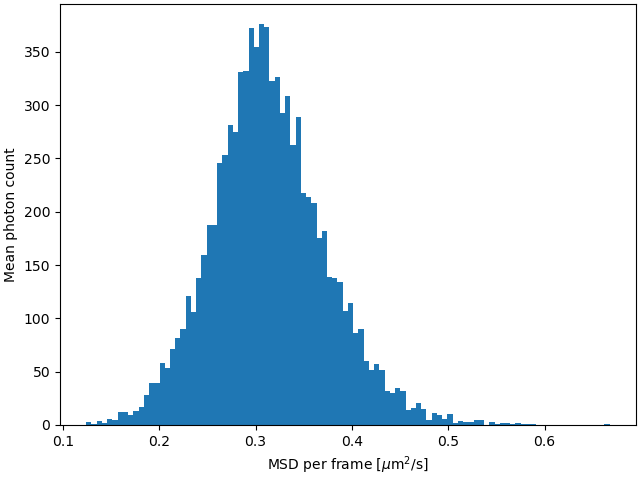

In [75]:
fig, ax = plt.subplots(constrained_layout=True)
ax.hist(np.sqrt(msd_per_particle), bins=100)
ax.set_xlabel('MSD per frame [$\mu$m$^2$/s]')
ax.set_ylabel('Mean photon count')

In [76]:
print(potential_immobilities)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [77]:
test = motion.Msd(trc_data, fps, pixel_size=pixel_size, ensemble=False)
msd_test, err_test = test.get_msd()

In [78]:
bin_lower = 0; bin_upper = 1.5

particle_msd_vals = {}
binned_counts = {}
bin_edges = {}
msd_map = []

first_run = True
times = np.array(msd_test.keys())

for key in msd_test.keys():
    particle_msd_vals[key] = np.array(msd_test[key])
    binned_counts[key], bin_edges[key] = np.histogram(particle_msd_vals[key], bins=50, range=(bin_lower,bin_upper))
    if first_run:
        msd_map = np.flip(binned_counts[key])/len(particle_msd_vals[key])
        first_run = False
    else:
        msd_map = np.c_[msd_map, np.flip(binned_counts[key])/len(particle_msd_vals[key])]

In [79]:
print(f'Estimate of immobile particles producing a track of {times[-1]}s in each file from first to last')
x = np.zeros(len(sm_files))
for i in range(len(sm_files)):
    x[i] = np.sum(np.array(msd_test[0.3][i,:]) < 0.1)
    
print(x)

Estimate of immobile particles producing a track of 0.3s in each file from first to last
[4. 3. 5. 3. 0. 4. 2. 2. 2. 1. 1. 2. 2. 2. 4. 4. 3. 3. 2. 4. 1. 1. 3. 0.
 2. 4. 1. 2. 0. 1. 3. 1. 0. 0. 0. 0. 3. 3. 3. 0. 0. 2. 3. 8. 4. 3. 5. 1.
 4. 3. 3. 2. 3. 1. 1. 3. 8. 2. 0. 3.]


Text(0.5, 0, 'lag time [s]')

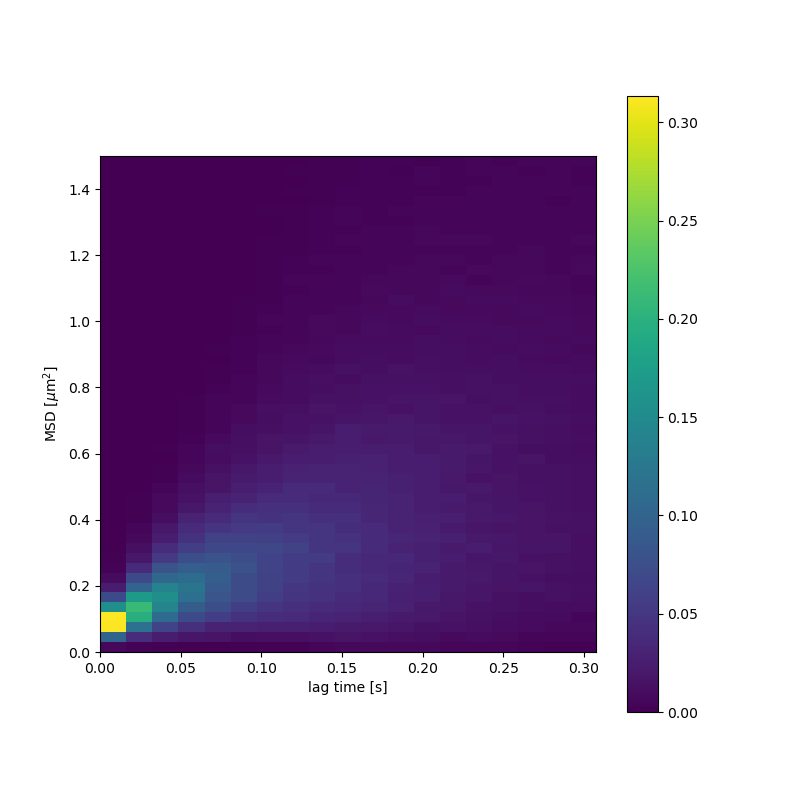

In [80]:
fig, ax = plt.subplots(figsize=(8,8))

aspect_ratio = (times[-1]+times[0]/2)/(bin_upper-bin_lower)

diffusion_map = ax.imshow(msd_map[:,1:], aspect=aspect_ratio, extent=[0,times[-1]+times[0]/2,bin_lower,bin_upper])

fig.colorbar(diffusion_map)
ax.set_ylabel('MSD [$\mu$m$^2$]')
ax.set_xlabel('lag time [s]')

#fig.savefig(results_path.format('Diffusion_Map.png'))

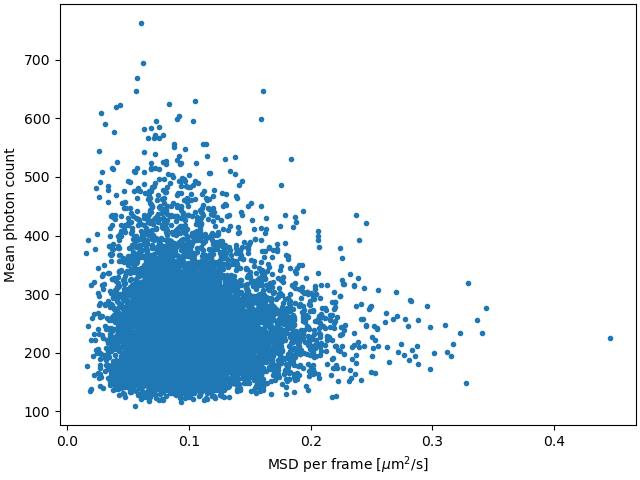

In [81]:
fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(msd_per_particle, meanbright_per_particle, marker='.')
ax.set_xlabel('MSD per frame [$\mu$m$^2$/s]')
ax.set_ylabel('Mean photon count')
fig.savefig(results_path.format(f'MSDBrightness_useTOCCSL{use_toccsl}_smROI{smroi_id}_{step_size}step.png'))

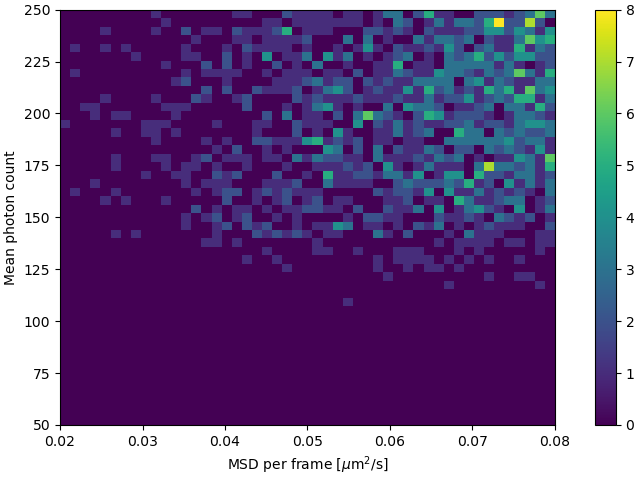

In [82]:
fig, ax = plt.subplots(constrained_layout=True)
bins_x=50; bins_y=50; lim_low_x=0.02; lim_high_x=0.08; lim_low_y=50; lim_high_y=250
bins_2d = [np.linspace(lim_low_x, lim_high_x, bins_x), np.linspace(lim_low_y, lim_high_y, bins_y)]
hist_2d = ax.hist2d(msd_per_particle, meanbright_per_particle, bins=bins_2d)
ax.set_xlabel('MSD per frame [$\mu$m$^2$/s]')
ax.set_ylabel('Mean photon count')
fig.colorbar(hist_2d[3], ax=ax)

In [ ]:
def get_alphas(analysis_data_photons, monomer_data_photons, lim=1000, lim_con=2, n_bootstrap=400, sigma_factor=None, fit_lognorm=False, bins=30, savepath=None, donotplot=False):
    '''
    Creates probabilty density functions, fits given data, does bootstrapping and plots final results.
    If dataset sm_data is given sm pdf will be calculated from this dataset
    If dataset sm_data is not given sm pdf will be calculated from the TOCCSL dataset either starting at given monomer_start_frame or considering the last frame only.
    Parameters:
        toccsl_data: pd.DataFrame
        sm_data: pd.DataFrame
        rec_frame: int; specifies frist recovery frame in TOCCSL data
        lim: limit of pdfs on x axis
        lim_con: int; limits the number of convolutions, i.e. the number of oligomeric states to consider
        iterations: number of iterations used for bootstrapping (defaults to 100)
        perc: fraction of data available to generate the monomeric pdf that will be used for bootstrapping
        save_path: formatable string specifying path to save final plot to. Will be formated with lim_con
    Returns:
        alphas: list containing fraction of each oligomeric structure
        fitted_pd: fitted y data
        means: list containing means from bootstrapping
        SEMs: list containing SEMs from bootstrapping
        fig: final plot
    '''
    full_start = time.time()
    n_samples = len(analysis_data_photons)
    bias = 0.001
    min_ = 0.0001
    # Constraint for fit
    cons=({'type': 'ineq',
    'fun': lambda x: 1.0-np.sum(x)})
    
    if lim==None:
        lim = int(max(analysis_data_photons))
    
    ####### Get results using all data
    ### Generate PDFs
    pdfs_MD, pdf_data_MD = get_pdfs_local(analysis_data_photons, monomer_data_photons, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, method='MD')
    
    ### Fit making sure no alpha_i is samller than zero
    alphas_MD = [1]*(lim_con-1) + [-1]
    
    bounds_up = [a-bias for a in alphas_MD[:-1]]
    if alphas_MD[-1]>min_:
        bounds_up = [a if a>0 else a-min_ for a in bounds_up]
    else:
        bounds_up = [a if a>0 else min_ for a in bounds_up]
    # Generate model function for the PDF
    model_pdf_MD = lambda x, alphas: interpolate.interp1d(pdf_data_MD[0], model_pdf(pdfs_MD, *alphas), kind='cubic')(x[x<=lim])
    # Initializing the negative log of the likelihood function to be minimized
    likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_MD(analysis_data_photons, alphas)))
    # Performing the fit
    start = time.time()
    res = optimize.minimize(likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
    end = time.time()
    if res.success:
        print('Optimization MD: Success after', end-start, 's')
    else:
        print('Optimization MD: Failure after', end-start, 's')
    fit_MD = res.x
    alphas_MD = list(fit_MD) + [1-np.sum(fit_MD)]
    if alphas_MD[-1]<0 and alphas_MD[-1]>-0.000001:
        alphas_MD[-1] = 0
    
    plt.close('all')
    samples = analysis_data_photons[analysis_data_photons<=lim]
    plt.plot(np.sort(samples), np.cumsum(model_pdf_MD(np.sort(samples), fit_MD))/np.sum(model_pdf_MD(samples, fit_MD)))
    plt.plot(np.sort(samples), np.arange(len(samples))/len(samples))
    return
    
    # Perform bootstrapping
    start = time.time()
    alphas_bootstrap_MD = []
    for i in range(n_bootstrap):
        analysis_data_sample = analysis_data_photons.sample(n_samples, replace=True)
        likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_MD(analysis_data_sample, alphas)))
        res = optimize.minimize(likelihood_estimator, fit_MD, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
        fit_temp = res.x
        alphas_temp = list(fit_temp) + [1-np.sum(fit_temp)]
        alphas_bootstrap_MD.append(alphas_temp)
    alphas_bootstrap_MD = np.array(alphas_bootstrap_MD)
    errors_MD = np.zeros_like(alphas_MD)
    for i in range(len(errors_MD)):
        errors_MD[i] = np.std(alphas_bootstrap_MD[:,i])
    end = time.time()
    print('Bootstrapping MD took', end-start, 's')
    
    fitted_pd_MD = model_pdf(pdfs_MD, *fit_MD)
    
    print('1')
    def model_pdf_MD_test(x):
        if (x>pdf_data_MD[0][0]) and (x<pdf_data_MD[0][-1]):
            return interpolate.interp1d(pdf_data_MD[0], model_pdf(pdfs_MD, *fit_MD), kind='cubic')(x)
        else:
            return 0.0
    class dist_MD_class(stats.rv_continuous):
        def _pdf(self, x):
            return model_pdf_MD_test(x)
    print('2')
    dist_MD = dist_MD_class(name='dist_MD')
    print('3')
    kstest_MD = stats.kstest(analysis_data_photons, lambda x: dist_MD.cdf(np.array([x])))
    print('4')
    
    ### Generate PDFs
    pdfs_RA, pdf_data_RA = get_pdfs_local(analysis_data_photons, monomer_data_photons, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, fit_lognorm=fit_lognorm, method='RA')
    
    ### Fit making sure no alpha_i is samller than zero
    alphas_RA = [1]*(lim_con-1) + [-1]
    
    bounds_up = [a-bias for a in alphas_RA[:-1]]
    if alphas_RA[-1]>min_:
        bounds_up = [a if a>0 else a-min_ for a in bounds_up]
    else:
        bounds_up = [a if a>0 else min_ for a in bounds_up]
    # Generate model function for the PDF
    model_pdf_RA = lambda x, alphas: interpolate.interp1d(pdf_data_RA[0], model_pdf(pdfs_RA, *alphas), kind='cubic')(x[x<=lim])
    # Initializing the negative log of the likelihood function to be minimized
    likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_RA(analysis_data_photons, alphas)))
    # Performing the fit
    start = time.time()
    res = optimize.minimize(likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
    end = time.time()
    if res.success:
        print('Optimization RA: Success after', end-start, 's')
    else:
        print('Optimization RA: Failure after', end-start, 's')
    fit_RA = res.x
    alphas_RA = list(fit_RA) + [1-np.sum(fit_RA)]
    if alphas_RA[-1]<0 and alphas_RA[-1]>-0.000001:
        alphas_RA[-1] = 0
    # Perform bootstrapping
    start = time.time()
    alphas_bootstrap_RA = []
    for i in range(n_bootstrap):
        analysis_data_sample = analysis_data_photons.sample(n_samples, replace=True)
        likelihood_estimator = lambda alphas: -1.0*np.sum(np.log(model_pdf_RA(analysis_data_sample, alphas)))
        res = optimize.minimize(likelihood_estimator, fit_RA, bounds=tuple(zip([0]*(lim_con-1), bounds_up)), constraints=cons)
        fit_temp = res.x
        alphas_temp = list(fit_temp) + [1-np.sum(fit_temp)]
        alphas_bootstrap_RA.append(alphas_temp)
    alphas_bootstrap_RA = np.array(alphas_bootstrap_RA)
    errors_RA = np.zeros_like(alphas_RA)
    for i in range(len(errors_RA)):
        errors_RA[i] = np.std(alphas_bootstrap_RA[:,i])
    end = time.time()
    print('Bootstrapping RA took', end-start, 's')
    
    fitted_pd_RA = model_pdf(pdfs_RA, *fit_RA)
    
    def model_pdf_RA_test(x):
        if (x>pdf_data_RA[0][0]) and (x<pdf_data_RA[0][-1]):
            return interpolate.interp1d(pdf_data_RA[0], model_pdf(pdfs_RA, *fit_RA), kind='cubic')(x)
        else:
            return 0.0
    class dist_RA_class(stats.rv_continuous):
        def _pdf(self, x):
            return model_pdf_RA_test(x)
    dist_RA = dist_RA_class(name='dist_RA')
    kstest_RA = stats.kstest(analysis_data_photons, lambda x: dist_RA.cdf(np.array([x])))

    text_MD = []
    for n in range(lim_con):
        text_MD.append(r'$\rho_{}$ MD'.format(n+1) + ': ({}'.format(round(alphas_MD[n]*100,4)) + ' $\pm$ {})%'.format(round(errors_MD[n]*100,4)))
    text_RA = []
    for n in range(lim_con):
        text_RA.append(r'$\rho_{}$ RA'.format(n+1) + ': ({}'.format(round(alphas_RA[n]*100,4)) + ' $\pm$ {})%'.format(round(errors_RA[n]*100,4)))
    
    alphas = [alphas_MD, alphas_RA]
    errors = [errors_MD, errors_RA]
    fitted_pd = [fitted_pd_MD, fitted_pd_RA]
    kstests = [kstest_MD, kstest_RA]
    
    full_end = time.time()
    print('Completed all after', full_end-full_start, 's\n')
    
    if donotplot:
        return alphas, errors, fitted_pd, kstests
        
    
    fig, ax = plt.subplots(constrained_layout=True)
    
    ax.hist(analysis_data_photons, bins=bins, range=(0, lim), color='skyblue')
    ax.plot(pdf_data_MD[0], len(analysis_data_photons)*(lim/bins)*np.array(fitted_pd_MD), label='Fit MD')
    ax.plot(pdf_data_RA[0], len(analysis_data_photons)*(lim/bins)*np.array(fitted_pd_RA), label='Fit RA')
    for a, pd, t in zip(alphas_MD, pdfs_MD, text_MD):
        ax.plot(pd[0], len(analysis_data_photons)*(lim/bins)*np.array([a*y for y in pd[1]]), label=t)
    for a, pd, t in zip(alphas_RA, pdfs_RA, text_RA):
        ax.plot(pd[0], len(analysis_data_photons)*(lim/bins)*np.array([a*y for y in pd[1]]), label=t)
    ax.legend()
    ax.set_xlabel('brightness [counts]')
    ax.set_ylabel('PDF')
    
    if savepath != None:
        fig.savefig(savepath)
    
    return alphas, errors, fitted_pd, kstest

In [341]:
class fit_dist(stats.rv_continuous):

    def _pdf(self, x, alpha, p1, p3):

        res = np.zeros_like(x)
        res += alpha*stats.lognorm.pdf(x, p1, 0, p3)
        res += (1-alpha)*stats.lognorm.pdf(x/2, p1, 0, p3)/2
        return res
    
    def _cdf(self, x, alpha, p1, p3):

        res = np.zeros_like(x)
        res += alpha*stats.lognorm.pdf(x, p1, 0, p3)
        res += (1-alpha)*stats.lognorm.pdf(x/2, p1, 0, p3)/2
        return res
    
    def _argcheck(self, alpha, p1, p3):
        return (0<alpha) & (alpha<1)
    
    def _fitstart(*data):
        return (data[0], 1/2, fit_lognorm[0], fit_lognorm[2])

In [368]:
def plotting_composition(testing_data):

    dist_for_fit = fit_dist(name="dist_for_fit")
    parameters = dist_for_fit.fit(testing_data, 1/2, fit_lognorm[0], fit_lognorm[2], floc=0)
    plt.close('all')
    bins=50
    plt.hist(testing_data, bins=bins, range=(0, plot_vals[-1]))
    print(parameters)
    plt.plot(plot_vals, len(testing_data)*plot_vals[-1]/bins * dist_for_fit.pdf(plot_vals, *parameters))
    test_alpha = 0.5
    plt.plot(plot_vals, len(testing_data)*plot_vals[-1]/bins * stats.lognorm.pdf(plot_vals, *fit_lognorm) * test_alpha)
    plt.plot(plot_vals, len(testing_data)*plot_vals[-1]/bins * stats.lognorm.pdf(plot_vals/2, *fit_lognorm)/2 * (1-test_alpha))
    plt.plot(plot_vals, len(testing_data)*plot_vals[-1]/bins * (stats.lognorm.pdf(plot_vals, *fit_lognorm) * test_alpha + stats.lognorm.pdf(plot_vals/2.5, *fit_lognorm)/2.5 * (1-test_alpha)))
    #plt.legend()
    plt.show()
    print(parameters)

(0.9999999999970228, 0.5549930589115857, 2.1291870944840676, 0, 136.63992143028258)


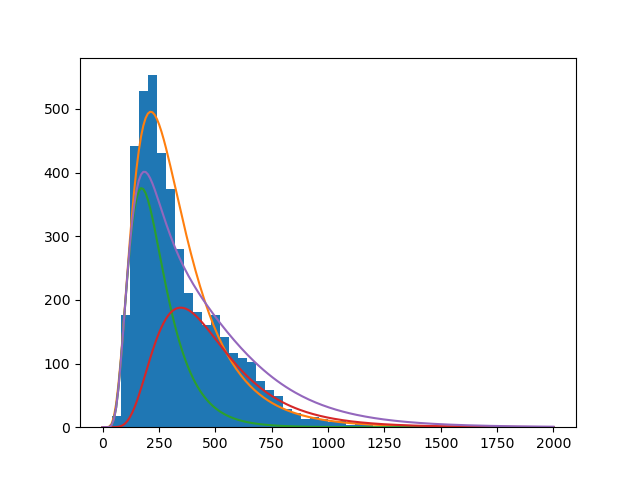

(0.9999999999970228, 0.5549930589115857, 2.1291870944840676, 0, 136.63992143028258)


In [369]:
test_data = sm_int_data_filtered[sm_int_data_filtered['frame']<=50]['mass']*conversion_factor
plotting_composition(test_data)

In [75]:
testmean = []
teststd = []
testlen = []
test2 = []
i = 1
for tracks in trc_data:
        tracks = tracks[tracks['frame']>=first_frame]
        for particle_num in np.unique(tracks['particle']):
            temp_particle_data = tracks[tracks['particle']==particle_num]
            if first_frame in np.array(temp_particle_data['frame']):
                
                test2.append(temp_particle_data[temp_particle_data['frame']==first_frame]['mass'])
                testmean.append(np.mean(temp_particle_data['mass']))
                teststd.append(np.std(temp_particle_data['mass']))
                testlen.append(max(np.array(temp_particle_data['frame']))-first_frame)
        i += 1
testmean = np.array(testmean)*conversion_factor
teststd = np.array(teststd)*conversion_factor
testlen = np.array(testlen)
test2 = np.array(test2)*conversion_factor

3

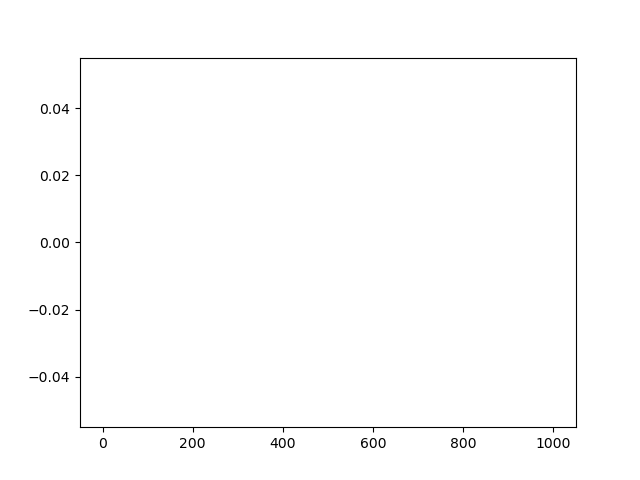

In [76]:
plt.close('all')
plt.hist(testmean, bins=100, range=(0, 1000))
3

3

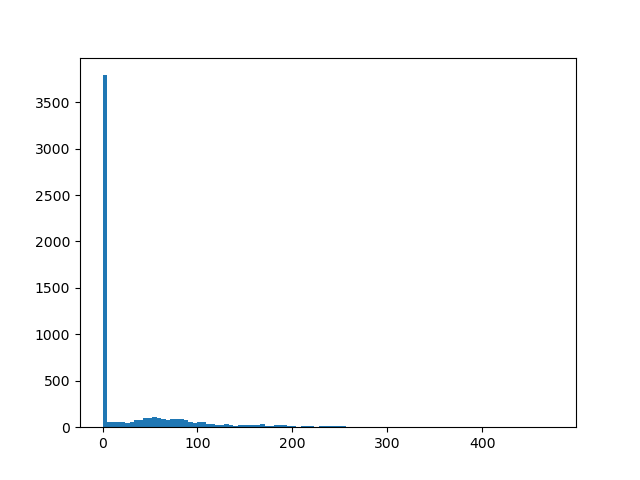

In [275]:
plt.close('all')
plt.hist(teststd, bins=100)
3

3

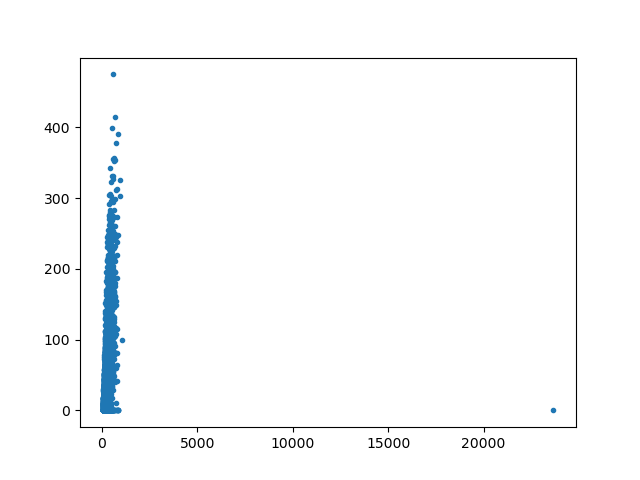

In [276]:
plt.close('all')
plt.scatter(testmean, teststd, marker='.')
3

3

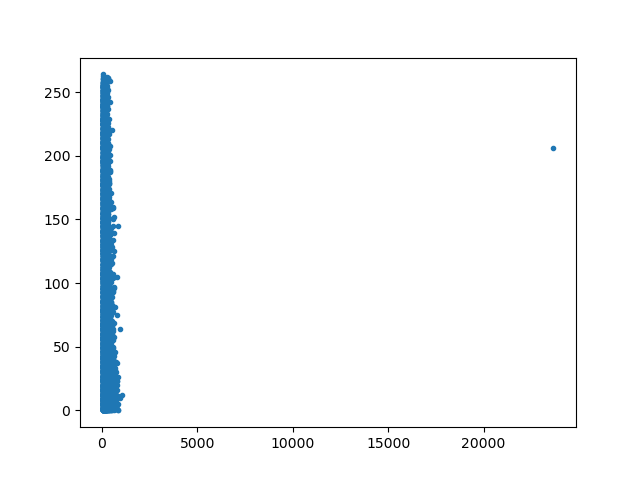

In [277]:
plt.close('all')
plt.scatter(testmean, testlen, marker='.')
3

In [57]:
"""
if sm_bool:
    if sm_roi == None:
        single_molecule_data = sm_int_data_filtered[sm_int_data_filtered['frame']>=sm_start_frame]
    else:
        roi_sm = roi.EllipseROI(roi_center, (sm_roi/px_size, sm_roi/px_size))
        single_molecule_data = get_sm_dist(sm_folder, start_frame=0, int_roi=roi_sm)
        single_molecule_data = single_molecule_data[single_molecule_data['frame']>=sm_start_frame]
else:
    if sm_roi == None:
        single_molecule_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']>=sm_start_frame]
    else:
        roi_sm = roi.EllipseROI(roi_center, (sm_roi/px_size, sm_roi/px_size))
        single_molecule_data = get_sm_dist(toccsl_folder, start_frame=0, int_roi=roi_sm)
        single_molecule_data = single_molecule_data[single_molecule_data['frame']>=sm_start_frame]

single_molecule_data = single_molecule_data[single_molecule_data['frame']<sm_start_frame+frames_taken]

print(f'{len(single_molecule_data)} data points available of single molecule brightness measurements')
"""

"\nif sm_bool:\n    if sm_roi == None:\n        single_molecule_data = sm_int_data_filtered[sm_int_data_filtered['frame']>=sm_start_frame]\n    else:\n        roi_sm = roi.EllipseROI(roi_center, (sm_roi/px_size, sm_roi/px_size))\n        single_molecule_data = get_sm_dist(sm_folder, start_frame=0, int_roi=roi_sm)\n        single_molecule_data = single_molecule_data[single_molecule_data['frame']>=sm_start_frame]\nelse:\n    if sm_roi == None:\n        single_molecule_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']>=sm_start_frame]\n    else:\n        roi_sm = roi.EllipseROI(roi_center, (sm_roi/px_size, sm_roi/px_size))\n        single_molecule_data = get_sm_dist(toccsl_folder, start_frame=0, int_roi=roi_sm)\n        single_molecule_data = single_molecule_data[single_molecule_data['frame']>=sm_start_frame]\n\nsingle_molecule_data = single_molecule_data[single_molecule_data['frame']<sm_start_frame+frames_taken]\n\nprint(f'{len(single_molecule_data)} data points available

In [141]:
def fit_survival_probability_test(survival_probability, first_frame, plotfigure=False, savepath=None):
    
    plot_lim = (survival_probability==0).argmax(axis=0)
    survival_probability = survival_probability[:plot_lim]
    
    lam_fit_func = lambda x, f, a, b: f*(-a/(b-(a+b)*np.exp(a*x))) + (1.0-f)*np.exp(-a*x)
    
    intensity_lam, intensity_lam_err = optimize.curve_fit(lam_fit_func, np.arange(len(survival_probability)), survival_probability, p0=(0.5, 0.1, 0.1), bounds=([0.0, 0.0, 0.0], [1.0, np.inf, np.inf]))
    
    if not plotfigure:
        return intensity_lam
    
    fig, ax = plt.subplots(constrained_layout=True)
    ax.plot(np.arange(len(survival_probability)), survival_probability, label='Data')
    ax.plot(np.arange(len(survival_probability)), lam_fit_func(np.arange(len(survival_probability)), *intensity_lam), label='Fit')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Survival Probability')
    ax.legend()
    
    if savepath != None:
        fig.savefig(savepath)
    
    return intensity_lam

[0.91409802 0.18418916 0.10181628]


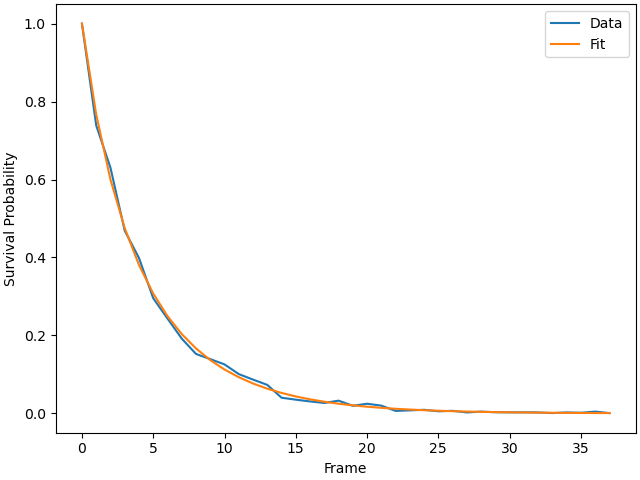

In [142]:
lam_fit = fit_survival_probability_test(survival_probability, first_frame, plotfigure=True)
print(lam_fit)

In [171]:
c2 = 0.005; c3 = 0.001
test_func_1 = lambda x: -(1.0-c2)/(c2-np.exp(c3*x))
test_func_2 = lambda x, f1, lam1, lam2: f1*np.exp(-lam1*x) + (1.0-f1)*np.exp(-lam2*x)
test_func_3 = lambda x, lam1: np.exp(-lam1*x)

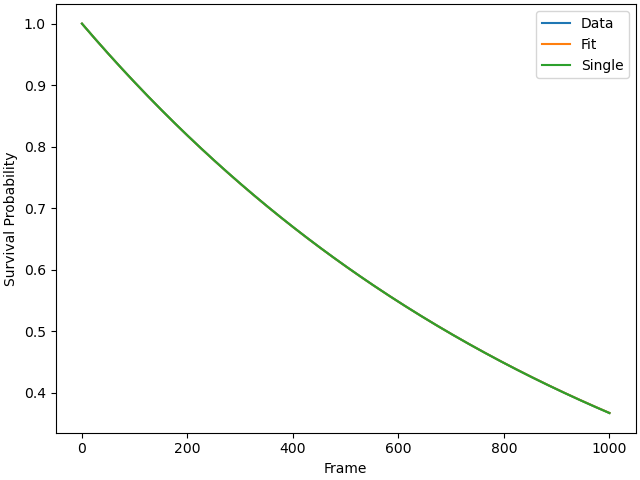

In [173]:
test_vals_x = np.linspace(0, 5000, 200)
test_vals_y = test_func_1(test_vals_x)
    
intensity_lam_test, intensity_lam_err_test = optimize.curve_fit(test_func_2, test_vals_x, test_vals_y, p0=(0.5, 0.1, 0.1), bounds=([0.0, 0.0, 0.0], [1.0, np.inf, np.inf]))
intensity_lam_test_single, intensity_lam_err_test_single = optimize.curve_fit(test_func_3, test_vals_x, test_vals_y, p0=(0.1), bounds=([0.0], [np.inf]))


fig, ax = plt.subplots(constrained_layout=True)
ax.plot(test_vals_x, test_vals_y, label='Data')
ax.plot(test_vals_x, test_func_2(test_vals_x, *intensity_lam_test), label='Fit')
ax.plot(test_vals_x, test_func_3(test_vals_x, *intensity_lam_test_single), label='Single')
ax.set_xlabel('Frame')
ax.set_ylabel('Survival Probability')
ax.legend()

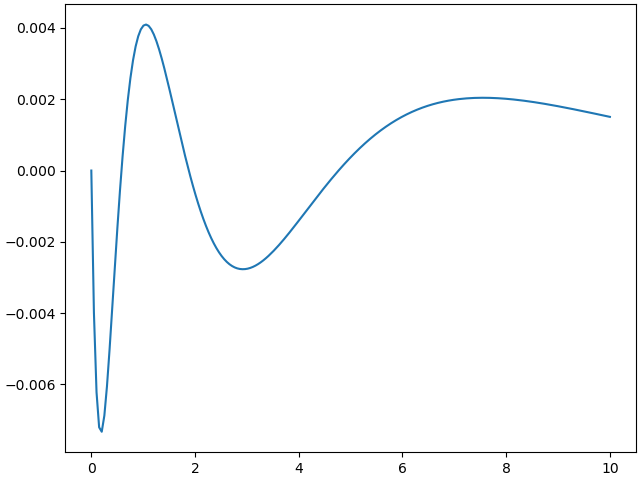

In [143]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(test_vals_x, test_vals_y-test_func_2(test_vals_x, *intensity_lam_test))

In [175]:
A = 0.96351694
lam1 = 0.0321503
lam2 = 0.00032425
test_func_1 = lambda x, a, b: -a/(b-(a+b)*np.exp(a*x))
#test_func_1 = lambda x, c2, c3: -(1.0-c2)/(c2-np.exp(c3*x))
test_func_2 = lambda x: A*np.exp(-lam1*x) + (1.0-A)*np.exp(-lam2*x)

[2.50643113e-11 6.62658033e-02]


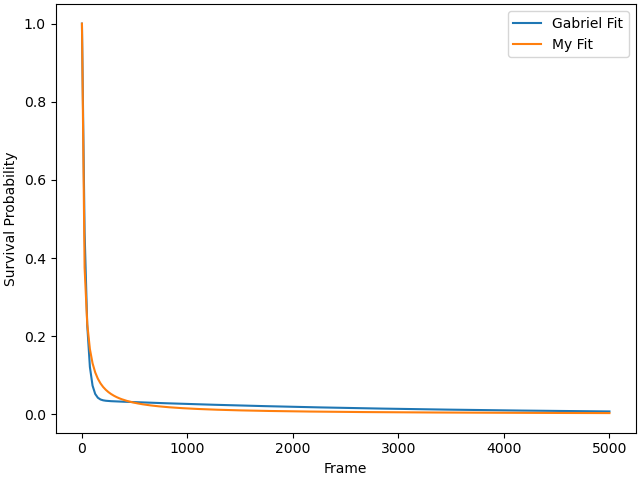

In [176]:
test_vals_x = np.linspace(0, 5000, 200)
test_vals_y = test_func_2(test_vals_x)
    
intensity_lam_test, intensity_lam_err_test = optimize.curve_fit(test_func_1, test_vals_x, test_vals_y, p0=(1e-10, 1e-3), bounds=([0.0, 0.0], [np.inf, np.inf]))

print(intensity_lam_test)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(test_vals_x, test_vals_y, label='Gabriel Fit')
ax.plot(test_vals_x, test_func_1(test_vals_x, *intensity_lam_test), label='My Fit')
ax.set_xlabel('Frame')
ax.set_ylabel('Survival Probability')
ax.legend()

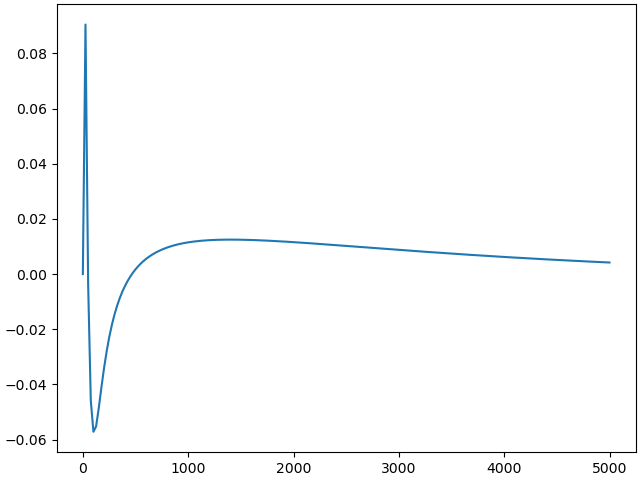

In [166]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(test_vals_x, test_vals_y-test_func_1(test_vals_x, *intensity_lam_test))

In [78]:
def plot_fraction_development(filtered_data, single_molecule_photons, starting_frame, iterations, lim=1000, lim_con=2, n_bootstrap=400, sigma_factor=None, savepath=None):
    # Variables needed: conversion_factor, single_molecule_data, lim, lim_con, sigma_factor
    alphas_MD = []
    errors_MD = []
    alphas_RA = []
    errors_RA = []
    for i in range(iterations):
        analysis_data = filtered_data[filtered_data['frame']==starting_frame+i]['mass']
        alphas, errors, fitted_pd = get_alphas(analysis_data, single_molecule_photons, lim=lim, lim_con=lim_con, n_bootstrap=n_bootstrap, sigma_factor=sigma_factor, donotplot=True)
        alphas_MD.append(alphas[0])
        errors_MD.append(errors[0])
        alphas_RA.append(alphas[1])
        errors_RA.append(errors[1])
    fig, ax = plt.subplots(constrained_layout=True)
    labels_MD = []
    labels_RA = []
    i = 1
    for alpha in alphas[0]:
        labels_MD.append(r'$\alpha_{}$ MD'.format(i))
        labels_RA.append(r'$\alpha_{}$ RA'.format(i))
        i += 1
    for i in range(len(alphas[0])):
        ax.errorbar(np.arange(iterations)+starting_frame+1, np.array(alphas_MD)[:,i]*100, yerr=np.array(errors_MD)[:,i]*100, marker='o', capsize=5, label=labels_MD[i])
        ax.errorbar(np.arange(iterations)+starting_frame+1, np.array(alphas_RA)[:,i]*100, yerr=np.array(errors_RA)[:,i]*100, marker='o', capsize=5, label=labels_RA[i])
    ax.set_xlabel('Frame')
    ax.set_ylabel('Fraction [%]')
    ax.legend()
    if savepath != None:
        fig.savefig(savepath)
    return [np.array(alphas_MD), np.array(alphas_RA)], [np.array(errors_MD), np.array(errors_RA)]

In [33]:
def pdf_dependence_rois(folder_sm, roi_center, roi_radii, conversion_factor=1.0, px_size=0.16, sigma_factor=1, sm_start_frame=0, lim=None, lim_con=2, savepath=None):
    
    monomer_pdfs = []
    number_signals = []
    
    for radius in roi_radii:
        axis = radius/px_size
        set_roi = roi.EllipseROI(roi_center, (axis, axis))
        single_molecule_data = get_sm_dist(folder_sm, start_frame=0, int_roi=set_roi)
        single_molecule_data = single_molecule_data[single_molecule_data['frame']>sm_start_frame]
        monomer_pdfs.append(generate_pdf(single_molecule_data['mass']*conversion_factor))
        number_signals.append(len(single_molecule_data['mass']))
    fig, ax = plt.subplots(constrained_layout=True)
    for  monomer_pdf, radius, number in zip(monomer_pdfs, roi_radii, number_signals):
        ax.plot(plot_vals, monomer_pdf(plot_vals), label=str(radius)+' $\mu$m (' + str(number) + ' signals)')
    ax.set_xlabel('Number of photons')
    ax.set_ylabel('PDF')
    if len(roi_radii) <= 15:
        ax.legend()
    else:
        ax.legend(fontsize=10*15/len(roi_radii))
    if savepath != None:
        fig.savefig(savepath)

In [34]:
def plot_fraction_rois(folder_analysis, folder_sm, frame, roi_center, roi_radii, sm_roi=None, conversion_factor=1.0, px_size=0.16, sigma_factor=1, sm_start_frame=0, lim=None, lim_con=2, savepath=None):
    alphas_MD = []
    errors_MD = []
    alphas_RA = []
    errors_RA = []
    number_sm = []
    if sm_roi != None:
        roi_sm = roi.EllipseROI(roi_center, (sm_roi/px_size, sm_roi/px_size))
    for radius in roi_radii:
        axis = radius/px_size
        set_roi = roi.EllipseROI(roi_center, (axis, axis))
        analysis_data = get_sm_dist(folder_analysis, start_frame=0, int_roi=set_roi)
        analysis_data = analysis_data[analysis_data['frame']==frame]['mass']
        if sm_roi == None:
            single_molecule_data = get_sm_dist(folder_sm, start_frame=0, int_roi=roi_sm)
            single_molecule_data = single_molecule_data[single_molecule_data['frame']>sm_start_frame]
        else:
            single_molecule_data = get_sm_dist(folder_sm, start_frame=0, int_roi=roi_sm)
            single_molecule_data = single_molecule_data[single_molecule_data['frame']>sm_start_frame]
        alphas, errors, fitted_pd = get_alphas(analysis_data*conversion_factor, single_molecule_data*conversion_factor, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, donotplot=True)
        number_sm.append(len(analysis_data))
        alphas_MD.append(alphas[0])
        errors_MD.append(errors[0])
        alphas_RA.append(alphas[1])
        errors_RA.append(errors[1])
    fig, ax = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)
    labels_MD = []
    labels_RA = []
    i = 1
    for alpha in alphas[0]:
        labels_MD.append(r'$\alpha_{}$ MD'.format(i))
        labels_RA.append(r'$\alpha_{}$ RA'.format(i))
        i += 1
    for i in range(len(alphas[0])):
        ax[0].errorbar(roi_radii, np.array(alphas_MD)[:,i]*100, yerr=np.array(errors_MD)[:,i]*100, marker='o', capsize=5, label=labels_MD[i])
        ax[0].errorbar(roi_radii, np.array(alphas_RA)[:,i]*100, yerr=np.array(errors_RA)[:,i]*100, marker='o', capsize=5, label=labels_RA[i])
    ax[0].set_xlabel('ROI [$\mu$m]')
    ax[0].set_ylabel('Fraction [%]')
    ax[0].legend()
    ax[1].plot(roi_radii, np.array(number_sm))
    ax[1].set_xlabel('ROI [$\mu$m]')
    ax[1].set_ylabel('Number of signals')
    if savepath != None:
        fig.savefig(savepath)
    return [np.array(alphas_MD), np.array(alphas_RA)], [np.array(errors_MD), np.array(errors_RA)]

In [ ]:
survival_probability = total_intensity[first_frame:]/total_intensity[first_frame]

def P_oligomer(n, p_scaling, order):
    result = (1.0-lam_fit_func(p_scaling*(n+1.0), *intensity_lam))**order - (1.0-lam_fit_func(p_scaling*n, *intensity_lam))**order
    return result

def Pm(n, p_scaling):
    result = (1.0-lam_fit_func(p_scaling*(n+1.0), *intensity_lam)) - (1.0-lam_fit_func(p_scaling*n, *intensity_lam))
    return result
    
    #prob = 1.0-(1.0-p)*p_scaling
    #return prob**n * (1.0-prob)
def Pd(n, p_scaling):
    result = (1.0-lam_fit_func(p_scaling*(n+1.0), *intensity_lam))**2 - (1.0-lam_fit_func(p_scaling*n, *intensity_lam))**2
    return result
    
    #prob = 1.0-(1.0-p)*p_scaling
    #return (1.0-prob**(n+1))**2 - (1.0-prob**n)**2
def Pd_general(n, p_scaling, p, p2):
    if isinstance(n, int):
        n = [n]    
    results = np.array([np.sum((1.0-(1.0-p2)*p_scaling[i])**np.arange(n[i]) * (1.0-p2)*p_scaling[i] * Pm(n[i]-1.0-np.arange(n[i]), p_scaling[i], p)) for i in range(len(n))])
    return results
def P(n, p_scaling, f):
    return f*Pm(n, p_scaling) + (1.0-f)*Pd(n, p_scaling)
def P_ignoring0(n, p_scaling, f):
    return np.sign(n)*P(n, p_scaling, f)/(1.0-P(np.zeros_like(n), p_scaling, f))
def P_model(n, f, ignore0=False):
    if isinstance(n, int):
        n = [n]
    if ignore0:
        results = [P_ignoring0(n_temp, 1.0, f) for n_temp in n]
    else:
        results = [P(n_temp, 1.0, f) for n_temp in n]
    return np.array(results)
    
    #result = [np.sum(P(n_temp, p_scaling, f)) for n_temp in n]
    #result = np.array(result)
    #result /= len(p_scaling)
    #return result

TypeError: 'numpy.float64' object cannot be interpreted as an integer

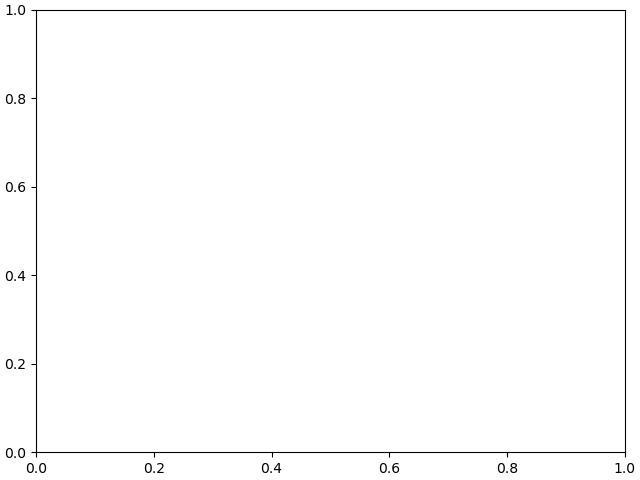

In [64]:
fig, ax = plt.subplots(constrained_layout=True)
test = np.zeros(max(track_lengths_corrected))
for i in range(max(track_lengths_corrected)):
    test[i] = len(track_lengths_corrected[track_lengths_corrected>=i])

ax.plot(np.arange(len(test)), test/test[0])

def test_f(x, f, lam):
    return f*np.exp(-lam*x) + (1.0-f)*(1.0-(1.0-np.exp(-lam*x))**2)

test_params, test_errors = curve_fit(test_f, np.arange(len(test)), test/test[0], p0=(0.01, 0.1), bounds=([0.0, 0.0], [1.0, np.inf]))

ax.plot(np.arange(len(test)), test_f(np.arange(len(test)), *test_params))
print(test_params)
print(test_errors)

In [ ]:
def Pm_old(n, p):
    return (p**n)*(1.0-p)
def Pm(n, p_scaling, p):
    return ((1.0-(1.0-p)*p_scaling)**n)*(1.0-p)*p_scaling
def Pd(n, p):
    return (p**n)*((1.0-p)*(p**n) + 2.0*(1.0-p**n))*(1.0-p)
def Pd_new(n, p):
    return (p**n)*((p/4)**n + 2.0*(1.0-(p/4)**n)/(1.0-p/4))*(1.0-p/2)*(1.0-p)
def Pd_general_old(n, p, p2):
    if isinstance(n, int):
        n = [n]
    results = np.array([np.sum(p2**np.arange(n[i]) * (1.0-p2) * Pm_old(n[i]-1.0-np.arange(n[i]), p)) for i in range(len(n))])
    return results
def Pd_general(n, p_scaling, p, p2):
    if isinstance(n, int):
        n = [n]
    results = np.array([np.sum((1.0-(1.0-p2)*p_scaling[i])**np.arange(n[i]) * (1.0-p2)*p_scaling[i] * Pm(n[i]-1.0-np.arange(n[i]), p_scaling[i], p)) for i in range(len(n))])
    return results
def P(n, p_scaling, f, p, p2):
    return f*Pm(n, p_scaling, p) + (1.0-f)*Pd_general(n, p_scaling, p, p2)
def P_old(n, f, p, p2):
    return f*Pm_old(n, p) + (1.0-f)*Pd_general_old(n, p, p2)
def P_ignoring0(n, f, p, p2):
    return np.sign(n)*P(n, f, p, p2)/(1.0-P(0, f, p, p2))
def dPdf(n, f, p):
    return Pm(n, p) - Pd(n, p)
def dPdp(n, f, p):
    return f*(n*(p**(n-1))*(1.0-p)-p**n) - (1.0-f)*(2.0*n*(1.0-p)*((1.0-(1.0-p)**2)**(n-1)) + 2.0*(1.0-p)*((1.0-(1.0-p)**2)**n))
def P_model(n, p_scaling, f, p, p2):
    result = np.zeros_like(n, dtype=float)
    for scale in p_scaling:
        result += P_old(n, f, 1.0-(1.0-p)*scale, 1.0-(1.0-p2)*scale)
    result /= len(p_scaling)
    return result

In [362]:
temp = 0
for i in range(10000):
    temp += P_model(i, probability_scaling, 0.0, 0.5, 0.5)
print(temp)

[0.00169492]


### **Bleaching Curve Analysis**

In [241]:
track_lengths_all = []

for tracks in trc_data:
    #tracks = tracks[tracks['frame']>sm_start_frame]
    last_frame = max(tracks['frame'])
    for particle_num in np.unique(tracks['particle']):
        temp_particle_data = tracks[tracks['particle']==particle_num]
        temp_particle_data_frames = np.array(temp_particle_data['frame'])
        if max(temp_particle_data_frames) < last_frame:
            track_lengths_all.append(max(temp_particle_data_frames)-min(temp_particle_data_frames))
len(track_lengths_all)

1253

In [270]:
track_lengths = []
track_lengths_corrected = []
track_masses = []
total_intensity = np.zeros(500)
total_intensity_uncorrected = np.zeros(500)
probability_scaling = []
masses_1length = []
number_1length = []

for tracks in trc_data:
    tracks = tracks[tracks['frame']>=first_frame]
    for particle_num in np.unique(tracks['particle']):
        
        temp_particle_data = tracks[tracks['particle']==particle_num]
        
        if first_frame in np.array(temp_particle_data['frame']):
            
            temp_particle_data_frames = np.array(temp_particle_data['frame'])
            track_lengths.append(max(temp_particle_data_frames)-first_frame)
            
            temp_positions = tuple([round(temp_particle_data['x']).astype(int), round(temp_particle_data['y']).astype(int)])
            temp_probability_scaling = np.mean(normalized_profile[temp_positions])
            probability_scaling.append(temp_probability_scaling)
            
            track_lengths_corrected.append((max(temp_particle_data_frames)-first_frame)*temp_probability_scaling)
            track_masses.append(temp_particle_data['mass'])
            
            corrected_frames = temp_probability_scaling*temp_particle_data_frames
            total_intensity[corrected_frames.astype(int)] += (1.0 + corrected_frames.astype(int) - corrected_frames)*temp_particle_data['mass']*temp_probability_scaling
            total_intensity[corrected_frames.astype(int)+1] += (corrected_frames - corrected_frames.astype(int))*temp_particle_data['mass']*temp_probability_scaling
            total_intensity_uncorrected[temp_particle_data_frames] += temp_particle_data['mass']
            
            if len(temp_particle_data_frames)==1:
                masses_1length.append(temp_particle_data['mass'])

In [271]:
np.std(probability_scaling)

0.14177644

In [272]:
#masses_1length = np.array(masses_1length).reshape(-1)
#fig, ax = plt.subplots(constrained_layout=True)
#ax.hist(masses_1length*conversion_factor, bins=100, range=(0, 300))
#ax.set_xlabel('Number of Photons')

In [273]:
track_lengths = (np.array(track_lengths).reshape(-1)).astype(float)
probability_scaling = np.array(probability_scaling)
track_lengths_corrected = track_lengths*probability_scaling

# This line is for cutting off outliers
track_length_cutoff = 1000
track_lengths = track_lengths[track_lengths<track_length_cutoff]; probability_scaling = probability_scaling[track_lengths<track_length_cutoff] # This line is for cutting off outliers

print('There are', len(track_lengths), 'data points')

There are 444 data points


In [274]:
track_lengths_no0 = track_lengths[track_lengths!=0]

probability_scaling_no0 = probability_scaling[track_lengths!=0]

print('There are', len(track_lengths_no0), 'tracks with length larger than 1')

There are 414 tracks with length larger than 1


array([0.32508362, 0.4550286 , 0.09369913])

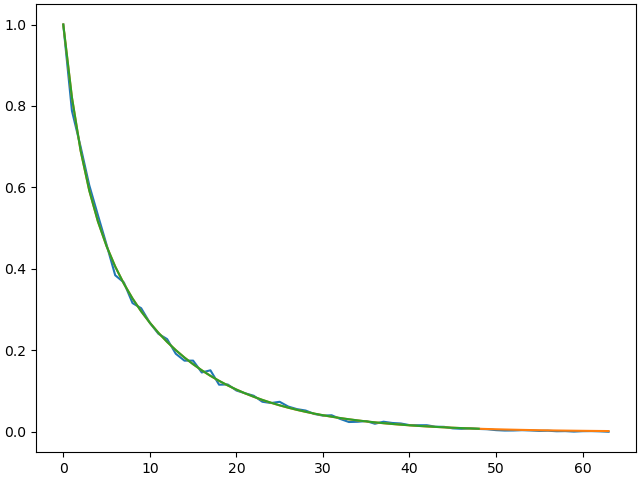

In [278]:
fig, ax = plt.subplots(constrained_layout=True)
plot_lim = (total_intensity==0).argmax(axis=0)
total_intensity = total_intensity

lam_fit_func = lambda x, f1, lam1, lam2: f1*np.exp(-lam1*x) + (1.0-f1)*np.exp(-lam2*x)
dlamfitdx = lambda x, f1, lam1, lam2: lam1*f1*np.exp(-lam1*x) + lam2*(1.0-f1)*np.exp(-lam2*x)
intensity_lam, intensity_lam_err = curve_fit(lam_fit_func, np.arange(len(total_intensity[first_frame:plot_lim])), total_intensity[first_frame:plot_lim]/total_intensity[first_frame], p0=(0.9, 0.8, 0.5), bounds=([0.0, 0.0, 0.0], [1.0, np.inf, np.inf]))

ax.plot(np.arange(len(total_intensity[first_frame:plot_lim])), total_intensity[first_frame:plot_lim]/total_intensity[first_frame])
ax.plot(np.arange(len(total_intensity[first_frame:plot_lim])), lam_fit_func(np.arange(len(total_intensity[first_frame:plot_lim])), *intensity_lam))
ax.plot(test_x, test_y)
intensity_lam

In [248]:

test_x = np.arange(len(total_intensity[first_frame:plot_lim])); test_y = lam_fit_func(np.arange(len(total_intensity[first_frame:plot_lim])), *intensity_lam)

In [254]:
survival_probability = total_intensity[first_frame:]/total_intensity[first_frame]

def P_oligomer(n, p_scaling, order):
    result = (1.0-lam_fit_func(p_scaling*(n+1.0), *intensity_lam))**order - (1.0-lam_fit_func(p_scaling*n, *intensity_lam))**order
    return result

def P(n, p_scaling, lim_con, alphas):
    result = 0.0
    for i in range(lim_con-1):
        result += alphas[i]*P_oligomer(n, p_scaling, i+1)
    result += (1.0-np.sum(alphas))*P_oligomer(n, p_scaling, lim_con)
    return result

def P_ignoring0(n, p_scaling, lim_con, alphas):
    return np.sign(n)*P(n, p_scaling, lim_con, alphas)/(1.0-P(np.zeros_like(n), p_scaling, lim_con, alphas))

def P_model(n, lim_con, alphas, ignore0=False):
    if isinstance(n, int):
        n = [n]
    if ignore0:
        results = [P_ignoring0(n_temp, 1.0, lim_con, alphas) for n_temp in n]
    else:
        results = [P(n_temp, 1.0, lim_con, alphas) for n_temp in n]
    return np.array(results)

Optimization Success after 0.016138553619384766 s


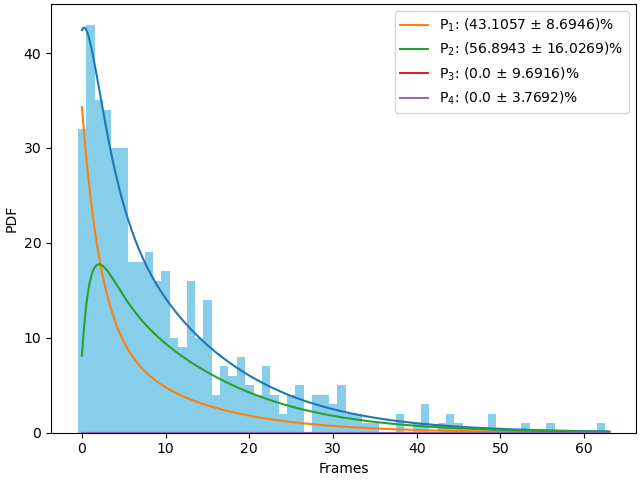

In [291]:
likelihood_estimator = lambda x: -1.0*np.sum(np.log(P(track_lengths, probability_scaling, lim_con, x)+1e-25))
likelihood_estimator_no0 = lambda x: -1.0*np.sum(np.log(P_ignoring0(track_lengths_no0, probability_scaling_no0, lim_con, x)+1e-25))

cons=({'type': 'ineq',
    'fun': lambda x: 1.0-np.sum(x)})

# Performing the fit
start = time.time()
res = optimize.minimize(likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), [1]*(lim_con-1))), constraints=cons)
end = time.time()
if res.success:
    print('Optimization Success after', end-start, 's')
else:
    print('Optimization Failure after', end-start, 's')
fit = res.x

alphas = np.zeros(lim_con)
alphas[:-1]=fit; alphas[-1]=np.abs(1.0-np.sum(fit))*(np.sum(fit)<1)



results_bootstrap = []
for i in range(n_bootstrap):
    idx_sample = np.random.choice(np.arange(len(track_lengths)), size=len(track_lengths))
    sample_tracks = track_lengths[idx_sample]
    sample_pscaling = probability_scaling[idx_sample]
    temp_likelihood_estimator = lambda x: -1.0*np.sum(np.log(P(sample_tracks, sample_pscaling, lim_con, x)+1e-25))
    temp = optimize.minimize(temp_likelihood_estimator, np.ones(lim_con-1)/lim_con, bounds=tuple(zip([0]*(lim_con-1), [1]*(lim_con-1))), constraints=cons)
    temp_fit = temp.x
    temp_res = np.zeros(lim_con)
    temp_res[:-1]=temp_fit; temp_res[-1]=1.0-np.sum(temp_fit)
    results_bootstrap.append(temp_res)
results_bootstrap = np.array(results_bootstrap)
errors = np.zeros_like(results)
for i in range(len(errors)):
    errors[i] = np.std(results_bootstrap[:,i])

text = []
for n in range(lim_con):
    text.append(r'P$_{}$'.format(n+1) + ': ({}'.format(round(alphas[n]*100,4)) + ' $\pm$ {})%'.format(round(errors[n]*100,4)))

fig, ax = plt.subplots(constrained_layout=True)
bin_num = int(max(track_lengths*probability_scaling)+1)
plot_positions = np.linspace(0, bin_num, 500)
ax.hist(track_lengths*probability_scaling, bins=bin_num, range=(-0.5, bin_num-0.5), color='skyblue')
ax.plot(plot_positions, len(track_lengths)*P_model(plot_positions, lim_con, fit, ignore0=False))
for alpha, t, i in zip(alphas, text, np.arange(lim_con)):
    ax.plot(plot_positions, alpha*len(track_lengths)*P_oligomer(plot_positions, 1.0, i+1), label=t)
    ax.legend()
    ax.set_xlabel('Frames')
    ax.set_ylabel('PDF')
    
if savepath != None:
    fig.savefig(savepath)

In [226]:
print(res)
print(f'We have {alphas[0]*100}% Monomers and {(alphas[1])*100}% Dimers')
print(f'The rest of the values are {alphas[2:]}')
print(errors)

     fun: 1556.6559842803003
     jac: array([-0.74671936, -0.74111938, -0.67141724])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.47892187, 0.52107813, 0.        ])
We have 47.892187297730025% Monomers and 52.10781270227004% Dimers
The rest of the values are [0. 0.]
[0.08180412 0.12674797 0.0604137  0.03488754]


In [227]:
excel_path = results_path.format(f'TrackLength{analysis_id}_analysisROI{roi_analysis}.xlsx')
fit_res = pd.DataFrame(data={'Fit Results': results,'Fit Errors': errors})
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()
writer.close()

C:\Users\mrdxy\anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


TypeError: P() missing 1 required positional argument: 'alphas'

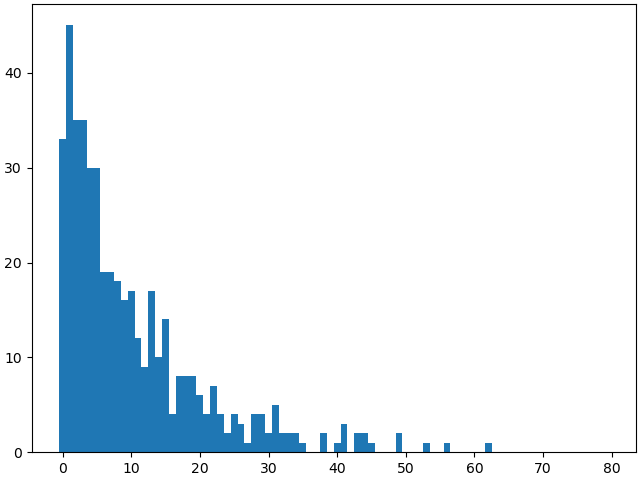

In [130]:
savepath = excel_path[:-4] + 'png'
fig, ax = plt.subplots(constrained_layout=True)
bin_num = 80
bin_positions = np.arange(0, bin_num)
ax.hist(track_lengths_corrected, bins=bin_num, range=(-0.5, bin_num-0.5))
ax.plot(bin_positions, len(track_lengths)*P_model(bin_positions, fit, ignore0=False))
#ax.plot(bin_positions, len(track_lengths)*P_old(bin_positions, *fit))
fig.savefig(savepath)

In [51]:
"""
likelihood_estimator_no0 = lambda x: -1.0*np.sum(np.log(P_ignoring0(track_lengths_all, x[0], x[1], x[2])+1e-25))
# Performing the fit
start = time.time()
res = optimize.minimize(likelihood_estimator_no0, (0.5, 0.5, 0.5), bounds=((0.0, 1.0), (0.0, 1.0), (0.0, 1.0)))
end = time.time()
if res.success:
    print('Optimization Success after', end-start, 's')
else:
    print('Optimization Failure after', end-start, 's')
fit = res.x
results_all = np.zeros(4)
results_all[0]=fit[0]; results_all[1]=1.0-fit[0]; results_all[2]=fit[1]; results_all[3]=fit[2]

print(f'We have {results_all[0]*100}% Monomers and {(results_all[1])*100}% Dimers')
print(f'Monomer survival probability per step is {results_all[2]}')
print(f'Dimer survival probability per step is {results_all[3]}')
"""

"\nlikelihood_estimator_no0 = lambda x: -1.0*np.sum(np.log(P_ignoring0(track_lengths_all, x[0], x[1], x[2])+1e-25))\n# Performing the fit\nstart = time.time()\nres = optimize.minimize(likelihood_estimator_no0, (0.5, 0.5, 0.5), bounds=((0.0, 1.0), (0.0, 1.0), (0.0, 1.0)))\nend = time.time()\nif res.success:\n    print('Optimization Success after', end-start, 's')\nelse:\n    print('Optimization Failure after', end-start, 's')\nfit = res.x\nresults_all = np.zeros(4)\nresults_all[0]=fit[0]; results_all[1]=1.0-fit[0]; results_all[2]=fit[1]; results_all[3]=fit[2]\n\nprint(f'We have {results_all[0]*100}% Monomers and {(results_all[1])*100}% Dimers')\nprint(f'Monomer survival probability per step is {results_all[2]}')\nprint(f'Dimer survival probability per step is {results_all[3]}')\n"

In [52]:
excel_path = results_path.format(f'TrackLength{analysis_id}_all_analysisROI{roi_analysis}.xlsx')
fit_res = pd.DataFrame(data={'Fit Results': results,'Fit Errors': errors})
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()
writer.close()

NameError: name 'results' is not defined

TypeError: P() missing 1 required positional argument: 'p2'

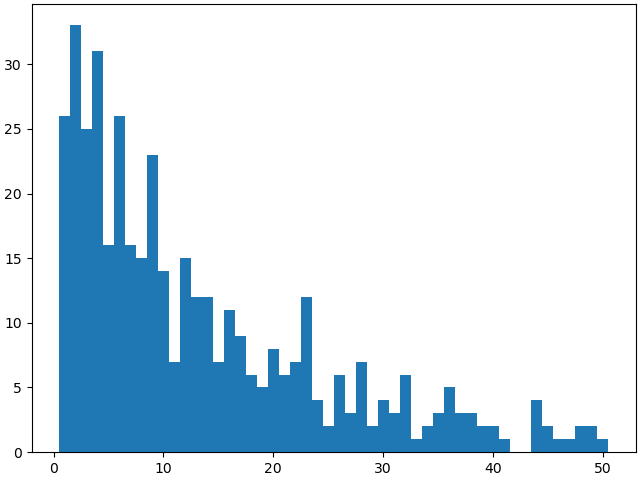

In [518]:
savepath = excel_path[:-4] + 'png'
fig, ax = plt.subplots(constrained_layout=True)
bin_num = 50
bin_positions = np.arange(1, bin_num+1)
ax.hist(track_lengths_no0, bins=bin_num, range=(0.5, bin_num+0.5))
ax.plot(bin_positions, len(track_lengths_no0)*P_ignoring0(bin_positions, *fit))
fig.savefig(savepath)

In [ ]:
def Pm_old(n, p):
    return (p**n)*(1.0-p)
def Pm(p_scaling, p):
    results = []
    for p_scaling_temp in p_scaling:
        p_scaling_temp = np.array(p_scaling_temp)
        results.append(np.prod(1.0-p_scaling_temp[:-1]*(1.0-p))*(1.0-p)*p_scaling_temp[-1])
    results = np.array(results)
    return results
def Pd(n, p):
    return (p**n)*((1.0-p)*(p**n) + 2.0*(1.0-p**n))*(1.0-p)
def Pd_new(n, p):
    return (p**n)*((p/4)**n + 2.0*(1.0-(p/4)**n)/(1.0-p/4))*(1.0-p/2)*(1.0-p)
def Pd_general_old(n, p, p2):
    if isinstance(n, int):
        n = [n]
    results = np.array([np.sum(p2**np.arange(n[i]) * (1.0-p2) * Pm_old(n[i]-1.0-np.arange(n[i]), p)) for i in range(len(n))])
    return results
def Pd_general(p_scaling, p, p2):
    results = []
    for p_scaling_temp in p_scaling:
        p_scaling_temp = np.array(p_scaling_temp)
        temp_value = 0
        for i in range(len(p_scaling_temp)-1):
            temp_value += np.prod(1.0-p_scaling_temp[:i]*(1.0-p2))*(1.0-p2)*p_scaling_temp[i] * np.prod(1.0-p_scaling_temp[i+1:-1]*(1.0-p))*(1.0-p)*p_scaling_temp[-1]
        results.append(temp_value)
    results = np.array(results)
    return results
def P(p_scaling, f, p, p2):
    return f*Pm(p_scaling, p) + (1.0-f)*Pd_general(p_scaling, p, p2)
def P_old(n, f, p, p2):
    return f*Pm_old(n, p) + (1.0-f)*Pd_general_old(n, p, p2)
def P_ignoring0(n, f, p, p2):
    return np.sign(n)*P(n, f, p, p2)/(1.0-P(0, f, p, p2))
def dPdf(n, f, p):
    return Pm(n, p) - Pd(n, p)
def dPdp(n, f, p):
    return f*(n*(p**(n-1))*(1.0-p)-p**n) - (1.0-f)*(2.0*n*(1.0-p)*((1.0-(1.0-p)**2)**(n-1)) + 2.0*(1.0-p)*((1.0-(1.0-p)**2)**n))
def P_model(n, p_scaling, f, p, p2):
    result = np.zeros_like(n, dtype=float)
    for p_scaling_temp in p_scaling:
        scale = np.mean(p_scaling_temp)
        result += P_old(n, f, 1.0-(1.0-p)*scale, 1.0-(1.0-p2)*scale)
    result /= len(p_scaling)
    return result

#### **Calculate mean densities in first recovery frame**

In [16]:
levels = np.linspace(0.55,0.99,100)
rois = [make_ROI(fit_rel, chosen_value=v,fig_show=False)[0] for v in levels]
areas = [r.area*(px_size**2) for r in rois]
group_num = len(groups)

gr_recdensities = {}
i=0
for f in groups_dicts.values():
    f = [data_path.format(f'TOCCSL\\{corr_folder}\\')+ff[:-3]+'h5' for ff in f.keys()]
    grouped_recdensity = evaluate_density(f, rois, areas, rec_frame)
    gr_recdensities['g{}'.format(i+1)] = grouped_recdensity
    i += 1

Files:   0%|          | 0/51 [00:00<?, ?it/s]

#### **Widget for choosing ROI**

In [19]:
step = 0.001
FR_bound = get_FR_bounds(gr_recdensities, R_coloc)
FR_slider = create_slider_FR(step, FR_bound)

def update_roi(change):
    '''
    Updates critical density and optimal roi overview figure
    '''
    global gr_recdensities
    for ax, key, density in zip(fig_dens.axes, gr_recdensities.keys(), gr_recdensities.values()):
        ax.clear()
        ax.plot(levels, density, '-b', label = 'recovery density')
        ax.vlines(x=opt_roi(critical_density(FR_slider.value,R_coloc), density, levels), ymin=min(density), ymax=max(density), color='r', label='optimal ROI')
        ax.hlines(y=critical_density(FR_slider.value,R_coloc), xmin=min(levels), xmax=max(levels), color='y', label='critical density')
        if len(gr_recdensities.keys()) > 1:
            ax.set_title(key, weight='bold')
        ax.set_xlabel('ROI level')
        ax.set_ylabel('Density [molecules/$(\mu m)^2$]')
        ax.legend()
    fig_dens.canvas.draw()

def create_button_roi(gr_recdensities):
    '''
    Creates button, which is used to indicate choosing density is done.
    Upon pressing button:
        a) the global variable dens_pos is fixed
        b) the density overview figure is saved as 'TOCCSL_critical_density.png'
        c) the set density and ROI are saved as 'optimal_roi.xlsx'
    Returns:
        button_s: Button ipywidget object
        output_s: Output reads the set density and according roi-level
    '''
    button_s = widgets.Button(description="Set!",button_style='info') # 'info', 'warning')
    output_s = widgets.Output()

    def on_button_clicked(b):
        with output_s:
            global roi_pos
            global set_roi
            dens_pos = critical_density(FR_slider.value, R_coloc)
            roi_pos = []
            set_roi = []
            for ax, key, density in zip(fig_dens.axes, gr_recdensities.keys(), gr_recdensities.values()):
                temp = opt_roi(dens_pos, density, levels)
                roi_pos.append(temp)
                set_roi.append(make_ROI(fit_rel, chosen_value=temp,fig_show=False)[0])
                if len(gr_recdensities.keys()) > 1:
                    ax.set_title(key + ': ROI level {}'.format(round(temp,4)), weight='bold')
                else:
                    ax.set_title('ROI level {}'.format(round(temp,4)), weight='bold')
            fig_dens.suptitle('Critical density: {}'.format(round(dens_pos,4)) + ' molecules/$\mathbf{(\mu m)^2}$', weight='bold')
            fig_dens.canvas.draw()
            print('Critical density: {}'.format(dens_pos) + ' molecules/$(\mu m)^2$')
            #print('Resulting ROI: {}'.format(roi_pos))
            
            fig_dens.savefig(results_path.format('TOCCSL_critical_density.png'))
            if len(gr_recdensities.keys()) > 1:
                filter_val = pd.DataFrame(data={'Group': list(gr_recdensities.keys()), 'False positive rate': [FR_slider.value]*len(roi_pos), 'critical density [molecules/(µm)^2]': [dens_pos]*len(roi_pos),'ROI': roi_pos}
                                          )
            else:
                filter_val = pd.DataFrame(data={'False positive rate': [FR_slider.value]*len(roi_pos), 'critical density [molecules/(µm)^2]': [dens_pos]*len(roi_pos),'ROI': roi_pos}
                                      )
            writer = pd.ExcelWriter(results_path.format('optimal_roi.xlsx')) 
            filter_val.to_excel(writer, sheet_name='Optimal ROI')

            df = filter_val
            for column in df:
                column_width = max(df[column].astype(str).map(len).max(), len(column))
                col_idx = df.columns.get_loc(column)
                writer.sheets['Optimal ROI'].set_column(col_idx+1, col_idx+1, column_width)

            writer.save()

    button_s.on_click(on_button_clicked)
    
    return button_s, output_s

FR_slider.observe(update_roi, 'value');
button_roi,output_roi = create_button_roi(gr_recdensities)

display(FR_slider,button_roi,output_roi )     

if group_num == 1:
    fig_dens, ax_dens = plt.subplots(figsize=(7,4), constrained_layout=True)
else:
    fig_dens, ax_dens = plt.subplots(int(np.ceil(group_num/2)),2,figsize=(15,4*np.ceil(group_num/2)), sharex=True, sharey=True, constrained_layout=True)
c = 0
for key, density, ax in zip(gr_recdensities.keys(), gr_recdensities.values(), fig_dens.axes):
    if c < group_num:
        ax.plot(levels, density, '-b', label = 'recovery density')
        ax.vlines(x=opt_roi(critical_density(FR_slider.value, R_coloc), density, levels), ymin=min(density), ymax=max(density), color='r', label='optimal ROI')
        ax.hlines(y=critical_density(FR_slider.value, R_coloc), xmin=min(levels), xmax=max(levels), color='y', label='critical density')
        if group_num > 1:
            ax.set_title(key, weight='bold')
        ax.set_xlabel('ROI level')
        ax.set_ylabel('Density [molecules/$(\mu m)^2$]')
        ax.legend()
        c += 1
    else:
        fig.delaxes(ax)
        c += 1

NameError: name 'gr_recdensities' is not defined

### **setting parameters**

In [669]:
##### set frame number of first recovery image
rec_frame = 5
##### set maximum false positive rate
#FR_max = 0.09
##### set assumed colocalistaion radius in µm
#R_coloc = 0.5
##### set camera pixel size
px_size = 0.16 #µm

In [693]:
min_roi_r = 3.0
max_roi_r = 9.0
roi_r_step = 0.25
levels = np.linspace(min_roi_r, max_roi_r, int((max_roi_r-min_roi_r)/roi_r_step + 1))
rois_to_evaluate = np.linspace(min_roi_r-roi_r_step, max_roi_r+roi_r_step, int((max_roi_r-min_roi_r)/roi_r_step + 3))
density = np.zeros(len(levels))
mean_densities = []

rois = [roi.EllipseROI((x_center, y_center), (r/px_size, r/px_size)) for r in rois_to_evaluate]

areas = [r.area*(px_size**2) for r in rois]
radii_circ = [np.sqrt(a/np.pi) for a in areas]

f = getfiles(folder=data_path.format(f'TOCCSL\{corr_folder}'), extension='h5')
roi_folder=data_path.format(f'TOCCSL\{corr_folder}')
num_file = len(f)

In [694]:
"""
levels = np.linspace(0.7,0.99,100)
density = np.zeros(len(levels))
mean_densities = []

rois = [make_ROI(fit_rel, chosen_value=v,fig_show=False)[0] for v in levels]

areas = [r.area*(px_size**2) for r in rois]
radii_circ = [np.sqrt(a/np.pi) for a in areas]

f = getfiles(folder=data_path.format(f'TOCCSL\{corr_folder}'), extension='h5')
roi_folder=data_path.format(f'TOCCSL\{corr_folder}')
num_file = len(f)
"""

"\nlevels = np.linspace(0.7,0.99,100)\ndensity = np.zeros(len(levels))\nmean_densities = []\n\nrois = [make_ROI(fit_rel, chosen_value=v,fig_show=False)[0] for v in levels]\n\nareas = [r.area*(px_size**2) for r in rois]\nradii_circ = [np.sqrt(a/np.pi) for a in areas]\n\nf = getfiles(folder=data_path.format(f'TOCCSL\\{corr_folder}'), extension='h5')\nroi_folder=data_path.format(f'TOCCSL\\{corr_folder}')\nnum_file = len(f)\n"

#### **Calculating mean densities for each ROI level**

In [695]:
"""
######## calculating mean densities for each ROI level
#looping through all files
for ff,i in zip(tqdm(f, desc='Files'),range(num_file)):
    cur = io.load(ff)
    
    #looping through all levels/ rois
    for rr, area, j in zip(rois, areas, range(len(levels))):
        cur_sel = rr(cur)
        molecule_num = len(cur_sel[cur_sel['frame'] == rec_frame])        
        density[j] += molecule_num/area
        
    if (i % 5) == 0 and i!= 0:
        mean_densities.append(density/i)
density = density/num_file
"""

"\n######## calculating mean densities for each ROI level\n#looping through all files\nfor ff,i in zip(tqdm(f, desc='Files'),range(num_file)):\n    cur = io.load(ff)\n    \n    #looping through all levels/ rois\n    for rr, area, j in zip(rois, areas, range(len(levels))):\n        cur_sel = rr(cur)\n        molecule_num = len(cur_sel[cur_sel['frame'] == rec_frame])        \n        density[j] += molecule_num/area\n        \n    if (i % 5) == 0 and i!= 0:\n        mean_densities.append(density/i)\ndensity = density/num_file\n"

In [1]:
######## calculating mean densities for each ROI level
#looping through all files
for ff,i in zip(tqdm(f, desc='Files'),range(num_file)):
    cur = io.load(ff)
    
    #looping through all levels/ rois
    for j in range(1, len(rois_to_evaluate)-1):
        cur_sel_prev = rois[j-1](cur)
        cur_sel_next = rois[j+1](cur)
        molecule_num = len(cur_sel_next[cur_sel_next['frame'] == rec_frame]) - len(cur_sel_prev[cur_sel_prev['frame'] == rec_frame])
        print(molecule_num)
        density[j-1] += molecule_num/(areas[j+1]-areas[j-1])
        
    if (i % 5) == 0 and i!= 0:
        mean_densities.append(density/i)
density = density/num_file

NameError: name 'tqdm' is not defined

In [697]:
density

array([0.11234467, 0.12866825, 0.14800964, 0.15145725, 0.1575946 ,
       0.20559808, 0.24133299, 0.26279454, 0.30457887, 0.33762841,
       0.34838194, 0.37556767, 0.43273501, 0.48632758, 0.52139447,
       0.54276806, 0.55280709, 0.56817992, 0.58752099, 0.61447297,
       0.57264573, 0.51973593, 0.46039285, 0.38375511, 0.34743628])

### **creating slider to set optimal ROI**

#### **Setting up**

In [698]:
def update_roi(change):
    '''
    Updates critical density and optimal roi overview figure
    '''
    global density
    ax_dens.clear()
    ax_dens.vlines(x=opt_roi(density_slider.value, density, levels), ymin=min(density), ymax=max(density), color='r', label='optimal ROI')
    ax_dens.hlines(y=density_slider.value, xmin=min(levels), xmax=max(levels), color='y', label='critical density')
    ax_dens.plot(levels, density, '-b', label = 'density')
    ax_dens.set_title('Densities')
    ax_dens.set_xlabel('ROI level')
    ax_dens.set_ylabel('Density [molecules/$(\mu m)^2$]')
    ax_dens.legend()
    fig_dens.canvas.draw()

def create_button_roi(density):
    '''
    Creates button, which is used to indicate choosing density is done.
    Upon pressing button:
        a) the global variable dens_pos is fixed
        b) the density overview figure is saved as 'TOCCSL_critical_density.png'
        c) the set density and ROI are saved as 'optimal_roi.xlsx'
    Returns:
        button_s: Button ipywidget object
        output_s: Output reads the set density and according roi-level
    '''
    button_s = widgets.Button(description="Set!",button_style='info') # 'info', 'warning')
    output_s = widgets.Output()

    def on_button_clicked(b):
        with output_s:
            global roi_pos
            dens_pos = density_slider.value
            roi_pos = opt_roi(dens_pos, density, levels)

            print('Density: {}'.format(dens_pos))    #round(dens_pos,4)
            print('Resulting ROI: {}'.format(roi_pos))
            
            fig_dens.savefig(results_path.format('TOCCSL_critical_density.png'))
            filter_val = pd.DataFrame(data={'Density': dens_pos,'ROI': roi_pos},index = ['Set to: '])
            writer = pd.ExcelWriter(results_path.format('optimal_roi.xlsx')) 
            filter_val.to_excel(writer, sheet_name='Optimal ROI')

            df = filter_val
            for column in df:
                column_width = max(df[column].astype(str).map(len).max(), len(column))
                col_idx = df.columns.get_loc(column)
                writer.sheets['Optimal ROI'].set_column(col_idx+1, col_idx+1, column_width)

            writer.save()

    button_s.on_click(on_button_clicked)
    
    return button_s, output_s


step = 0.001
density_slider = create_slider_dens(step, density)

density_slider.observe(update_roi, 'value');

button_roi,output_roi = create_button_roi(density)  

#### **widget**

FloatSlider(value=0.11234466571192608, description='Critical den:', max=0.6144729744673799, min=0.112344665711…

Button(button_style='info', description='Set!', style=ButtonStyle())

Output()

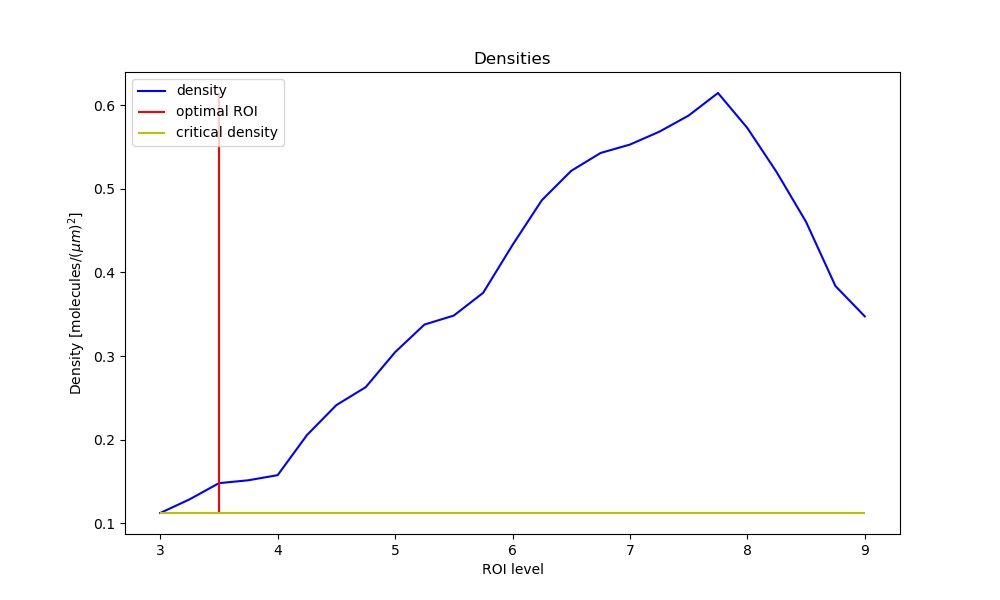

In [699]:
display(density_slider, button_roi,output_roi)     

fig_dens, ax_dens = plt.subplots(figsize=(10,6))

ax_dens.plot(levels, density, '-b', label = 'density')
ax_dens.vlines(x=opt_roi(density_slider.value, density, levels), ymin=min(density), ymax=max(density), color='r', label='optimal ROI')
ax_dens.hlines(y=density_slider.value, xmin=min(levels), xmax=max(levels), color='y', label='critical density')
ax_dens.set_title('Densities')
ax_dens.set_xlabel('ROI level')
ax_dens.set_ylabel('Density [molecules/$(\mu m)^2$]')
ax_dens.legend()

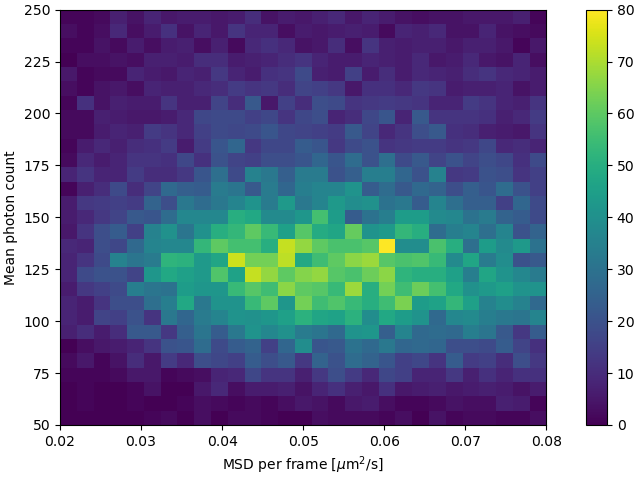

In [143]:
fig, ax = plt.subplots(constrained_layout=True)
bins_x=30; bins_y=30; lim_low_x=0.02; lim_high_x=0.08; lim_low_y=50; lim_high_y=250
bins_2d = [np.linspace(lim_low_x, lim_high_x, bins_x), np.linspace(lim_low_y, lim_high_y, bins_y)]
hist_2d = ax.hist2d(msd_steps, meanbright_steps, bins=bins_2d)
ax.set_xlabel('MSD per frame [$\mu$m$^2$/s]')
ax.set_ylabel('Mean photon count')
fig.colorbar(hist_2d[3], ax=ax)

Text(0, 0.5, 'Mean photon count')

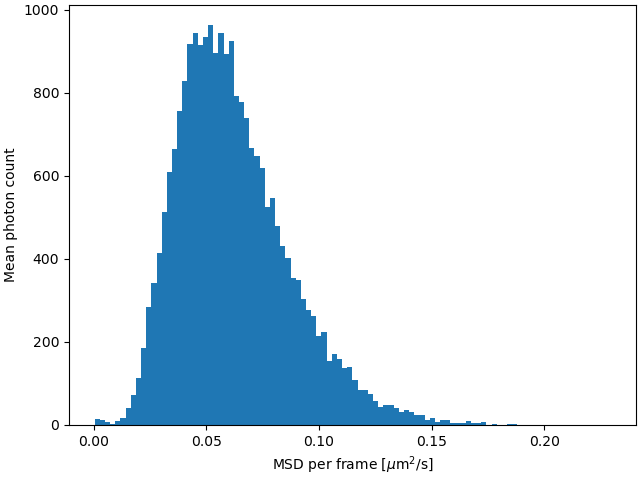

In [144]:
fig, ax = plt.subplots(constrained_layout=True)
ax.hist(msd_steps, bins=100)
ax.set_xlabel('MSD per frame [$\mu$m$^2$/s]')
ax.set_ylabel('Mean photon count')

There are 2 clusters


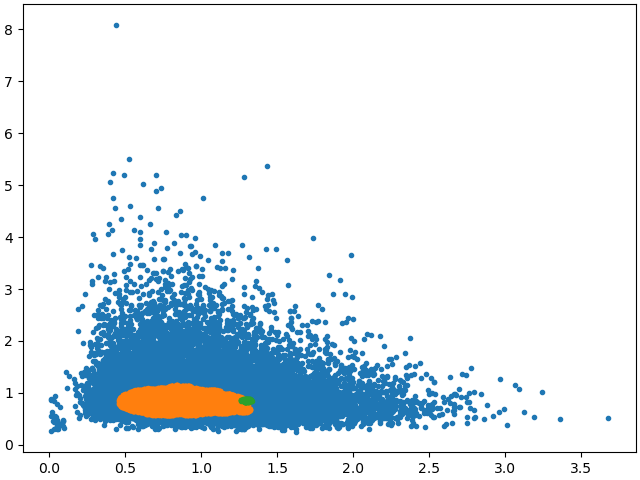

In [160]:
from sklearn.cluster import DBSCAN

db_clustering = DBSCAN(eps=6/np.sqrt(len(msd_steps)), min_samples=110)
db_data = np.array((msd_steps/np.mean(msd_steps), meanbright_steps/np.mean(meanbright_steps))).T
db_clustering.fit(db_data)

db_labels = db_clustering.labels_
db_frame = pd.DataFrame(db_data)
db_frame['cluster'] = db_labels
db_frame.columns = ['Weight', 'Height', 'cluster']

print('There are', len(np.unique(db_frame['cluster'])[1:]), 'clusters')
fig, ax = plt.subplots(constrained_layout=True)
for cluster_i in np.unique(db_frame['cluster']):
    temp_data = db_frame[db_frame['cluster']==cluster_i]
    ax.scatter(temp_data['Weight'],temp_data['Height'], marker='.')
#ax.set_xlabel('MSD per frame [$(\mu m)^2$/s]')
#ax.set_ylabel('Mean photon count')

"\nfig, ax = plt.subplots(constrained_layout=True)\nax.scatter(msd_steps, meanbright_steps, marker='.', s=1)\n\nfig.savefig(results_path.format(f'MSDBrightnessSteps{steps_to_average}_useTOCCSL{use_toccsl}_smROI{smroi_id}.png'))\n"

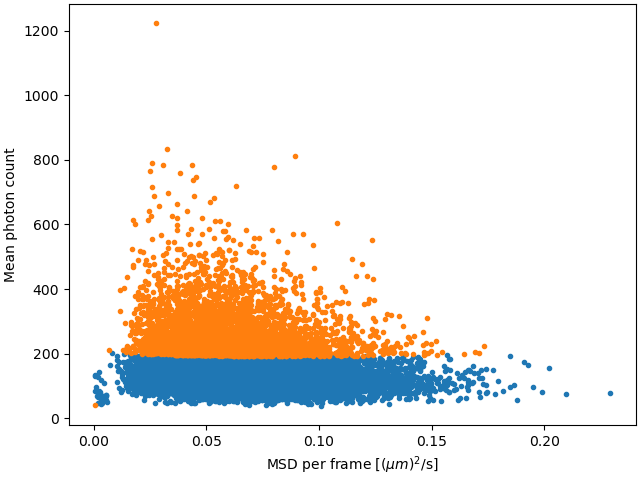

In [149]:
from sklearn.mixture import GaussianMixture

n_gmm = 2
gmm = GaussianMixture(n_components=n_gmm, init_params='random_from_data')
gmm_data = np.array((msd_steps, meanbright_steps)).T
gmm.fit(gmm_data)

gmm_labels = gmm.predict(gmm_data)
gmm_frame = pd.DataFrame(gmm_data)
gmm_frame['cluster'] = gmm_labels
gmm_frame.columns = ['Weight', 'Height', 'cluster']


fig, ax = plt.subplots(constrained_layout=True)
for i in range(0,n_gmm):
    temp_data = gmm_frame[gmm_frame['cluster']==i]
    ax.scatter(temp_data['Weight'],temp_data['Height'], marker='.')
ax.set_xlabel('MSD per frame [$(\mu m)^2$/s]')
ax.set_ylabel('Mean photon count')
"""
fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(msd_steps, meanbright_steps, marker='.', s=1)

fig.savefig(results_path.format(f'MSDBrightnessSteps{steps_to_average}_useTOCCSL{use_toccsl}_smROI{smroi_id}.png'))
"""

In [ ]:
manual_roi = True,
r = 4.94 # Specify radius in micro meters

if manual_roi:
    axis = r/px_size
    set_roi = [roi.EllipseROI((x_center, y_center), (axis, axis))]

In [ ]:
#### **Setting up initial data**

toccsl_folder = data_path.format(f'\\TOCCSL\\{corr_folder}')
sm_folder = data_path.format(f'\\sm\\{corr_folder}')

##### Check if sm_data exists
sm_bool = os.path.isdir(sm_folder)

toccsl_int_data = get_toccsl_dist(toccsl_folder, start_frame=start_frame, set_roi=set_roi, data_sort=groups_dicts)
toccsl_int_data_filtered = toccsl_int_data

if manual_roi:
    min_ROI = set_roi[0]
else:
    min_ROI = make_ROI(fit_rel, chosen_value=max(roi_pos),fig_show=False)[0]
if sm_bool == True:
    sm_int_data = get_sm_dist(sm_folder, start_frame=start_frame_sm, int_roi=min_ROI)
    sm_int_data_filtered = sm_int_data

In [41]:
sm_bool = not sm_bool

In [42]:
if sm_bool:
    single_molecule_data = sm_int_data_filtered[sm_int_data_filtered['frame']>sm_start_frame]
else:
    single_molecule_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']>sm_start_frame]
print(f'{len(single_molecule_data)} data points available of single molecule brightness measurements')

37207 data points available of single molecule brightness measurements


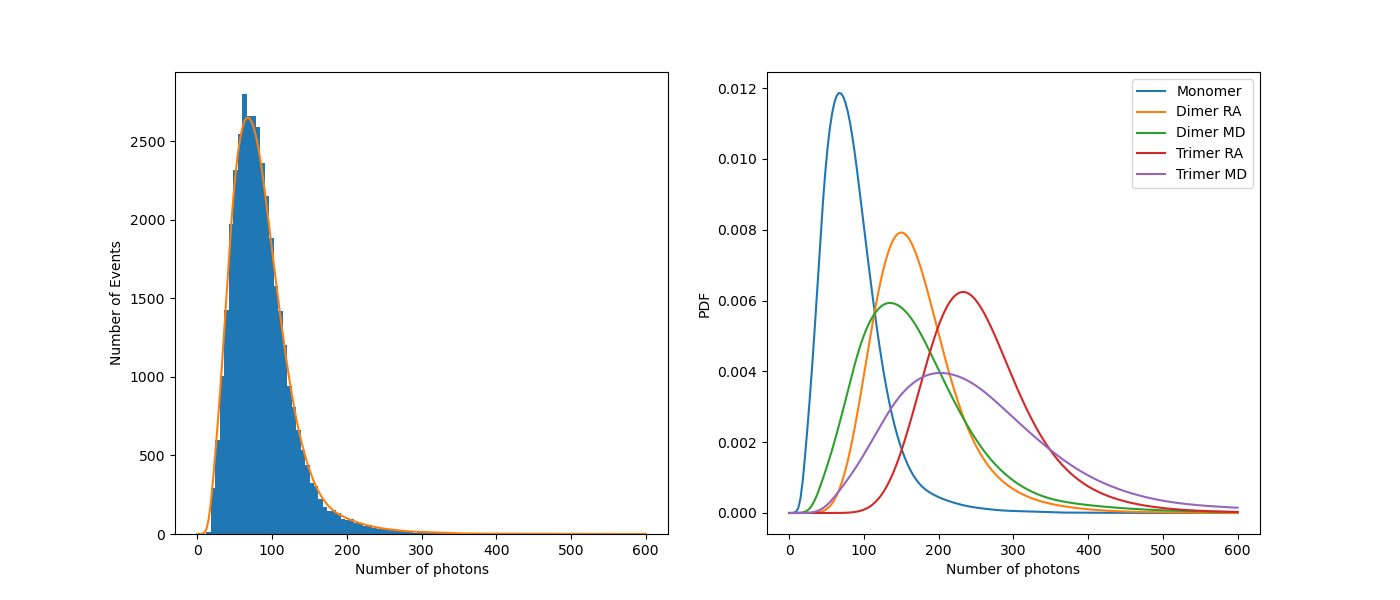

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
monomer_pdf = generate_pdf(single_molecule_data['mass']*conversion_factor)
bins=100
ax[0].hist(conversion_factor*single_molecule_data['mass'], bins=bins, range=(0, lim))
ax[0].plot(plot_vals, len(single_molecule_data['mass'])*(lim/bins)*monomer_pdf(plot_vals))
ax[0].set_xlabel('Number of photons')
ax[0].set_ylabel('Number of Events')

monomer_pdf_values = monomer_pdf(plot_vals)
dimer_pdf_values = scipy.signal.convolve(monomer_pdf_values, monomer_pdf_values)[:len(monomer_pdf_values)]/np.sum(monomer_pdf_values)
trimer_pdf_values = scipy.signal.convolve(monomer_pdf_values, dimer_pdf_values)[:len(monomer_pdf_values)]/np.sum(monomer_pdf_values)
ax[1].plot(plot_vals, monomer_pdf_values, label='Monomer')
ax[1].plot(plot_vals, dimer_pdf_values, label='Dimer RA')
ax[1].plot(plot_vals, monomer_pdf(plot_vals/2)/2, label='Dimer MD')
ax[1].plot(plot_vals, trimer_pdf_values, label='Trimer RA')
ax[1].plot(plot_vals, monomer_pdf(plot_vals/3)/3, label='Trimer MD')
ax[1].set_xlabel('Number of photons')
ax[1].set_ylabel('PDF')
ax[1].legend()
fig.savefig(results_path.format(f'PDF_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}.png'))

Optimization MD: Success after 0.0651698112487793 s
Bootstrapping MD took 35.09223484992981 s
Optimization RA: Success after 0.13651514053344727 s
Bootstrapping RA took 49.4341254234314 s
Completed all after 96.63234424591064 s



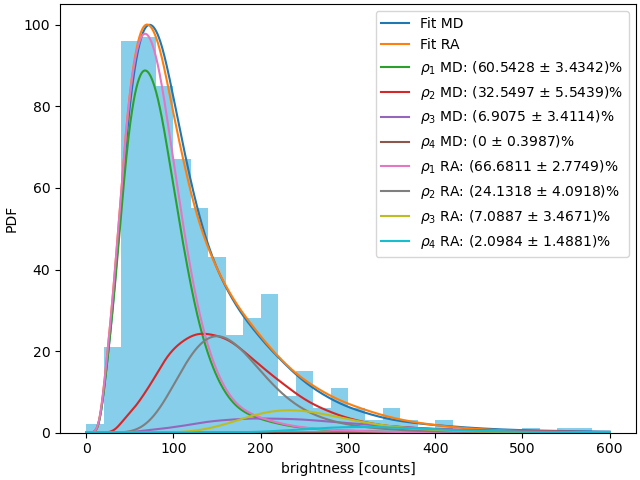

In [44]:
analysis_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame]['mass']
savepath = results_path.format(f'TOCCSLResult_Recovery_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
alphas, errors, fitted_pd = get_alphas(analysis_data*conversion_factor, single_molecule_data*conversion_factor, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, own_pdf_calc=True, savepath=savepath)
toccsl_res = pd.DataFrame(data={'Fraction MD': alphas[0],'Error MD': errors[0], 'Fraction RA': alphas[1],'Error RA': errors[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
toccsl_res.to_excel(writer, sheet_name='TOCCSL Results')
writer.save()

Optimization MD: Success after 0.0849754810333252 s
Bootstrapping MD took 33.22663354873657 s
Optimization RA: Success after 0.1222221851348877 s
Bootstrapping RA took 45.584112882614136 s
Completed all after 91.86420130729675 s



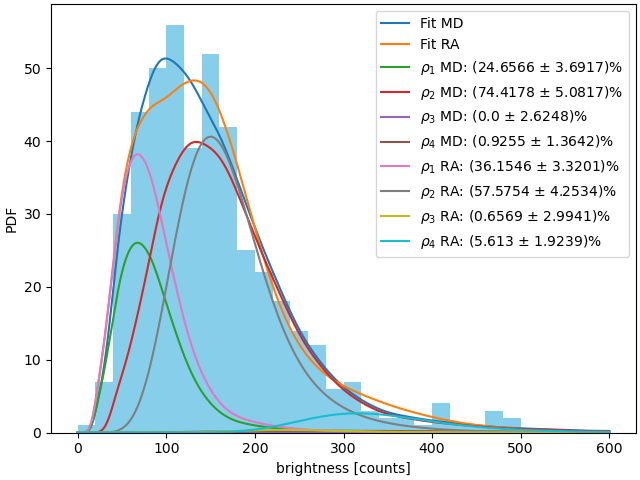

In [45]:
analysis_data = sm_int_data_filtered[sm_int_data_filtered['frame']==1]['mass']
savepath = results_path.format(f'TOCCSLResult_Tracking1_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
alphas, errors, fitted_pd = get_alphas(analysis_data*conversion_factor, single_molecule_data*conversion_factor, lim=lim, lim_con=lim_con, sigma_factor=sigma_factor, own_pdf_calc=True, savepath=savepath)
toccsl_res = pd.DataFrame(data={'Fraction MD': alphas[0],'Error MD': errors[0], 'Fraction RA': alphas[1],'Error RA': errors[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
toccsl_res.to_excel(writer, sheet_name='TOCCSL Results')
writer.save()

Optimization MD: Success after 0.0747518539428711 s
Bootstrapping MD took 37.32890486717224 s
Optimization RA: Success after 0.12405157089233398 s
Bootstrapping RA took 50.29465579986572 s
Completed all after 100.55385637283325 s

Optimization MD: Success after 0.07605242729187012 s
Bootstrapping MD took 35.687482595443726 s
Optimization RA: Success after 0.12289237976074219 s
Bootstrapping RA took 51.60698628425598 s
Completed all after 100.20841145515442 s

Optimization MD: Success after 0.07420802116394043 s
Bootstrapping MD took 35.08807682991028 s
Optimization RA: Success after 0.13652968406677246 s
Bootstrapping RA took 49.93087339401245 s
Completed all after 97.83959865570068 s

Optimization MD: Success after 0.12840652465820312 s
Bootstrapping MD took 41.95827794075012 s
Optimization RA: Success after 0.11603593826293945 s
Bootstrapping RA took 49.087308406829834 s
Completed all after 104.00485801696777 s

Optimization MD: Success after 0.09074521064758301 s
Bootstrapping MD to

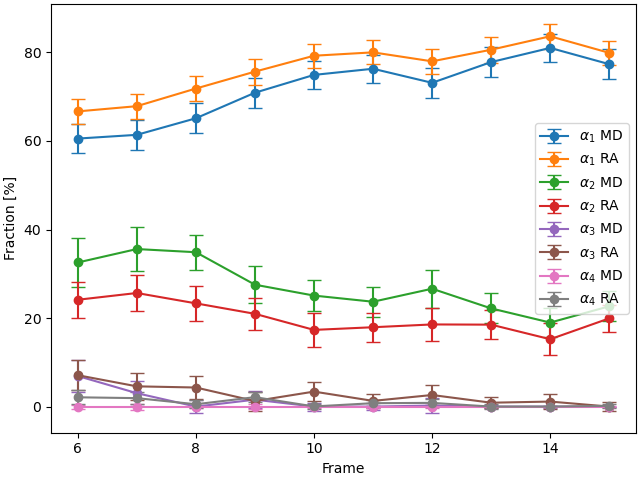

In [46]:
savepath = results_path.format(f'Fractions_Recovery_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
alphas, errors = plot_fraction_development(toccsl_int_data_filtered, rec_frame, 10, savepath=savepath)

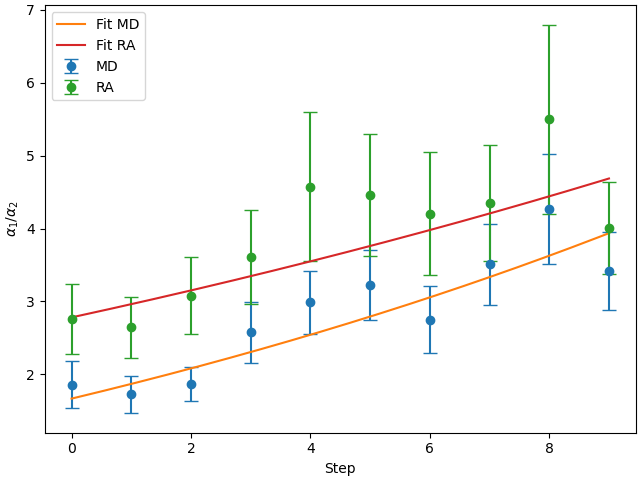

In [47]:
savepath = results_path.format(f'FracFit_Recovery_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
params, errors_fit = fit_fraction(alphas, errors, 0, savepath=savepath)
fit_res = pd.DataFrame(data={'Parameters MD': params[0],'Error MD': errors_fit[0], 'Parameters RA': params[1],'Error RA': errors_fit[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

Optimization MD: Success after 0.07003140449523926 s
Bootstrapping MD took 32.116612672805786 s
Optimization RA: Success after 0.10648179054260254 s
Bootstrapping RA took 40.99682402610779 s
Completed all after 84.81350588798523 s

Optimization MD: Success after 0.059387922286987305 s
Bootstrapping MD took 25.440072298049927 s
Optimization RA: Success after 0.11748623847961426 s
Bootstrapping RA took 45.24102973937988 s
Completed all after 81.97205591201782 s

Optimization MD: Success after 0.05346035957336426 s
Bootstrapping MD took 24.04287075996399 s
Optimization RA: Success after 0.11742448806762695 s
Bootstrapping RA took 46.3569872379303 s
Completed all after 81.75580310821533 s

Optimization MD: Success after 0.04728388786315918 s
Bootstrapping MD took 25.59500527381897 s
Optimization RA: Success after 0.11722588539123535 s
Bootstrapping RA took 44.053677558898926 s
Completed all after 81.00656056404114 s

Optimization MD: Success after 0.042861223220825195 s
Bootstrapping MD to

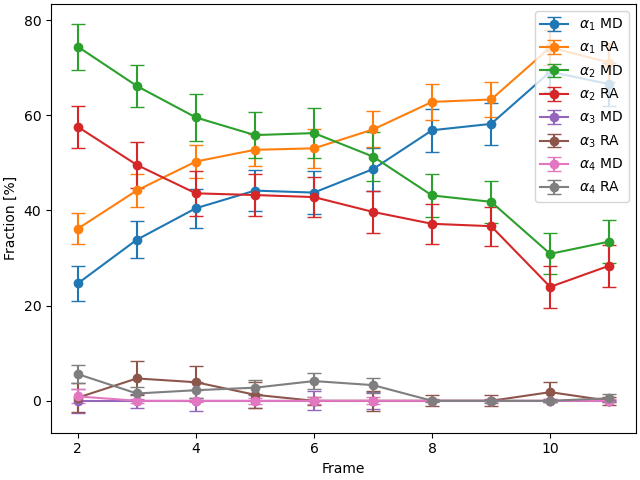

In [48]:
savepath = results_path.format(f'Fractions_Tracking1_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
alphas, errors = plot_fraction_development(sm_int_data_filtered, 1, 10, savepath=savepath)

C:\Users\mrdxy\AppData\Local\Temp\ipykernel_2148\2035652032.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(constrained_layout=True)


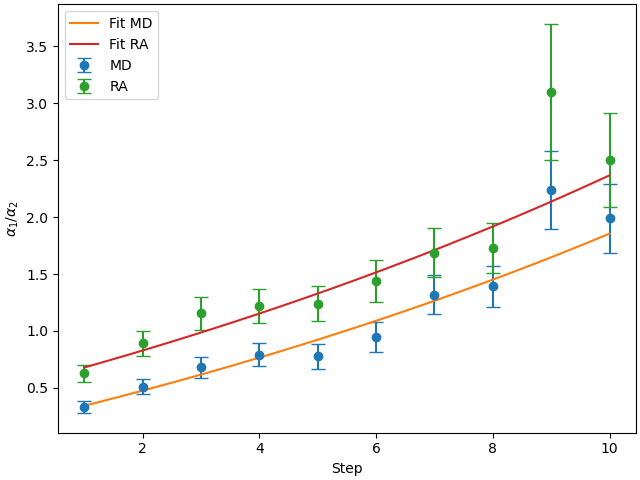

In [49]:
savepath = results_path.format(f'FracFit_Tracking1_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
params, errors_fit = fit_fraction(alphas, errors, 1, savepath=savepath)
fit_res = pd.DataFrame(data={'Parameters MD': params[0],'Error MD': errors_fit[0], 'Parameters RA': params[1],'Error RA': errors_fit[1]})
excel_path = savepath[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
fit_res.to_excel(writer, sheet_name='Fraction Fit Results')
writer.save()

In [ ]:
class fit_dist_3(stats.rv_continuous):
    
    def _cdf(self, x, f1, f2, D1, D2, D3):
        return (1.0 - f1*np.exp(-x/(4*D1)) - f2*np.exp(-x/(4*D2)) - (1.0-f1-f2)*np.exp(-x/(4*D3)))
        
    def _argcheck(self, f1, f2, D1, D2, D3):
        return (0<f1) & (0<f2) & ((f1+f2)<1) & (0<D1) & (0<D2) & (0<D3)
    
    def _fitstart(*data):
        return (data[0], 1/3, 1/3, 1.0, 1.0, 1.0)

class fit_dist_4(stats.rv_continuous):
    
    def _cdf(self, x, f1, f2, f3, D1, D2, D3, D4):
        return (1.0 - f1*np.exp(-x/(4*D1)) - f2*np.exp(-x/(4*D2)) - f3*np.exp(-x/(4*D3)) - (1.0-f1-f2-f3)*np.exp(-x/(4*D4)))
        
    def _argcheck(self, f1, f2, f3, D1, D2, D3, D4):
        return (0<f1) & (0<f2) & (0<f3) & ((f1+f2+f3)<1) & (0<D1) & (0<D2) & (0<D3) & (0<D4)
    
    def _fitstart(*data):
        return (data[0], 1/4, 1/4, 1/4, 1.0, 1.0, 1.0, 1.0)

class fit_dist_5(stats.rv_continuous):
    
    def _cdf(self, x, f1, f2, f3, f4, D1, D2, D3, D4, D5):
        return (1.0 - f1*np.exp(-x/(4*D1)) - f2*np.exp(-x/(4*D2)) - f3*np.exp(-x/(4*D3)) - f4*np.exp(-x/(4*D4)) - (1.0-f1-f2-f3-f4)*np.exp(-x/(4*D5)))
        
    def _argcheck(self, f1, f2, f3, f4, D1, D2, D3, D4, D5):
        return (0<f1) & (0<f2) & (0<f3) & (0<f4) & ((f1+f2+f3+f4)<1) & (0<D1) & (0<D2) & (0<D3) & (0<D4) & (0<D5)
    
    def _fitstart(*data):
        return (data[0], 1/5, 1/5, 1/5, 1/5, 1.0, 1.0, 1.0, 1.0, 1.0)
    
class fit_dist_6(stats.rv_continuous):
    
    def _cdf(self, x, f1, f2, f3, f4, f5, D1, D2, D3, D4, D5, D6):
        return (1.0 - f1*np.exp(-x/(4*D1)) - f2*np.exp(-x/(4*D2)) - f3*np.exp(-x/(4*D3)) - f4*np.exp(-x/(4*D4)) - f5*np.exp(-x/(4*D5)) - (1.0-f1-f2-f3-f4-f5)*np.exp(-x/(4*D6)))
        
    def _argcheck(self, f1, f2, f3, f4, f5, D1, D2, D3, D4, D5, D6):
        return (0<f1) & (0<f2) & (0<f3) & (0<f4) & (0<f5) & ((f1+f2+f3+f4+f5)<1) & (0<D1) & (0<D2) & (0<D3) & (0<D4) & (0<D5) & (0<D6)
    
    def _fitstart(*data):
        return (data[0], 1/6, 1/6, 1/6, 1/6, 1/6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

dist_for_fit_3 = fit_dist_3(a=0, name="dist_for_fit_3")
parameters_3 = dist_for_fit_3.fit(data, 1/3, 1/3, initial_D_guess, initial_D_guess, initial_D_guess, floc=0.0, fscale=1.0)
dist_for_fit_4 = fit_dist_4(a=0, name="dist_for_fit_4")
parameters_4 = dist_for_fit_4.fit(data, 1/4, 1/4, 1/4, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, floc=0.0, fscale=1.0)
dist_for_fit_5 = fit_dist_5(a=0, name="dist_for_fit_5")
parameters_5 = dist_for_fit_5.fit(data, 1/5, 1/5, 1/5, 1/5, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, floc=0.0, fscale=1.0)
dist_for_fit_6 = fit_dist_6(a=0, name="dist_for_fit_6")
parameters_6 = dist_for_fit_6.fit(data, 1/6, 1/6, 1/6, 1/6, 1/6, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, initial_D_guess, floc=0.0, fscale=1.0)

print(f'3 Species:',
      f'\n{parameters_3[0]*100}% with D={parameters_3[2]} $\mu^2$/s',
      f'\n{parameters_3[1]*100}% with D={parameters_3[3]} $\mu^2$/s',
      f'\n{(1-parameters_3[0]-parameters_3[1])*100}% with D={parameters_3[4]} $\mu^2$/s \n')
print(f'4 Species:',
      f'\n{parameters_4[0]*100}% with D={parameters_4[3]} $\mu^2$/s',
      f'\n{parameters_4[1]*100}% with D={parameters_4[4]} $\mu^2$/s',
      f'\n{parameters_4[2]*100}% with D={parameters_4[5]} $\mu^2$/s',
      f'\n{(1-parameters_4[0]-parameters_4[1]-parameters_4[2])*100}% with D={parameters_4[6]} $\mu^2$/s \n')
print(f'5 Species:',
      f'\n{parameters_5[0]*100}% with D={parameters_5[4]} $\mu^2$/s',
      f'\n{parameters_5[1]*100}% with D={parameters_5[5]} $\mu^2$/s',
      f'\n{parameters_5[2]*100}% with D={parameters_5[6]} $\mu^2$/s',
      f'\n{parameters_5[3]*100}% with D={parameters_5[7]} $\mu^2$/s',
      f'\n{(1-parameters_5[0]-parameters_5[1]-parameters_5[2]-parameters_5[3])*100}% with D={parameters_5[8]} $\mu^2$/s \n')
print(f'6 Species:',
      f'\n{parameters_6[0]*100}% with D={parameters_6[5]} $\mu^2$/s',
      f'\n{parameters_6[1]*100}% with D={parameters_6[6]} $\mu^2$/s',
      f'\n{parameters_6[2]*100}% with D={parameters_6[7]} $\mu^2$/s',
      f'\n{parameters_6[3]*100}% with D={parameters_6[8]} $\mu^2$/s',
      f'\n{parameters_6[4]*100}% with D={parameters_6[9]} $\mu^2$/s',
      f'\n{(1-parameters_6[0]-parameters_6[1]-parameters_6[2]-parameters_6[3]-parameters_6[4])*100}% with D={parameters_6[10]} $\mu^2$/s \n')

print('3 Species:', stats.kstest(data, lambda x: dist_for_fit_3.cdf(x, *parameters_3)))
print('4 Species:', stats.kstest(data, lambda x: dist_for_fit_4.cdf(x, *parameters_4)))
print('5 Species:', stats.kstest(data, lambda x: dist_for_fit_5.cdf(x, *parameters_5)))
print('6 Species:', stats.kstest(data, lambda x: dist_for_fit_6.cdf(x, *parameters_6)))

plt.plot(plotting, len(data)*(lim/bins)*dist_for_fit_3.pdf(plotting, *parameters_3), label='Fit 3 Species')
plt.plot(plotting, len(data)*(lim/bins)*dist_for_fit_4.pdf(plotting, *parameters_4), label='Fit 4 Species')
plt.plot(plotting, len(data)*(lim/bins)*dist_for_fit_5.pdf(plotting, *parameters_5), label='Fit 5 Species')

ax.plot(plot_vals, dist_for_fit_3.cdf(plot_vals, *parameters_3), label='Fit 3 Species')
ax.plot(plot_vals, dist_for_fit_4.cdf(plot_vals, *parameters_4), label='Fit 4 Species')
ax.plot(plot_vals, dist_for_fit_4.cdf(plot_vals, *parameters_4), label='Fit 5 Species')

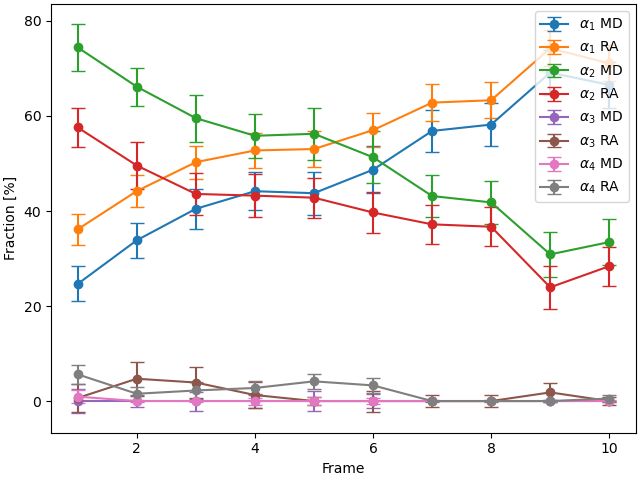

In [85]:
fig, ax = plt.subplots(constrained_layout=True)
labels_MD = []
labels_RA = []
i = 1
for alpha in alphas[0]:
    labels_MD.append(r'$\alpha_{}$ MD'.format(i))
    labels_RA.append(r'$\alpha_{}$ RA'.format(i))
    i += 1
for i in range(len(alphas[0])):
    ax.errorbar(np.arange(iterations+starting_frame-1)+1, np.array(alphas_MD)[:,i]*100, yerr=np.array(errors_MD)[:,i]*100, marker='o', capsize=5, label=labels_MD[i])
    ax.errorbar(np.arange(iterations+starting_frame-1)+1, np.array(alphas_RA)[:,i]*100, yerr=np.array(errors_RA)[:,i]*100, marker='o', capsize=5, label=labels_RA[i])
ax.set_xlabel('Frame')
ax.set_ylabel('Fraction [%]')
ax.legend()
savepath = results_path.format(f'Fractions_Tracking1_smbool{sm_bool}_startframe{sm_start_frame}_roi{roi_identifier}_n{lim_con}.png')
if savepath != None:
    fig.savefig(savepath)

In [ ]:
"""
radii_circ = [np.sqrt(a/np.pi) for a in areas]
i = 0
for val in roi_pos:
    idx = list(levels).index(roi_pos[i])
    chosen_circ_radius = radii_circ[idx]
    i += 1
    print('ROI area of data group ' + str(i) + ' corresponds to circle with a radius of {} µm.'.format(np.round(chosen_circ_radius,2)))
"""

In [170]:
"""
def generate_pdf(data):
    def f(x):
        y = stats.gaussian_kde(data, bw_method=bandwidth).pdf(x)
        return y
    return f
"""

'\ndef generate_pdf(data):\n    def f(x):\n        y = stats.gaussian_kde(data, bw_method=bandwidth).pdf(x)\n        return y\n    return f\n'

In [173]:
"""
dist = getattr(stats, 'lognorm')
plot_vals = np.linspace(0, lim, 200)
plt.close('all')
params = dist.fit(conversion_factor*single_molecule_data['mass'], floc=0)
print(params)
bins=50
lim
plt.hist(conversion_factor*single_molecule_data['mass'], bins=bins, range=(0, lim))
plt.plot(plot_vals, len(single_molecule_data['mass'])*(lim/bins)*dist.pdf(plot_vals, *params))
plt.show()
"""

"\ndist = getattr(stats, 'lognorm')\nplot_vals = np.linspace(0, lim, 200)\nplt.close('all')\nparams = dist.fit(conversion_factor*single_molecule_data['mass'], floc=0)\nprint(params)\nbins=50\nlim\nplt.hist(conversion_factor*single_molecule_data['mass'], bins=bins, range=(0, lim))\nplt.plot(plot_vals, len(single_molecule_data['mass'])*(lim/bins)*dist.pdf(plot_vals, *params))\nplt.show()\n"

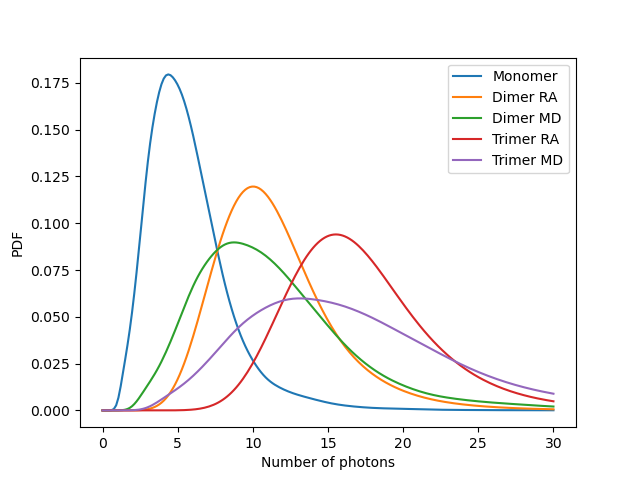

In [292]:
fig, ax = plt.subplots()
monomer_pdf_values = monomer_pdf(plot_vals)
dimer_pdf_values = scipy.signal.convolve(monomer_pdf_values, monomer_pdf_values)[:len(monomer_pdf_values)]/np.sum(monomer_pdf_values)
trimer_pdf_values = scipy.signal.convolve(monomer_pdf_values, dimer_pdf_values)[:len(monomer_pdf_values)]/np.sum(monomer_pdf_values)
ax.plot(plot_vals, monomer_pdf_values, label='Monomer')
ax.plot(plot_vals, dimer_pdf_values, label='Dimer RA')
ax.plot(plot_vals, monomer_pdf(plot_vals/2)/2, label='Dimer MD')
ax.plot(plot_vals, trimer_pdf_values, label='Trimer RA')
ax.plot(plot_vals, monomer_pdf(plot_vals/3)/3, label='Trimer MD')
ax.set_xlabel('Number of photons')
ax.set_ylabel('PDF')
ax.legend()

In [267]:
class fit_dist_MD(stats.rv_continuous):

    def _pdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        res = np.zeros_like(x)
        i = 1.0
        for alpha in alphas:
            res += alpha*monomer_pdf(x/i)/i
            i += 1
        return res
    
    def _argcheck(self, a1, a2, a3):
        return (0<a1) & (0<a2) & (0<a3) & (a1+a2+a3<1)
    
    def _fitstart(*data):
        return (data[0], 1/4, 1/4, 14)

class fit_dist_RA(stats.rv_continuous):

    def _pdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        ticks = np.linspace(0, 1*lim, int(5000))
        monomer_tick_vals = monomer_pdf(ticks)
        temp_tick_vals = monomer_tick_vals
        tick_vals = {}
        i = 1
        for alpha in alphas:
            tick_vals[i] = temp_tick_vals
            temp_tick_vals = scipy.signal.convolve(temp_tick_vals, monomer_tick_vals)[:len(monomer_tick_vals)]/np.sum(monomer_tick_vals)
            i += 1
        res = np.zeros_like(x)
        indices = np.zeros_like(x, dtype=int)
        for i in range(len(x)):
            value = x[i]
            indices[i] = int((np.abs(np.asarray(ticks) - value)).argmin())
        i = 1
        for alpha in alphas:
            res += alpha*tick_vals[i][indices]
            i += 1
        return res
    
    def _argcheck(self, a1, a2, a3):
        return (0<a1) & (0<a2) & (0<a3) & (a1+a2+a3<1)
    
    def _fitstart(*data):
        return (data[0], 1/4, 1/4, 14)

In [268]:
def plotting_composition(testing_data):

    dist_for_fit_MD = fit_dist_MD(name="dist_for_fit_MD")
    parameters_MD = dist_for_fit_MD.fit(testing_data*conversion_factor, 1/4, 1/4, 1/4, floc=0.0, fscale=1.0)
    print('MD done')
    dist_for_fit_RA = fit_dist_RA(name="dist_for_fit_RA")
    parameters_RA = dist_for_fit_RA.fit(testing_data*conversion_factor, 1/4, 1/4, 1/4, floc=0.0, fscale=1.0)
    print('RA done')
    #parameters_RA = parameters_MD
    fig, ax = plt.subplots()
    bins=10
    ax.hist(testing_data*conversion_factor, bins=bins, range=(0, lim))
    ax.plot(plot_vals, len(testing_data)*(lim/bins)*dist_for_fit_MD.pdf(plot_vals, *parameters_MD), label='Fit MD')
    ax.plot(plot_vals, len(testing_data)*(lim/bins)*dist_for_fit_RA.pdf(plot_vals, *parameters_RA), label='Fit RA')
    ax.plot(plot_vals, parameters_MD[0]*len(testing_data)*(lim/bins)*monomer_pdf(plot_vals), label=f'Monomer MD {round(100*parameters_MD[0], 4)}%')
    ax.plot(plot_vals, parameters_MD[1]*len(testing_data)*(lim/bins)*monomer_pdf(plot_vals/2)/2, label=f'Dimer MD {round(100*parameters_MD[1], 4)}%')
    ax.plot(plot_vals, parameters_MD[2]*len(testing_data)*(lim/bins)*monomer_pdf(plot_vals/3)/3, label=f'Trimer MD {round(100*parameters_MD[2], 4)}%')
    ax.plot(plot_vals, (1-parameters_MD[0]-parameters_MD[1]-parameters_MD[2])*len(testing_data)*(lim/bins)*monomer_pdf(plot_vals/4)/4, label=f'Tetramer MD {round(100*(1-parameters_MD[0]-parameters_MD[1]-parameters_MD[2]), 4)}%')
    monomer_pdf_vals = monomer_pdf(plot_vals)
    ax.plot(plot_vals, parameters_RA[0]*len(testing_data)*(lim/bins)*monomer_pdf_vals, label=f'Monomer RA {round(100*parameters_RA[0], 4)}%')
    dimer_pdf_vals = scipy.signal.convolve(monomer_pdf_vals, monomer_pdf_vals)[:len(monomer_pdf_vals)]/np.sum(monomer_pdf_vals)
    ax.plot(plot_vals, parameters_RA[1]*len(testing_data)*(lim/bins)*dimer_pdf_vals, label=f'Dimer RA {round(100*parameters_RA[1], 4)}%')
    trimer_pdf_vals = scipy.signal.convolve(monomer_pdf_vals, dimer_pdf_vals)[:len(monomer_pdf_vals)]/np.sum(monomer_pdf_vals)
    ax.plot(plot_vals, parameters_RA[2]*len(testing_data)*(lim/bins)*trimer_pdf_vals, label=f'Trimer RA {round(100*parameters_RA[2], 4)}%')
    tetramer_pdf_vals = scipy.signal.convolve(monomer_pdf_vals, trimer_pdf_vals)[:len(monomer_pdf_vals)]/np.sum(monomer_pdf_vals)
    ax.plot(plot_vals, (1-parameters_RA[0]-parameters_RA[1]-parameters_RA[2])*len(testing_data)*(lim/bins)*tetramer_pdf_vals, label=f'Tetramer RA {round(100*(1-parameters_RA[0]-parameters_RA[1]-parameters_RA[2]), 4)}%')
    ax.set_xlabel('Number of photons')
    ax.set_ylabel('Number of Events')
    ax.legend()
    fig.show()
    print(parameters_MD)
    print(parameters_RA)

MD done
RA done


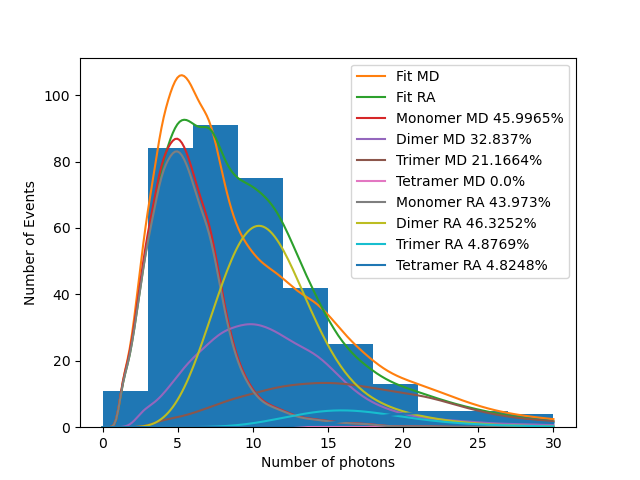

(0.45996503604268424, 0.32837014072802684, 0.2116644055836206, 0.0, 1.0)
(0.43973040475853975, 0.46325216071252845, 0.048769447898693835, 0.0, 1.0)


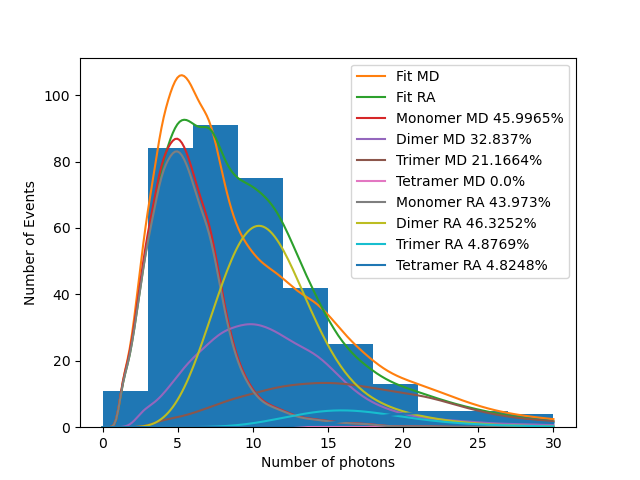

In [105]:
analysis_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame]['mass']
analysis_data = sm_int_data_filtered[sm_int_data_filtered['frame']==1]['mass']
plotting_composition(analysis_data)

In [87]:
list_of_dists = ['burr12', 'mielke', 'alpha', 'genlogistic', 'gumbel_r', 'fisk', 'exponnorm', 'genextreme', 'invgamma', 'johnsonsu', 'f', 'nct', 'betaprime', 'johnsonsb', 'lognorm']

In [178]:
class fit_dist(stats.rv_continuous):

    def _pdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        res = np.zeros_like(x)
        i = 1.0
        for alpha in alphas:
            res += alpha*stats.lognorm.pdf(x/i, *params)/i
            i += 1
        return res
    
    def _cdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        res = np.zeros_like(x)
        i = 1.0
        for alpha in alphas:
            res += alpha*stats.lognorm.cdf(x/i, *params)
            i += 1
        return res
    
    def _argcheck(self, a1, a2, a3):
        return (0<a1) & (0<a2) & (0<a3) & (a1+a2+a3<1)
    
    def _fitstart(*data):
        return (data[0], 1/4, 1/4, 14)

In [ ]:
"""
dist = getattr(stats, 'lognorm')
plot_vals = np.linspace(0, lim, 200)
plt.close('all')
params = dist.fit(conversion_factor*single_molecule_data['mass'], floc=0)
print(params)
bins=50
lim
plt.hist(conversion_factor*single_molecule_data['mass'], bins=bins, range=(0, lim))
plt.plot(plot_vals, len(single_molecule_data['mass'])*(lim/bins)*dist.pdf(plot_vals, *params))
plt.show()
"""

In [49]:
list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(conversion_factor*single_molecule_data['mass'], floc=0)
    a = stats.kstest(conversion_factor*single_molecule_data['mass'], i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

C:\Users\sdt\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\sdt\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\sdt\miniconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sdt\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:809: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\sdt\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:813: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
C:\Users\sdt\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2

burr12: statistic=0.013764652176522896, pvalue=0.04690747240698534
genlogistic: statistic=0.014644500755349732, pvalue=0.02860841676134962
burr: statistic=0.015214883270730173, pvalue=0.02042570025104488
mielke: statistic=0.01521947772232557, pvalue=0.02036928019383854
nct: statistic=0.018746134585264196, pvalue=0.0019054333883826253
fisk: statistic=0.019032713310896066, pvalue=0.0015381447852337144
gausshyper: statistic=0.022119011161832236, pvalue=0.00012476867282862995
f: statistic=0.02227326922499584, pvalue=0.00010896554880343966
betaprime: statistic=0.02227337571459065, pvalue=0.00010895532649631553
ncf: statistic=0.022583798437564306, pvalue=8.272746144761248e-05
johnsonsu: statistic=0.023219717843172782, pvalue=4.6502593742440504e-05
powerlognorm: statistic=0.024452068266486937, pvalue=1.4551134470212279e-05
lognorm: statistic=0.0245244942055568, pvalue=1.3565346431077108e-05
johnsonsb: statistic=0.024534843163014908, pvalue=1.3429821638967975e-05
exponweib: statistic=0.0250682

## <u> **PDF brightness analysis**

### **Settings**

In [26]:
#sm_int_data_filtered = sm_int_data_filtered.sort_values(by='frame')

In [27]:
#len(sm_int_data_filtered)

In [31]:
#sm_int_data_filtered = sm_int_data_filtered.sort_values(by='frame')
#for row in sm_int_data_filtered.iterrows():
#    valframe = row[1]['frame']
#    valx = row[1]['x']
#    valy = row[1]['y']
#    temp = sm_int_data_filtered[valx-2<sm_int_data_filtered['x']]
#    temp = temp[temp['x']<valx+2]
#    temp = temp[valy-2<temp['y']]
#    temp = temp[temp['y']<valy+2]
#    if not (temp[temp['frame']==valframe+2].empty):
#        sm_int_data_filtered = sm_int_data_filtered[(sm_int_data_filtered['frame'] != valframe) | (sm_int_data_filtered['x'] != valx) | (sm_int_data_filtered['y'] != valy)]
#        continue
#    elif temp[temp['frame']==valframe+1].empty:
#        sm_int_data_filtered = sm_int_data_filtered[(sm_int_data_filtered['frame'] != valframe) | (sm_int_data_filtered['x'] != valx) | (sm_int_data_filtered['y'] != valy)]
#        continue

In [32]:
len(sm_int_data_filtered)

17698

In [33]:
starting_frame = 20
sm_int_data_filtered = sm_int_data_filtered[sm_int_data_filtered['frame']>starting_frame]
len(sm_int_data_filtered)

9879

In [34]:
dist = getattr(stats, 'lognorm')

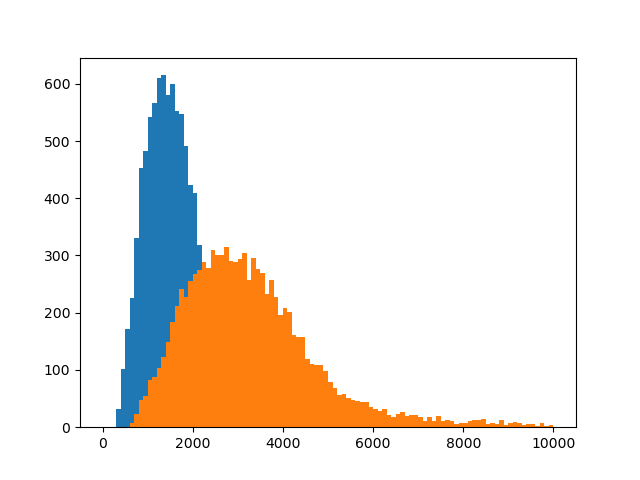

In [199]:
plt.close('all')
bins=100
plt.hist(sm_int_data_filtered['mass'], bins=bins, range=(0, 10000))
plt.hist(2.0*sm_int_data_filtered['mass'], bins=bins, range=(0, 10000))
plt.show()

(0.46393867136373806, 0.0, 1504.9903435886147)


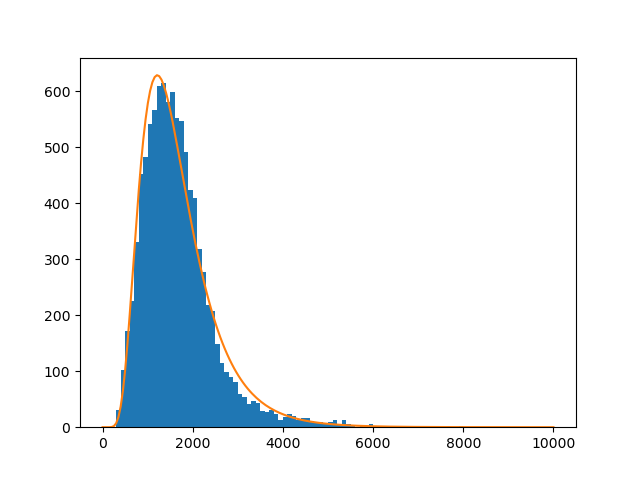

In [195]:
plot_vals = np.linspace(0, 10000, 200)
plt.close('all')
params = dist.fit(sm_int_data_filtered['mass'], floc=0.0)
print(params)
bins=100
plt.hist(sm_int_data_filtered['mass'], bins=bins, range=(0, 10000))
plt.plot(plot_vals, len(sm_int_data_filtered['mass'])*(10000/bins)*dist.pdf(plot_vals, *params))
plt.show()

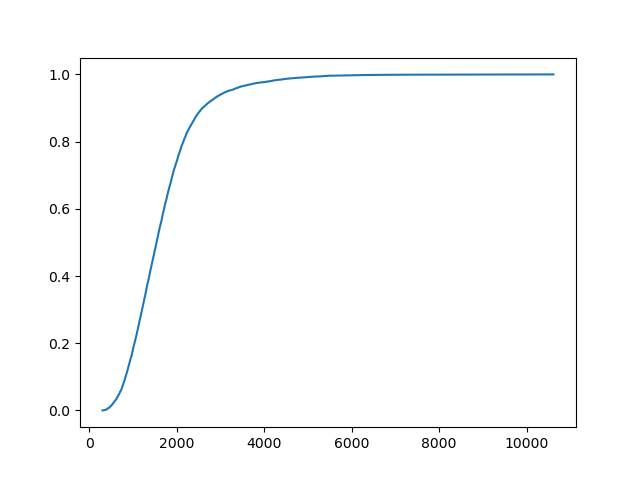

In [36]:
p = 1. * np.arange(len(sm_int_data_filtered['mass'])) / (len(sm_int_data_filtered['mass']) - 1)
plt.close('all')
sorted_data = np.sort(sm_int_data_filtered['mass'])
plt.plot(sorted_data, p)
plt.show()

In [37]:
list_of_dists_that_fit_good_only_small_part = ['burr12', 'mielke', 'lognorm']


In [38]:
dist = getattr(stats, 'lognorm')
params = dist.fit(sm_int_data_filtered['mass'])
n = 3
alphas = np.ones(n)/n

In [178]:
from scipy import stats

class fit_dist(stats.rv_continuous):

    def _pdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        res = np.zeros_like(x)
        i = 1.0
        for alpha in alphas:
            res += alpha*stats.lognorm.pdf(x/i, *params)/i
            i += 1
        return res
    
    def _cdf(self, x, a1, a2, a3):

        alphas = np.array([a1, a2, a3, 1.0-(a1+a2+a3)])
        res = np.zeros_like(x)
        i = 1.0
        for alpha in alphas:
            res += alpha*stats.lognorm.cdf(x/i, *params)
            i += 1
        return res
    
    def _argcheck(self, a1, a2, a3):
        return (0<a1) & (0<a2) & (0<a3) & (a1+a2+a3<1)
    
    def _fitstart(*data):
        return (data[0], 1/4, 1/4, 14)

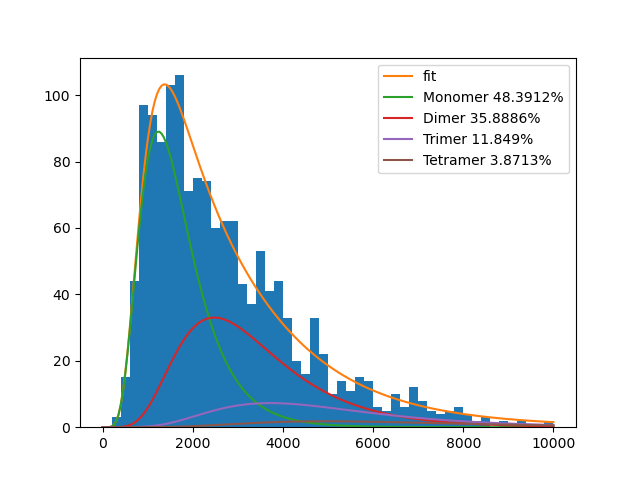

(0.48391178925436984, 0.3588856184263942, 0.11848971781023976, 0.0, 1.0)


In [194]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame]['mass']
plotting_composition(test_data)

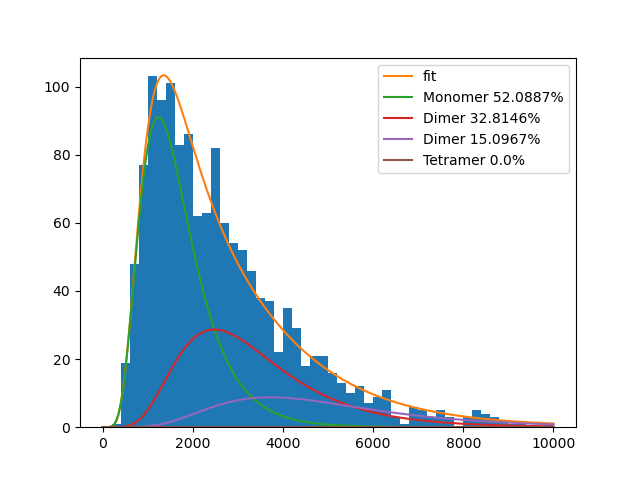

(0.5208870511838499, 0.32814599043990533, 0.1509669303610679, 0.0, 1.0)


In [187]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame+1]['mass']
plotting_composition(test_data)

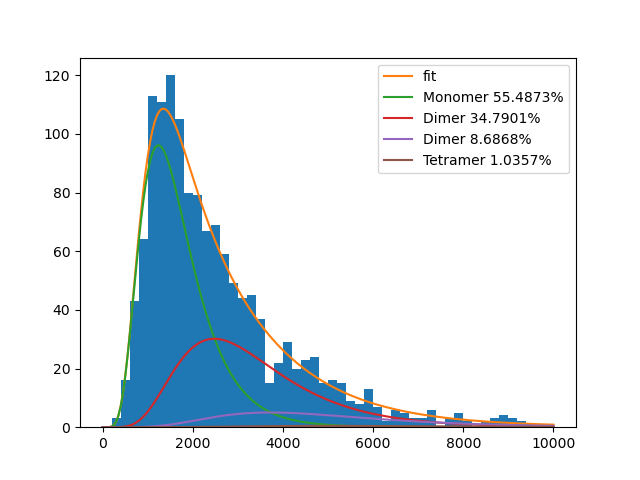

(0.5548733984885794, 0.3479014452181032, 0.08686799507849935, 0.0, 1.0)


In [188]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame+2]['mass']
plotting_composition(test_data)

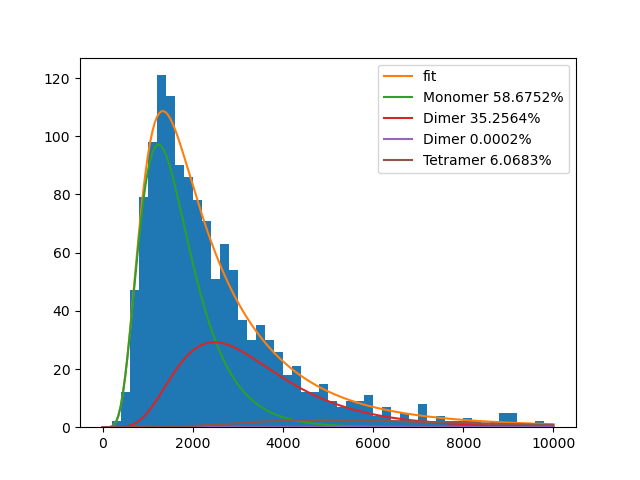

(0.5867521472952708, 0.3525636586063885, 1.5581331655779868e-06, 0.0, 1.0)


In [189]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame+3]['mass']
plotting_composition(test_data)

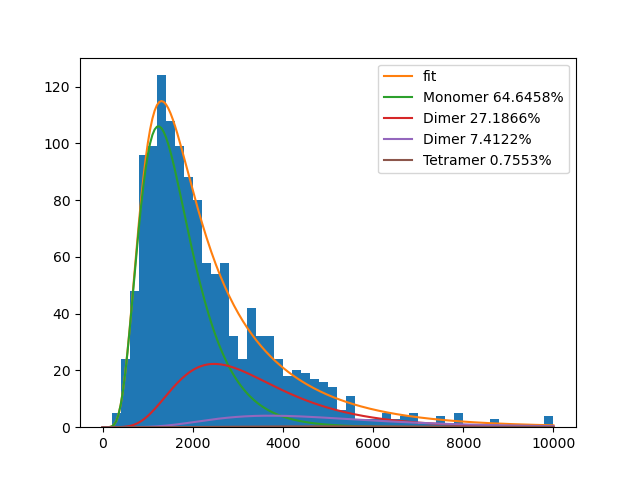

(0.646458110300991, 0.27186623311702773, 0.07412231566955285, 0.0, 1.0)


In [190]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame+4]['mass']
plotting_composition(test_data)

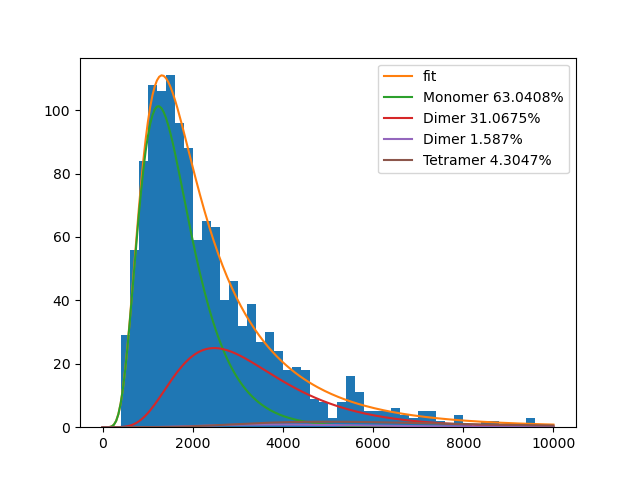

(0.6304083753733185, 0.31067490633485567, 0.015870034257905792, 0.0, 1.0)


In [191]:
test_data = toccsl_int_data_filtered[toccsl_int_data_filtered['frame']==rec_frame+5]['mass']
plotting_composition(test_data)

In [193]:
def plotting_composition(testing_data):

    dist_for_fit = fit_dist(name="dist_for_fit")
    parameters = dist_for_fit.fit(testing_data, 1/4, 1/4, 1/4, floc=0.0, fscale=1.0)
    plt.close('all')
    bins=50
    plt.hist(testing_data, bins=bins, range=(0, 10000))
    plt.plot(plot_vals, len(testing_data)*(10000/bins)*dist_for_fit.pdf(plot_vals, *parameters), label='fit')
    plt.plot(plot_vals, parameters[0]*len(testing_data)*(10000/bins)*dist.pdf(plot_vals, *params), label=f'Monomer {round(100*parameters[0], 4)}%')
    plt.plot(plot_vals, parameters[1]*len(testing_data)*(10000/bins)*dist.pdf(plot_vals/2, *params)/2, label=f'Dimer {round(100*parameters[1], 4)}%')
    plt.plot(plot_vals, parameters[2]*len(testing_data)*(10000/bins)*dist.pdf(plot_vals/3, *params)/3, label=f'Trimer {round(100*parameters[2], 4)}%')
    plt.plot(plot_vals, (1-parameters[0]-parameters[1]-parameters[2])*len(testing_data)*(10000/bins)*dist.pdf(plot_vals/4, *params)/4, label=f'Tetramer {round(100*(1-parameters[0]-parameters[1]-parameters[2]), 4)}%')
    plt.legend()
    plt.show()
    print(parameters)

In [87]:
list_of_dists = ['burr12', 'mielke', 'alpha', 'genlogistic', 'gumbel_r', 'fisk', 'exponnorm', 'genextreme', 'invgamma', 'johnsonsu', 'f', 'nct', 'betaprime', 'johnsonsb', 'lognorm']

In [39]:
######## limit on x axis for pdfs
lim = 10000
######## highest oligomeric state to consider
lim_con = 6
######## number of bootstrap iterations
iterations = 100
######## fraction of single molecule data used in bootstrap iterations
perc = 0.5
######## if no sm data is available take data from toccsl dataset starting at this frame
sm_start_frame = 20
######## if you want to manually exclude the sm data
sm_bool = True
######## choose if you want the manual pdf calculation
own_pdf_calc = False

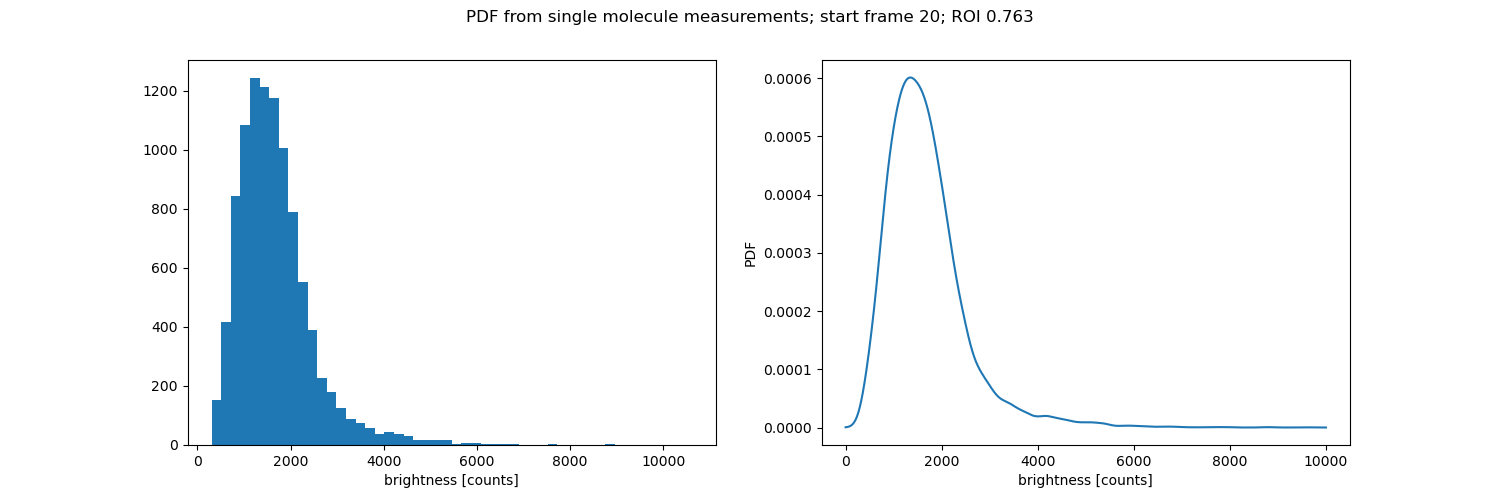

In [40]:
if sm_bool:
    fig, ax = plt.subplots(1,2, figsize=(15,5))
else:
    fig, ax = plt.subplots(group_num,2, figsize=(15,5))

hist_bins = 50

if sm_bool == False:
    sm_int_data_filtered = None
    
if sm_bool:
    roi_num = round(max(roi_pos), 3)
    ax[0].hist(sm_int_data_filtered['mass'], bins=hist_bins)
    if group_num != 1:
        toccsl_data = toccsl_int_data_filtered['g1']
    else:
        toccsl_data = toccsl_int_data_filtered
    pdf = get_pdfs(toccsl_data, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, perc=perc, own_pdf_calc=own_pdf_calc)[0]
    ax[1].plot(pdf[0][0], pdf[0][1])
    fig.suptitle(f'PDF from single molecule measurements; start frame {starting_frame}; ROI {roi_num}')
    savename = f'PDF_sm_startframe{starting_frame}_roi{roi_num}'

elif type(toccsl_int_data_filtered) == dict:
    roi_num = np.round(roi_pos, 3)
    for k, toccsl_data in tqdm(toccsl_int_data_filtered.items(), desc='Groups'):
        k = int(k[1])-1
        ax[k,0].hist(toccsl_data[toccsl_data['frame']>sm_start_frame]['mass'], bins=hist_bins)
        pdf = get_pdfs(toccsl_data, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, perc=perc, own_pdf_calc=own_pdf_calc)[0]
        ax[k,1].plot(pdf[0][0], pdf[0][1])
    fig.suptitle(f'PDF from TOCCSL measurements; {group_num} groups; start frame {sm_start_frame}; ROI {roi_num}')
    savename = f'PDF_TOCCSL_{group_num}groups_startframe{sm_start_frame}_roi{roi_num}'
else:
    roi_num = round(roi_pos[0], 3)
    ax[0].hist(toccsl_int_data_filtered[toccsl_int_data_filtered['frame']>sm_start_frame]['mass'], bins=hist_bins)
    pdf = get_pdfs(toccsl_int_data_filtered, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, perc=perc, own_pdf_calc=own_pdf_calc)[0]
    ax[1].plot(pdf[0][0], pdf[0][1])
    fig.suptitle(f'PDF from TOCCSL measurements; start frame {sm_start_frame}; ROI {roi_num}')
    savename = f'PDF_TOCCSL_1group_startframe{sm_start_frame}_roi{roi_num}'

if group_num == 1 or sm_bool:
    ax[0].set_xlabel('brightness [counts]')
    ax[1].set_xlabel('brightness [counts]')
    ax[1].set_ylabel('PDF')
else:
    for i in range(group_num):
        ax[i,0].set_xlabel('brightness [counts]')
        ax[i,1].set_xlabel('brightness [counts]')
        ax[i,1].set_ylabel('PDF')
savepath = results_path.format(f'{savename}.png')
fig.savefig(savepath)

In [41]:
####### If something specific needs to be filtered out; Individual for each run
# sm_int_data_filtered = sm_int_data_filtered[sm_int_data_filtered['mass']<5000]

### **Get results**

Initial analysis completed - Elapsed time: 0.9991745948791504s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 63.9804527759552s


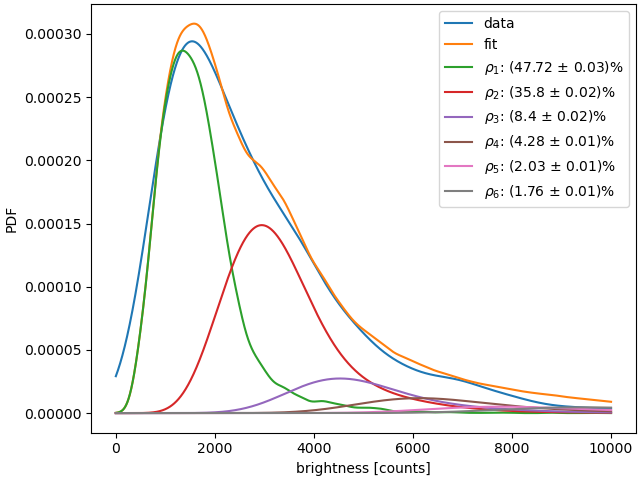

In [42]:
if sm_bool == False:
    sm_int_data_filtered = None

if type(toccsl_int_data_filtered) == dict:
    alphas = {}
    fitted_pd = {}
    means = {}
    SEMs = {}
    fig = {}
    for k, toccsl_data in tqdm(toccsl_int_data_filtered.items(), desc='Groups'):
        ind = int(k[1])-1
        if sm_bool == False:
            if sm_start_frame == None:
                save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_noSM_last_frame_results_n{}.png')
            else:
                save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_noSM_startframe{}'.format(sm_start_frame) + '_results_n{}.png')
        else:
            save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_startframe{}'.format(starting_frame) + '_results_n{}.png')
        alphas[k], fitted_pd[k], means[k], SEMs[k], fig[k] = get_results(toccsl_data, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, iterations=iterations, perc=perc, save_path=save_path, own_pdf_calc=own_pdf_calc)
else:
    if sm_bool == False:
        if sm_start_frame == None:
            save_path = results_path.format('TOCCSL' + '_roi'+str(roi_pos[0])[0:6] + '_noSM_last_frame_results_n{}.png')
        else:
            save_path = results_path.format('TOCCSL' + '_roi'+str(roi_pos[0])[0:6] + '_noSM_startframe{}'.format(sm_start_frame) + '_results_n{}.png')
    else:
        save_path = results_path.format('TOCCSL' + '_roi'+str(roi_pos[0])[0:6] + '_startframe{}'.format(starting_frame) + '_results_n{}.png')
    alphas, fitted_pd, means, SEMs, fig = get_results(toccsl_int_data_filtered, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, iterations=iterations, perc=perc, save_path=save_path, own_pdf_calc=own_pdf_calc)

#writer = pd.ExcelWriter(results_path.format('optimal_roi.xlsx')) 

In [43]:
toccsl_res = pd.DataFrame(data={'Fraction': alphas,'Error': SEMs})
excel_path = save_path.format(lim_con)[:-3] + 'xlsx'
writer = pd.ExcelWriter(excel_path) 
toccsl_res.to_excel(writer, sheet_name='TOCCSL Results')
writer.save()
writer.close()

C:\Users\sdt\miniconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


### **OPTIONAL: Force to take last TOCCSL frame for sm data**

Initial analysis completed - Elapsed time: 5.682166576385498s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 289.5696814060211s


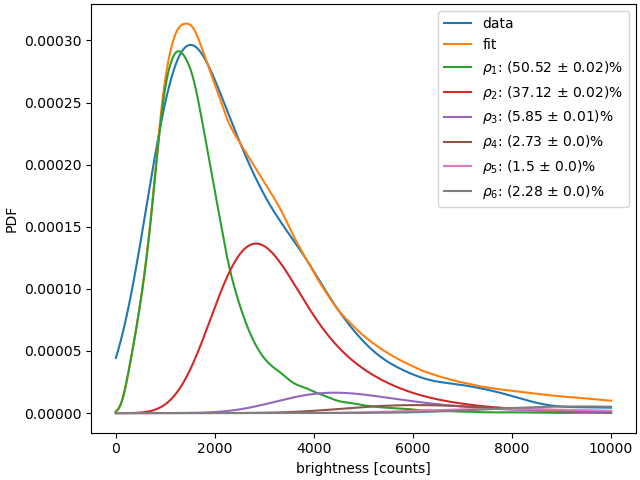

In [74]:
sm_bool = False

if sm_bool == False:
    sm_int_data_filtered = None

if type(toccsl_int_data_filtered) == dict:
    alphas = {}
    fitted_pd = {}
    means = {}
    SEMs = {}
    fig = {}
    for k, toccsl_data in tqdm(toccsl_int_data_filtered.items(), desc='Groups'):
        ind = int(k[1])-1
        if sm_bool == False:
            if sm_start_frame == None:
                save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_noSM_last_frame_results_n{}.png')
            else:
                save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_noSM_startframe{}'.format(sm_start_frame) + '_results_n{}.png')
        else:
            save_path = results_path.format('TOCCSL{}'.format(k) + '_roi'+str(roi_pos[ind])[0:6] + '_results_n{}.png')
        alphas[k], fitted_pd[k], means[k], SEMs[k], fig[k] = get_results(toccsl_data, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, iterations=iterations, perc=perc, save_path=save_path)
else:
    if sm_bool == False:
        if sm_start_frame == None:
            save_path = results_path.format('TOCCSL' + '_roi'+str(roi_pos[0])[0:6] + '_noSM_last_frame_results_n{}.png')
        else:
            save_path = results_path.format('TOCCSL' + '_roi'+str(roi_pos[0])[0:6] + '_noSM_startframe{}'.format(sm_start_frame) + '_results_n{}.png')
    else:
        save_path = results_path.format('TOCCSL' +  '_roi'+str(roi_pos[0])[0:6] + '_results_n{}.png')
    alphas, fitted_pd, means, SEMs, fig = get_results(toccsl_int_data_filtered, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=rec_frame, lim=lim, lim_con=lim_con, iterations=iterations, perc=perc, save_path=save_path)

Initial analysis completed - Elapsed time: 1.015753984451294s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 62.42935061454773s
Initial analysis completed - Elapsed time: 0.9878487586975098s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 62.228673458099365s
Initial analysis completed - Elapsed time: 1.0056788921356201s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 61.52548432350159s
Initial analysis completed - Elapsed time: 0.9892246723175049s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 61.46146082878113s
Initial analysis completed - Elapsed time: 0.988332986831665s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 60.4334135055542s
Initial analysis completed - Elapsed time: 0.9826555252075195s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 61.16771125793457s
Initial analysis completed - Elapsed time: 0.9820480346679688s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 61.10475492477417s
Initial analysis completed - Elapsed time: 0.9946672916412354s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 60.409021615982056s
Initial analysis completed - Elapsed time: 0.9745969772338867s


bootstrap iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap completed - Elapsed time: 60.165353536605835s


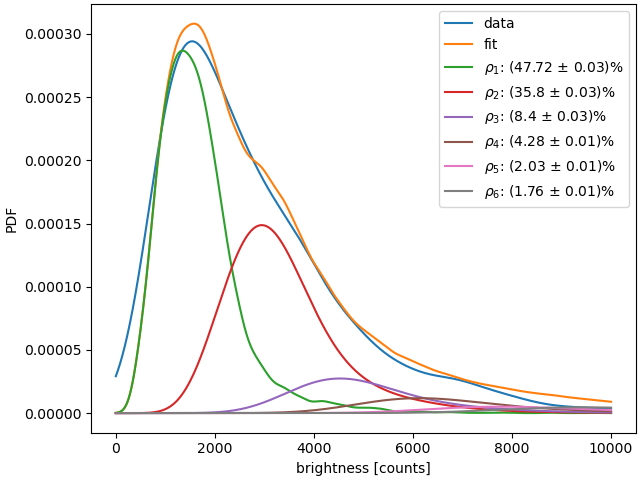

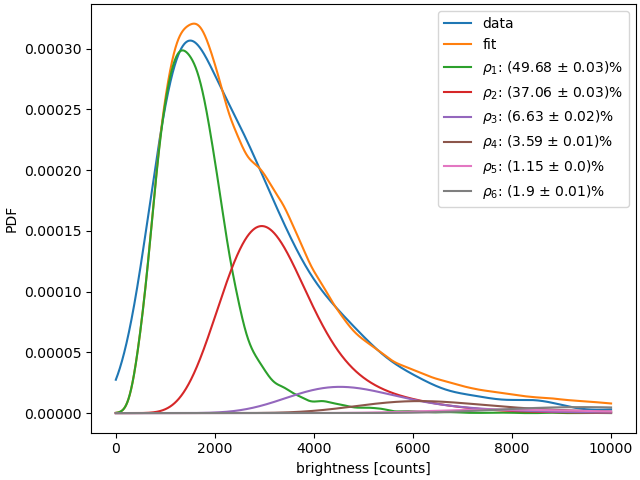

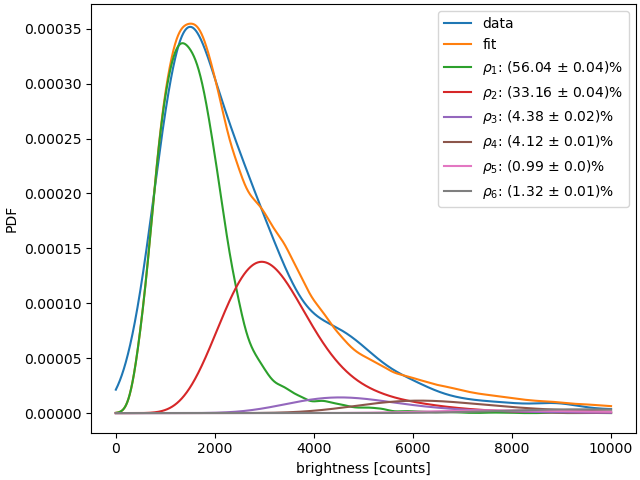

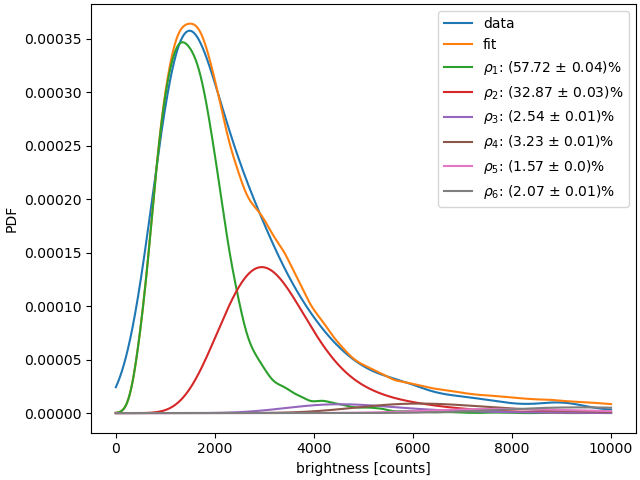

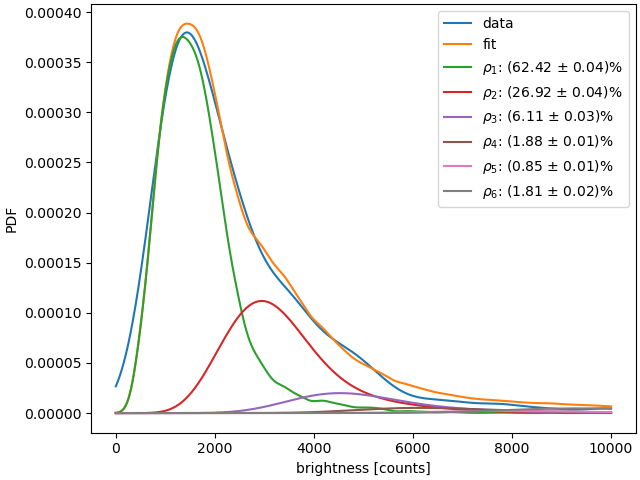

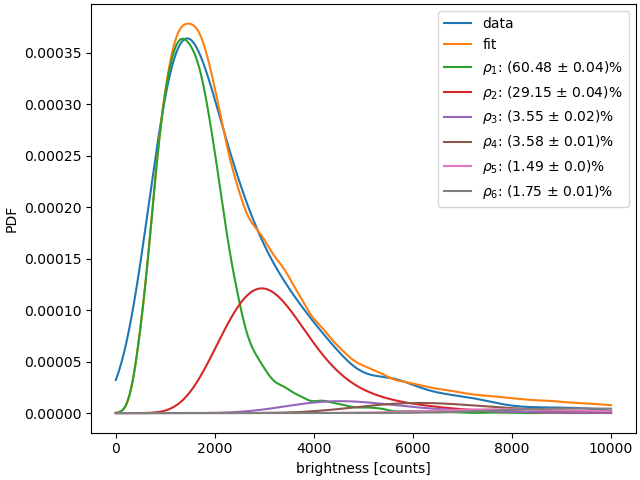

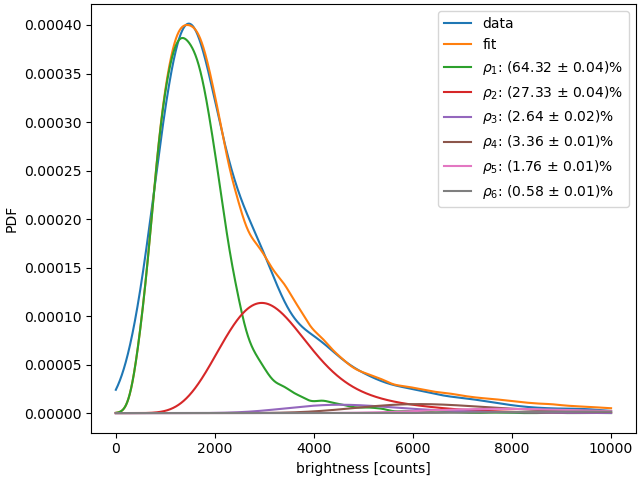

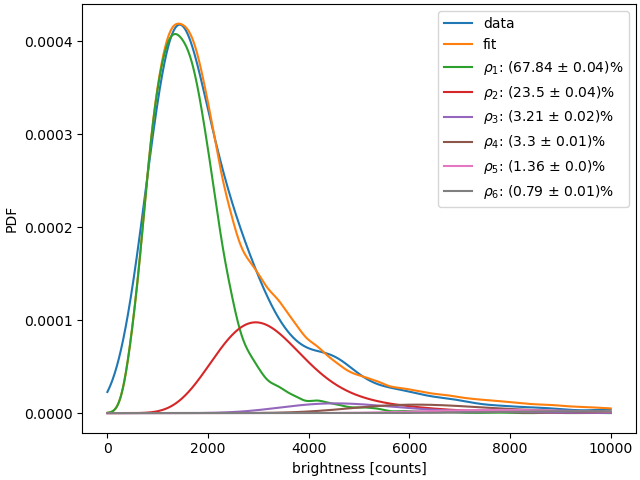

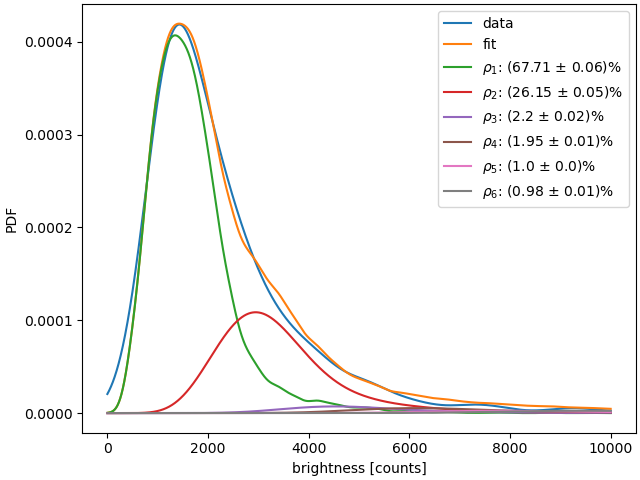

In [54]:
import os
if not os.path.exists(results_path.format(f'frame_composition_sm{sm_bool}/')):
    os.makedirs(results_path.format(f'frame_composition_sm{sm_bool}/'))

alphas = []
fitted_pds = []
means = []
SEMs = []
for analysis_frame in np.arange(rec_frame, rec_frame+9):
    i = analysis_frame - rec_frame
    alpha, fitted_pd, mean, SEM, fig_temp = get_results(toccsl_int_data_filtered, sm_int_data_filtered, sm_start_frame=sm_start_frame, rec_frame=analysis_frame, lim=lim, lim_con=lim_con, iterations=iterations, perc=perc, save_path=results_path.format('dump'), own_pdf_calc=own_pdf_calc)
    alphas.append(alpha)
    fitted_pds.append(fitted_pd)
    means.append(mean)
    SEMs.append(SEM)
    fig_temp.savefig(results_path.format(f'frame_composition_sm{sm_bool}/frame_{analysis_frame}.png'))


In [124]:
x = np.linspace(0, 10, 200)
bw = 0.3
y = stats.gaussian_kde(np.array([2, 6]), bw_method=lambda x: x).pdf(x)

TypeError: unsupported operand type(s) for ** or pow(): 'gaussian_kde' and 'int'

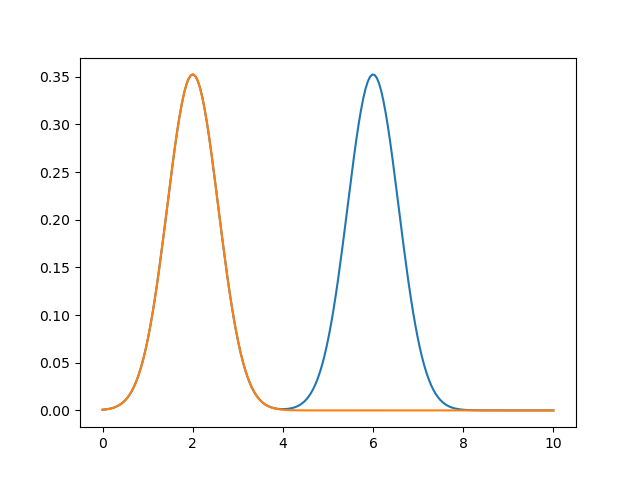

In [121]:
A, sigma = scipy.optimize.curve_fit(lambda x, A, sig: A*(np.exp(-(x-2)**2/(2*sig**2))+np.exp(-(x-6)**2/(2*sig**2))), x, y)[0]
plt.close('all')
plt.plot(x,y)
plt.plot(x,A * np.exp(-(x-2)**2/(2*sigma**2)))

In [122]:
print(sigma)
print(sigma/bw)

0.5656854249492381
1.8856180831641272


0.9999984706020607

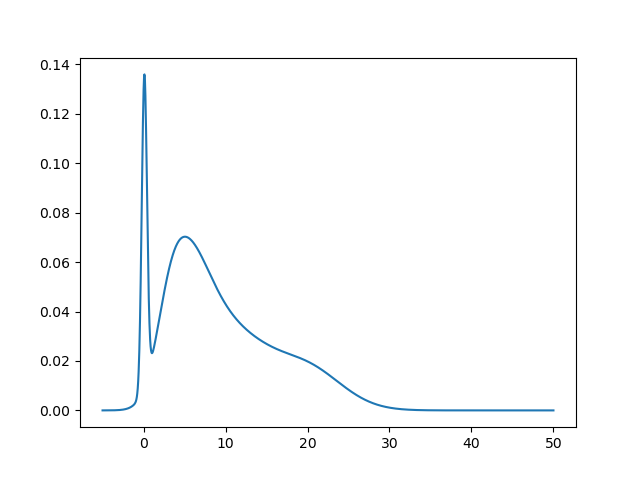

In [140]:
x, h = np.linspace(-5, 50, 2000, retstep=True)
test = np.array([5, 0.1, 5, 3, 7, 8, 13, 19, 11, 20])
y = np.zeros_like(x)
for val in test:
    y += 1/np.sqrt(2*np.pi*val) * np.exp(-(x-val)**2/(2*val))
y /= len(test)
plt.close('all')
plt.plot(x, y)
h*np.sum(y)